In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import itertools

In [133]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [134]:
SIGNAL_CATEGORIES = {
    'ECG_BVP': [
        'HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV',
        'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'
    ],
    'EDA': [
        'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_range', 'EDA_slope',
        'scl_mean', 'scl_std', 'scr_mean', 'scr_std', 'corr_scl_t',
        'scr_count', 'scr_amp', 'scr_sum', 'scr_area'
    ],
    'EMG': [
        'EMG_mean', 'EMG_std', 'EMG_median', 'EMG_p10', 'EMG_p90', 'EMG_range',
        'EMG_sum', 'EMG_f_peak',
        'EMG_psd_0_10Hz', 'EMG_psd_10_20Hz', 'EMG_psd_20_50Hz',
        'EMG_psd_50_100Hz', 'EMG_psd_100_150Hz', 'EMG_psd_150_250Hz',
        'EMG_psd_250_350Hz',
        'EMG_peak_count', 'EMG_peak_amp_mean', 'EMG_peak_amp_std',
        'EMG_peak_amp_sum', 'EMG_peak_amp_norm'
    ],
    'RESP': [
        'Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std',
        'Resp_E_mean', 'Resp_E_std', 'Resp_IE_ratio', 'Resp_range',
        'Resp_insp_vol', 'Resp_rate', 'Resp_duration'
    ],
    'TEMP': [
        'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Temp_range', 'Temp_slope'
    ]
}

random = 13577

In [135]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [136]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [137]:
def train_and_evaluate(X, y, model, param_grid, model_name, signal_name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random, stratify=y)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=16, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]
    
    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    print(classification_report(y_test, y_pred))

    return metrics

In [138]:
def train_and_evaluate_logo(X, y, groups, model, param_grid, model_name, signal_name):
    logo = LeaveOneGroupOut()

    n_splits = logo.get_n_splits(groups=groups)
    print(f"[{signal_name} - {model_name}] LOGO: {n_splits} folds (1 por sujeto)")

    grid_search = GridSearchCV(model, param_grid, cv=logo.split(X, y, groups=groups), n_jobs=16, verbose=1)
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    y_pred = []
    y_true = []

    fold_accuracies = []
    subject_ids = []

    # Evaluamos con LOGO para obtener predicciones fuera de muestra
    for i, (train_idx, test_idx) in enumerate(logo.split(X, y, groups), 1):
        subject_tested = np.unique(groups[test_idx])[0]
        assert len(np.unique(groups[test_idx])) == 1, "Test set debe contener exactamente un sujeto"
        print(f"[{signal_name} - {model_name}] Fold {i}/{n_splits} (Subject: {subject_tested})")

        best_model.fit(X[train_idx], y[train_idx])
        preds = best_model.predict(X[test_idx])

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

        acc_fold = accuracy_score(y[test_idx], preds)
        fold_accuracies.append(acc_fold)
        subject_ids.append(subject_tested)

    # Crear gráfico de accuracy por sujeto
    plt.figure(figsize=(10, 4))
    plt.plot(subject_ids, fold_accuracies, marker='o', linestyle='-')
    plt.xticks(subject_ids)
    plt.title(f'Accuracy por sujeto - {signal_name} - {model_name}')
    plt.xlabel('Sujeto')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    metrics = calculate_metrics(y_true, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]

    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_true, y_pred, f'{signal_name} - {model_name}')
    print(classification_report(y_true, y_pred))

    return metrics

In [139]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=random, criterion="entropy", min_samples_split=20),
        {
        }
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight='balanced', random_state=random, criterion='entropy', n_estimators=100, min_samples_split=20),
        {
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random),
        {
            "n_estimators": [100],
            "learning_rate": [0.01, 0.1, 0.5, 1],
            "estimator": [
                DecisionTreeClassifier(max_depth=1, class_weight='balanced', criterion="entropy", min_samples_split=20)
            ]
        }
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [9],
            "weights": ["uniform", "distance"]
        }
    )
}

results = {}


all_signals = list(SIGNAL_CATEGORIES.keys())
combinations = []
for r in range(2, len(all_signals) + 1):
    combinations.extend(itertools.combinations(all_signals, r))

In [140]:
file = r'WESAD_DATA_60_025\features.csv'

df = load_data(file)
df = df.fillna(0)

In [141]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 68659
Label: 2 total: 38904
Label: 3 total: 21459


In [142]:
#Aplicar muestra binaria
df['label'] = df['label'].apply(lambda x: 1 if x in [1, 3] else 2)

In [143]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 90118
Label: 2 total: 38904


Training by signal:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ECG_BVP using LOGO...
[ECG_BVP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - DecisionTree] Fold 1/15 (Subject: 2)
[ECG_BVP - DecisionTree] Fold 2/15 (Subject: 3)
[ECG_BVP - DecisionTree] Fold 3/15 (Subject: 4)
[ECG_BVP - DecisionTree] Fold 4/15 (Subject: 5)
[ECG_BVP - DecisionTree] Fold 5/15 (Subject: 6)
[ECG_BVP - DecisionTree] Fold 6/15 (Subject: 7)
[ECG_BVP - DecisionTree] Fold 7/15 (Subject: 8)
[ECG_BVP - DecisionTree] Fold 8/15 (Subject: 9)
[ECG_BVP - DecisionTree] Fold 9/15 (Subject: 10)
[ECG_BVP - DecisionTree] Fold 10/15 (Subject: 11)
[ECG_BVP - DecisionTree] Fold 11/15 (Subject: 13)
[ECG_BVP - DecisionTree] Fold 12/15 (Subject: 14)
[ECG_BVP - DecisionTree] Fold 13/15 (Subject: 15)
[ECG_BVP - DecisionTree] Fold 14/15 (Subject: 16)
[ECG_BVP - DecisionTree] Fold 15/15 (Subject: 17)


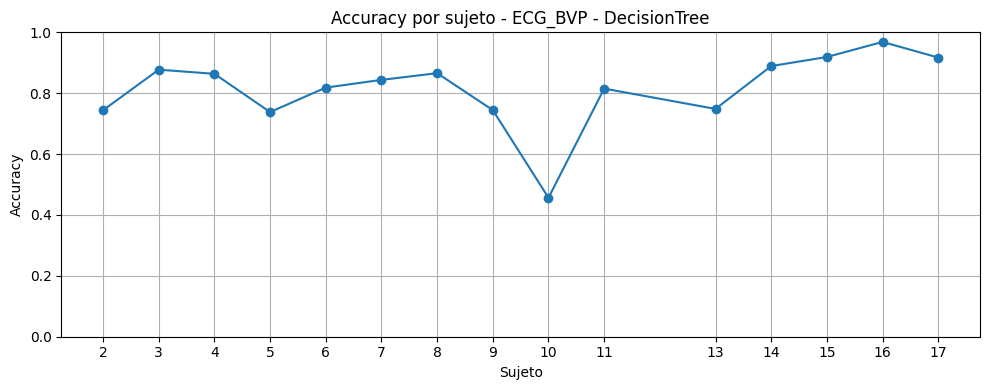

ECG_BVP - DecisionTree Metrics
     Métrica     Valor                   Etapa
0   Accuracy  0.813590  ECG_BVP - DecisionTree
1  Precision  0.817094  ECG_BVP - DecisionTree
2     Recall  0.813590  ECG_BVP - DecisionTree
3   F1 Score  0.815065  ECG_BVP - DecisionTree
[ECG_BVP - DecisionTree] Best Params: {}
[ECG_BVP - DecisionTree] Accuracy: 0.8136
ECG_BVP - DecisionTree - Confusion Matrix
[[76939 13179]
 [10872 28032]]


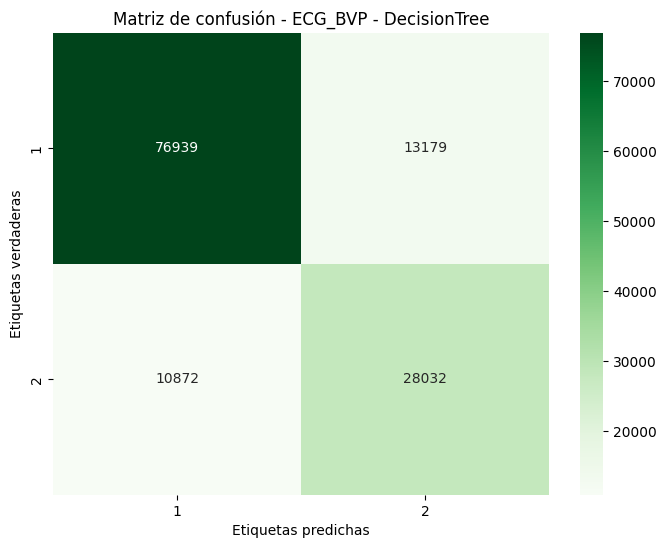

              precision    recall  f1-score   support

           1       0.88      0.85      0.86     90118
           2       0.68      0.72      0.70     38904

    accuracy                           0.81    129022
   macro avg       0.78      0.79      0.78    129022
weighted avg       0.82      0.81      0.82    129022

Training RandomForest model for ECG_BVP using LOGO...
[ECG_BVP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - RandomForest] Fold 1/15 (Subject: 2)
[ECG_BVP - RandomForest] Fold 2/15 (Subject: 3)
[ECG_BVP - RandomForest] Fold 3/15 (Subject: 4)
[ECG_BVP - RandomForest] Fold 4/15 (Subject: 5)
[ECG_BVP - RandomForest] Fold 5/15 (Subject: 6)
[ECG_BVP - RandomForest] Fold 6/15 (Subject: 7)
[ECG_BVP - RandomForest] Fold 7/15 (Subject: 8)
[ECG_BVP - RandomForest] Fold 8/15 (Subject: 9)
[ECG_BVP - RandomForest] Fold 9/15 (Subject: 10)
[ECG_BVP - RandomForest] Fold 10/15 (Subject: 11)
[ECG_BVP - RandomFor

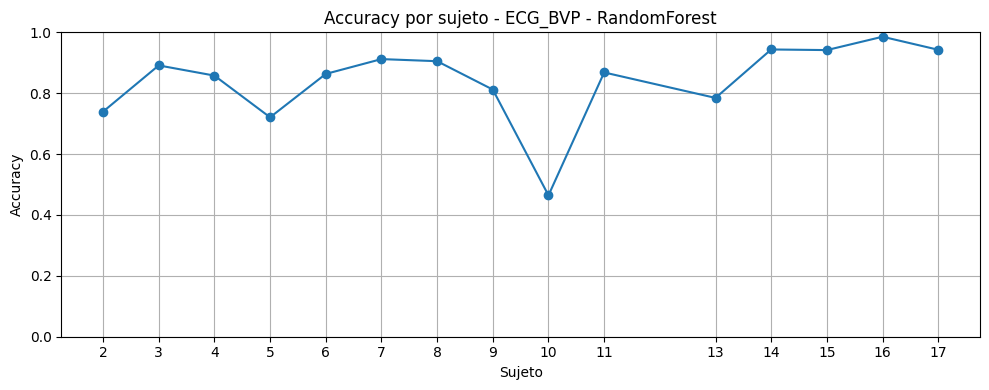

ECG_BVP - RandomForest Metrics
     Métrica     Valor                   Etapa
0   Accuracy  0.841887  ECG_BVP - RandomForest
1  Precision  0.840562  ECG_BVP - RandomForest
2     Recall  0.841887  ECG_BVP - RandomForest
3   F1 Score  0.841135  ECG_BVP - RandomForest
[ECG_BVP - RandomForest] Best Params: {}
[ECG_BVP - RandomForest] Accuracy: 0.8419
ECG_BVP - RandomForest - Confusion Matrix
[[80548  9570]
 [10830 28074]]


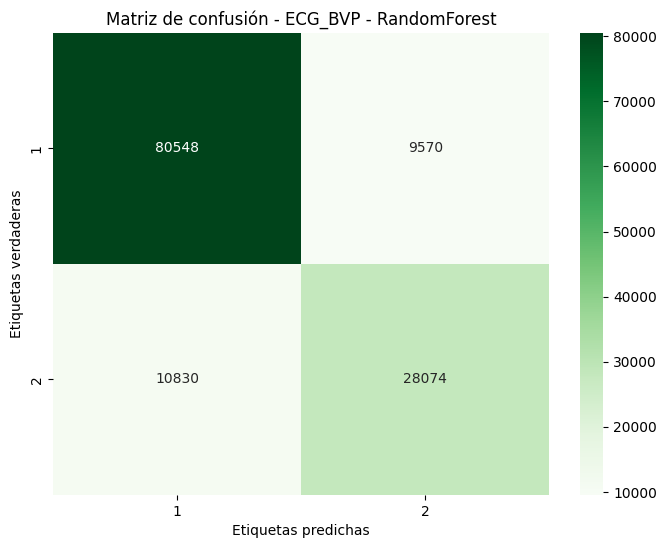

              precision    recall  f1-score   support

           1       0.88      0.89      0.89     90118
           2       0.75      0.72      0.73     38904

    accuracy                           0.84    129022
   macro avg       0.81      0.81      0.81    129022
weighted avg       0.84      0.84      0.84    129022

Training AdaBoost model for ECG_BVP using LOGO...
[ECG_BVP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[ECG_BVP - AdaBoost] Fold 1/15 (Subject: 2)
[ECG_BVP - AdaBoost] Fold 2/15 (Subject: 3)
[ECG_BVP - AdaBoost] Fold 3/15 (Subject: 4)
[ECG_BVP - AdaBoost] Fold 4/15 (Subject: 5)
[ECG_BVP - AdaBoost] Fold 5/15 (Subject: 6)
[ECG_BVP - AdaBoost] Fold 6/15 (Subject: 7)
[ECG_BVP - AdaBoost] Fold 7/15 (Subject: 8)
[ECG_BVP - AdaBoost] Fold 8/15 (Subject: 9)
[ECG_BVP - AdaBoost] Fold 9/15 (Subject: 10)
[ECG_BVP - AdaBoost] Fold 10/15 (Subject: 11)
[ECG_BVP - AdaBoost] Fold 11/15 (Subject: 13)
[ECG_BVP - AdaBoost] F

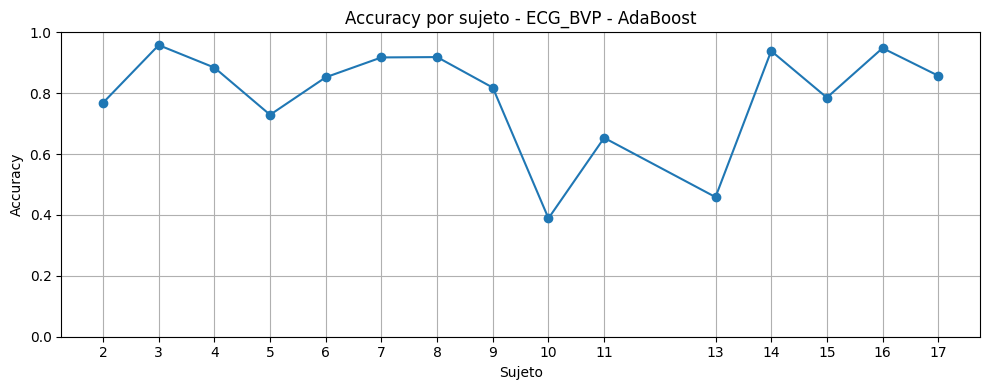

ECG_BVP - AdaBoost Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.790602  ECG_BVP - AdaBoost
1  Precision  0.819998  ECG_BVP - AdaBoost
2     Recall  0.790602  ECG_BVP - AdaBoost
3   F1 Score  0.797422  ECG_BVP - AdaBoost
[ECG_BVP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.1, 'n_estimators': 100}
[ECG_BVP - AdaBoost] Accuracy: 0.7906
ECG_BVP - AdaBoost - Confusion Matrix
[[70157 19961]
 [ 7056 31848]]


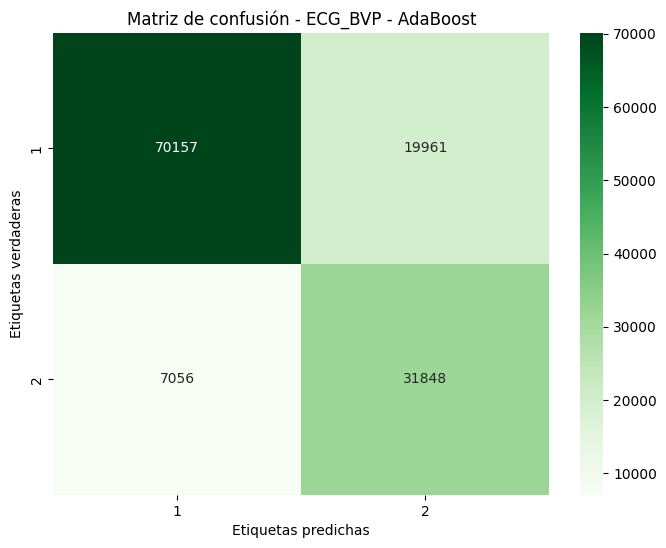

              precision    recall  f1-score   support

           1       0.91      0.78      0.84     90118
           2       0.61      0.82      0.70     38904

    accuracy                           0.79    129022
   macro avg       0.76      0.80      0.77    129022
weighted avg       0.82      0.79      0.80    129022

Training LDA model for ECG_BVP using LOGO...
[ECG_BVP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - LDA] Fold 1/15 (Subject: 2)
[ECG_BVP - LDA] Fold 2/15 (Subject: 3)
[ECG_BVP - LDA] Fold 3/15 (Subject: 4)
[ECG_BVP - LDA] Fold 4/15 (Subject: 5)
[ECG_BVP - LDA] Fold 5/15 (Subject: 6)
[ECG_BVP - LDA] Fold 6/15 (Subject: 7)
[ECG_BVP - LDA] Fold 7/15 (Subject: 8)
[ECG_BVP - LDA] Fold 8/15 (Subject: 9)
[ECG_BVP - LDA] Fold 9/15 (Subject: 10)
[ECG_BVP - LDA] Fold 10/15 (Subject: 11)
[ECG_BVP - LDA] Fold 11/15 (Subject: 13)
[ECG_BVP - LDA] Fold 12/15 (Subject: 14)
[ECG_BVP - LDA] Fold 13/15 (Subject: 15)
[ECG_

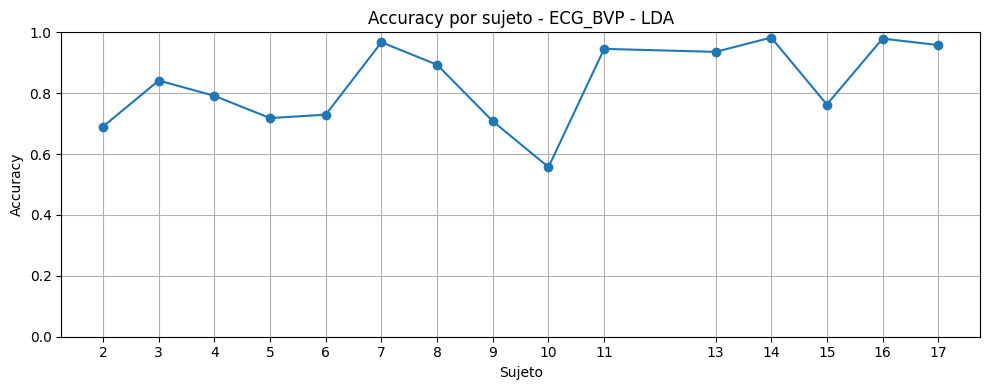

ECG_BVP - LDA Metrics
     Métrica     Valor          Etapa
0   Accuracy  0.831114  ECG_BVP - LDA
1  Precision  0.827553  ECG_BVP - LDA
2     Recall  0.831114  ECG_BVP - LDA
3   F1 Score  0.823184  ECG_BVP - LDA
[ECG_BVP - LDA] Best Params: {'solver': 'svd'}
[ECG_BVP - LDA] Accuracy: 0.8311
ECG_BVP - LDA - Confusion Matrix
[[84181  5937]
 [15853 23051]]


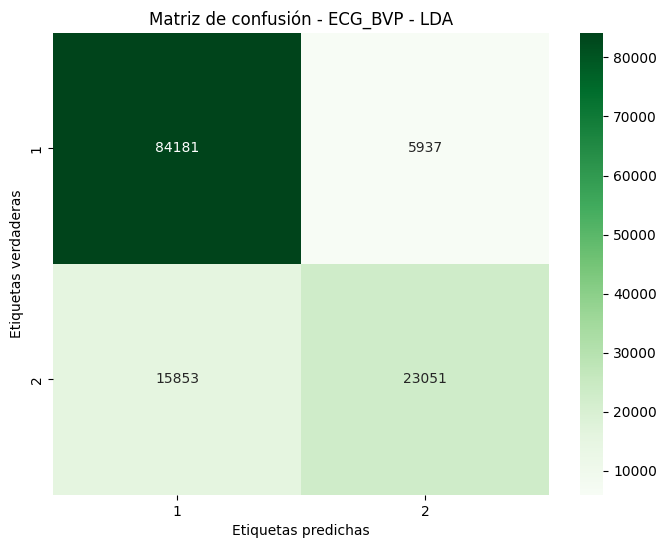

              precision    recall  f1-score   support

           1       0.84      0.93      0.89     90118
           2       0.80      0.59      0.68     38904

    accuracy                           0.83    129022
   macro avg       0.82      0.76      0.78    129022
weighted avg       0.83      0.83      0.82    129022

Training KNN model for ECG_BVP using LOGO...
[ECG_BVP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[ECG_BVP - KNN] Fold 1/15 (Subject: 2)
[ECG_BVP - KNN] Fold 2/15 (Subject: 3)
[ECG_BVP - KNN] Fold 3/15 (Subject: 4)
[ECG_BVP - KNN] Fold 4/15 (Subject: 5)
[ECG_BVP - KNN] Fold 5/15 (Subject: 6)
[ECG_BVP - KNN] Fold 6/15 (Subject: 7)
[ECG_BVP - KNN] Fold 7/15 (Subject: 8)
[ECG_BVP - KNN] Fold 8/15 (Subject: 9)
[ECG_BVP - KNN] Fold 9/15 (Subject: 10)
[ECG_BVP - KNN] Fold 10/15 (Subject: 11)
[ECG_BVP - KNN] Fold 11/15 (Subject: 13)
[ECG_BVP - KNN] Fold 12/15 (Subject: 14)
[ECG_BVP - KNN] Fold 13/15 (Subject: 15)
[ECG_

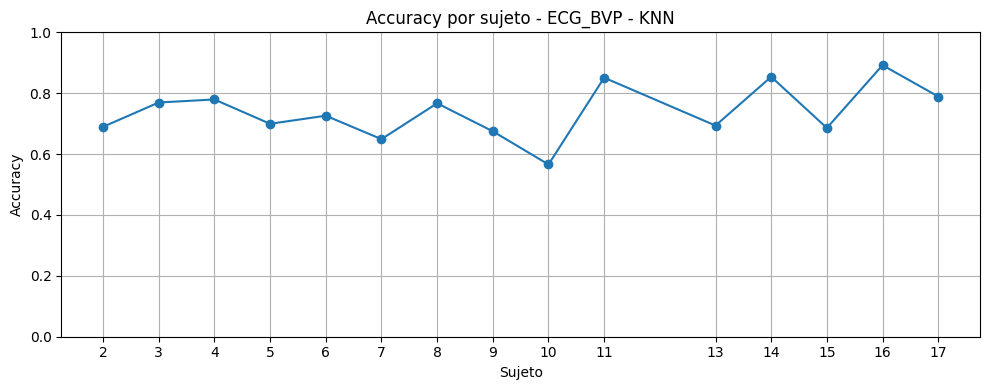

ECG_BVP - KNN Metrics
     Métrica     Valor          Etapa
0   Accuracy  0.739045  ECG_BVP - KNN
1  Precision  0.735736  ECG_BVP - KNN
2     Recall  0.739045  ECG_BVP - KNN
3   F1 Score  0.737240  ECG_BVP - KNN
[ECG_BVP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[ECG_BVP - KNN] Accuracy: 0.7390
ECG_BVP - KNN - Confusion Matrix
[[74186 15932]
 [17737 21167]]


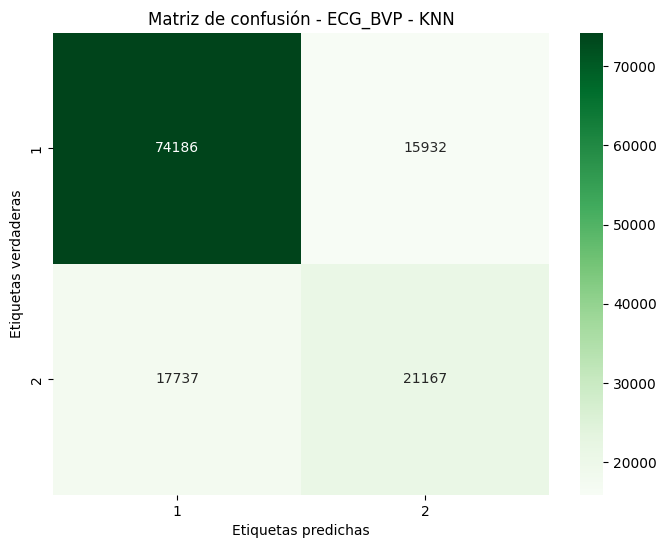

Training by signal:  20%|██        | 1/5 [22:52<1:31:31, 1372.98s/it]

              precision    recall  f1-score   support

           1       0.81      0.82      0.82     90118
           2       0.57      0.54      0.56     38904

    accuracy                           0.74    129022
   macro avg       0.69      0.68      0.69    129022
weighted avg       0.74      0.74      0.74    129022

Training DecisionTree model for EDA using LOGO...
[EDA - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - DecisionTree] Fold 1/15 (Subject: 2)
[EDA - DecisionTree] Fold 2/15 (Subject: 3)
[EDA - DecisionTree] Fold 3/15 (Subject: 4)
[EDA - DecisionTree] Fold 4/15 (Subject: 5)
[EDA - DecisionTree] Fold 5/15 (Subject: 6)
[EDA - DecisionTree] Fold 6/15 (Subject: 7)
[EDA - DecisionTree] Fold 7/15 (Subject: 8)
[EDA - DecisionTree] Fold 8/15 (Subject: 9)
[EDA - DecisionTree] Fold 9/15 (Subject: 10)
[EDA - DecisionTree] Fold 10/15 (Subject: 11)
[EDA - DecisionTree] Fold 11/15 (Subject: 13)
[EDA - DecisionTree] F

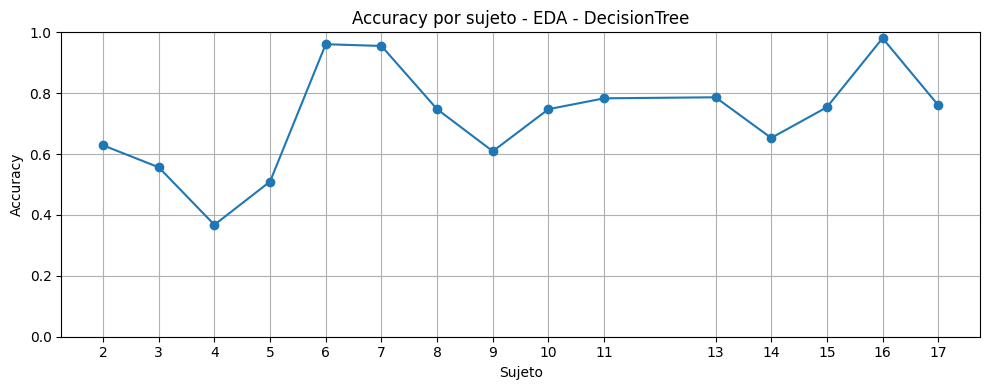

EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.721280  EDA - DecisionTree
1  Precision  0.729907  EDA - DecisionTree
2     Recall  0.721280  EDA - DecisionTree
3   F1 Score  0.724911  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {}
[EDA - DecisionTree] Accuracy: 0.7213
EDA - DecisionTree - Confusion Matrix
[[70150 19968]
 [15993 22911]]


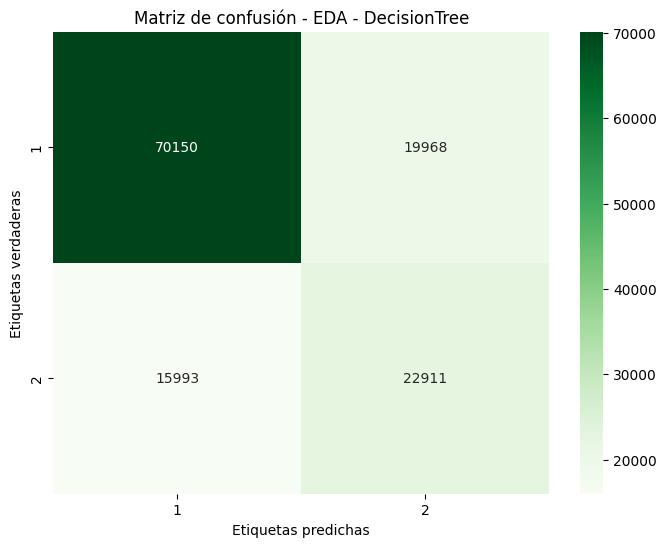

              precision    recall  f1-score   support

           1       0.81      0.78      0.80     90118
           2       0.53      0.59      0.56     38904

    accuracy                           0.72    129022
   macro avg       0.67      0.68      0.68    129022
weighted avg       0.73      0.72      0.72    129022

Training RandomForest model for EDA using LOGO...
[EDA - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - RandomForest] Fold 1/15 (Subject: 2)
[EDA - RandomForest] Fold 2/15 (Subject: 3)
[EDA - RandomForest] Fold 3/15 (Subject: 4)
[EDA - RandomForest] Fold 4/15 (Subject: 5)
[EDA - RandomForest] Fold 5/15 (Subject: 6)
[EDA - RandomForest] Fold 6/15 (Subject: 7)
[EDA - RandomForest] Fold 7/15 (Subject: 8)
[EDA - RandomForest] Fold 8/15 (Subject: 9)
[EDA - RandomForest] Fold 9/15 (Subject: 10)
[EDA - RandomForest] Fold 10/15 (Subject: 11)
[EDA - RandomForest] Fold 11/15 (Subject: 13)
[EDA - RandomForest] F

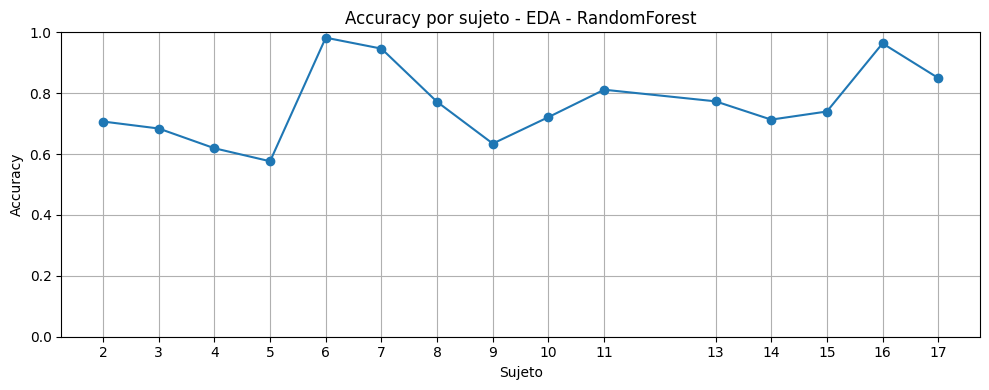

EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.766823  EDA - RandomForest
1  Precision  0.765837  EDA - RandomForest
2     Recall  0.766823  EDA - RandomForest
3   F1 Score  0.766313  EDA - RandomForest
[EDA - RandomForest] Best Params: {}
[EDA - RandomForest] Accuracy: 0.7668
EDA - RandomForest - Confusion Matrix
[[75370 14748]
 [15337 23567]]


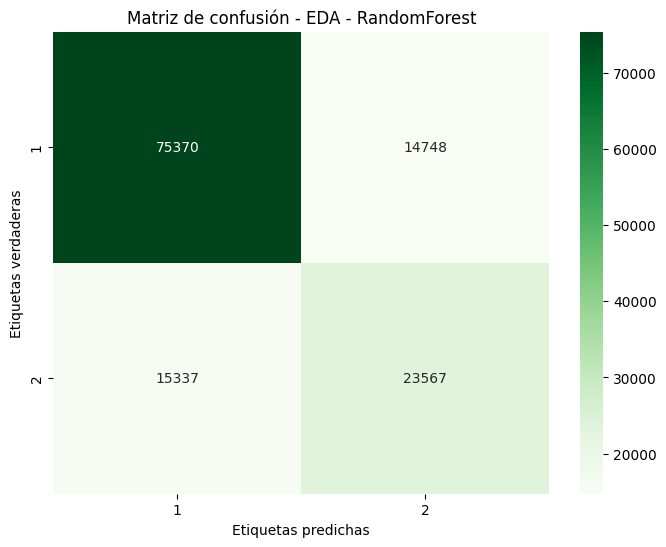

              precision    recall  f1-score   support

           1       0.83      0.84      0.83     90118
           2       0.62      0.61      0.61     38904

    accuracy                           0.77    129022
   macro avg       0.72      0.72      0.72    129022
weighted avg       0.77      0.77      0.77    129022

Training AdaBoost model for EDA using LOGO...
[EDA - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[EDA - AdaBoost] Fold 1/15 (Subject: 2)
[EDA - AdaBoost] Fold 2/15 (Subject: 3)
[EDA - AdaBoost] Fold 3/15 (Subject: 4)
[EDA - AdaBoost] Fold 4/15 (Subject: 5)
[EDA - AdaBoost] Fold 5/15 (Subject: 6)
[EDA - AdaBoost] Fold 6/15 (Subject: 7)
[EDA - AdaBoost] Fold 7/15 (Subject: 8)
[EDA - AdaBoost] Fold 8/15 (Subject: 9)
[EDA - AdaBoost] Fold 9/15 (Subject: 10)
[EDA - AdaBoost] Fold 10/15 (Subject: 11)
[EDA - AdaBoost] Fold 11/15 (Subject: 13)
[EDA - AdaBoost] Fold 12/15 (Subject: 14)
[EDA - AdaBoost] Fold 13/15 (Sub

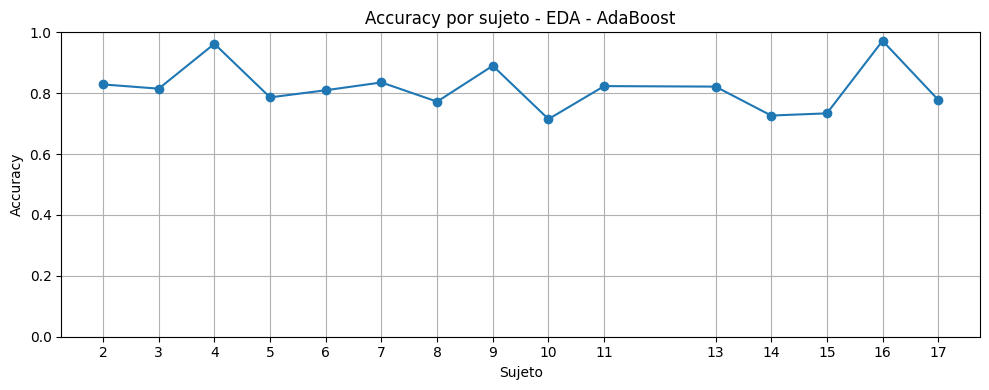

EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.817450  EDA - AdaBoost
1  Precision  0.813995  EDA - AdaBoost
2     Recall  0.817450  EDA - AdaBoost
3   F1 Score  0.815181  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.01, 'n_estimators': 100}
[EDA - AdaBoost] Accuracy: 0.8174
EDA - AdaBoost - Confusion Matrix
[[79907 10211]
 [13342 25562]]


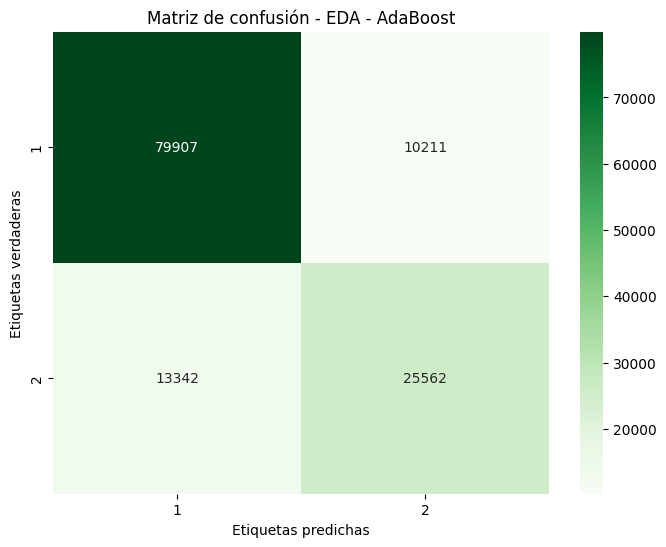

              precision    recall  f1-score   support

           1       0.86      0.89      0.87     90118
           2       0.71      0.66      0.68     38904

    accuracy                           0.82    129022
   macro avg       0.79      0.77      0.78    129022
weighted avg       0.81      0.82      0.82    129022

Training LDA model for EDA using LOGO...
[EDA - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - LDA] Fold 1/15 (Subject: 2)
[EDA - LDA] Fold 2/15 (Subject: 3)
[EDA - LDA] Fold 3/15 (Subject: 4)
[EDA - LDA] Fold 4/15 (Subject: 5)
[EDA - LDA] Fold 5/15 (Subject: 6)
[EDA - LDA] Fold 6/15 (Subject: 7)
[EDA - LDA] Fold 7/15 (Subject: 8)
[EDA - LDA] Fold 8/15 (Subject: 9)
[EDA - LDA] Fold 9/15 (Subject: 10)
[EDA - LDA] Fold 10/15 (Subject: 11)
[EDA - LDA] Fold 11/15 (Subject: 13)
[EDA - LDA] Fold 12/15 (Subject: 14)
[EDA - LDA] Fold 13/15 (Subject: 15)
[EDA - LDA] Fold 14/15 (Subject: 16)
[EDA - LDA] Fold 15/15 (Subj

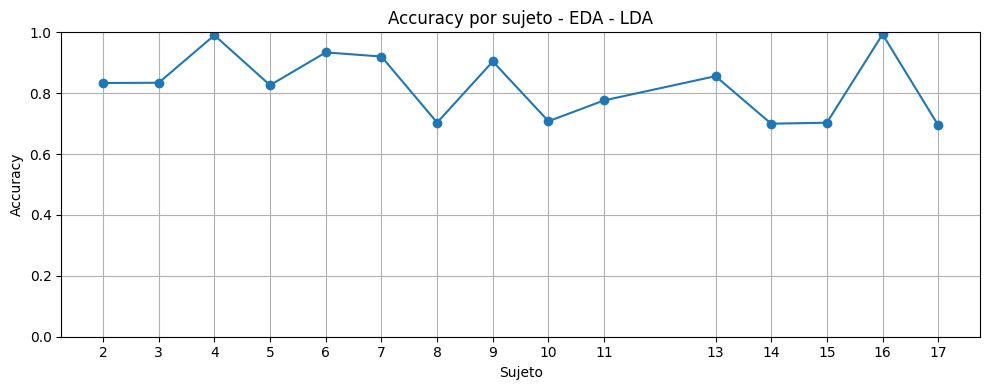

EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.824239  EDA - LDA
1  Precision  0.827848  EDA - LDA
2     Recall  0.824239  EDA - LDA
3   F1 Score  0.809157  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.8242
EDA - LDA - Confusion Matrix
[[86596  3522]
 [19155 19749]]


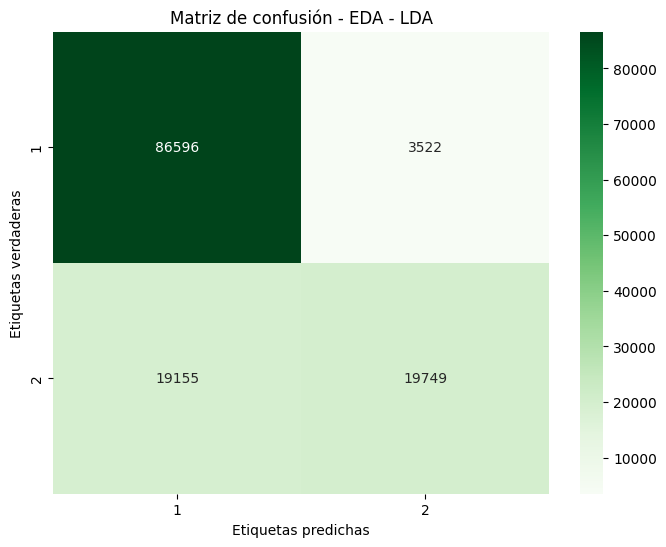

              precision    recall  f1-score   support

           1       0.82      0.96      0.88     90118
           2       0.85      0.51      0.64     38904

    accuracy                           0.82    129022
   macro avg       0.83      0.73      0.76    129022
weighted avg       0.83      0.82      0.81    129022

Training KNN model for EDA using LOGO...
[EDA - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[EDA - KNN] Fold 1/15 (Subject: 2)
[EDA - KNN] Fold 2/15 (Subject: 3)
[EDA - KNN] Fold 3/15 (Subject: 4)
[EDA - KNN] Fold 4/15 (Subject: 5)
[EDA - KNN] Fold 5/15 (Subject: 6)
[EDA - KNN] Fold 6/15 (Subject: 7)
[EDA - KNN] Fold 7/15 (Subject: 8)
[EDA - KNN] Fold 8/15 (Subject: 9)
[EDA - KNN] Fold 9/15 (Subject: 10)
[EDA - KNN] Fold 10/15 (Subject: 11)
[EDA - KNN] Fold 11/15 (Subject: 13)
[EDA - KNN] Fold 12/15 (Subject: 14)
[EDA - KNN] Fold 13/15 (Subject: 15)
[EDA - KNN] Fold 14/15 (Subject: 16)
[EDA - KNN] Fold 15/15 (Subj

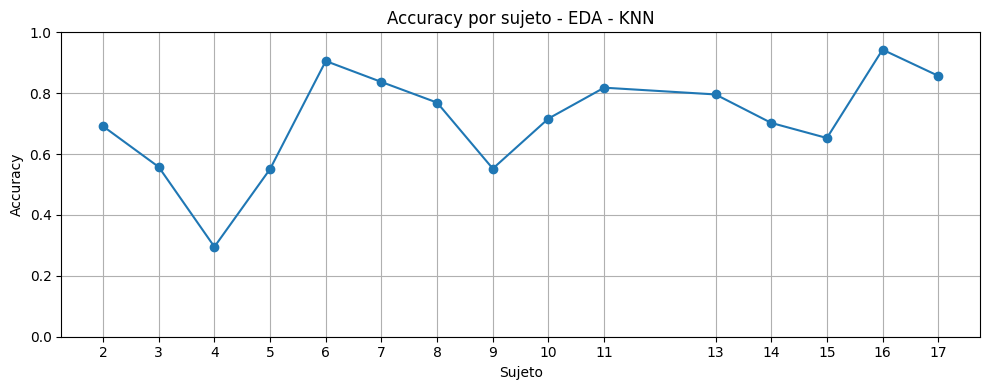

EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.710995  EDA - KNN
1  Precision  0.736619  EDA - KNN
2     Recall  0.710995  EDA - KNN
3   F1 Score  0.719229  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.7110
EDA - KNN - Confusion Matrix
[[66232 23886]
 [13402 25502]]


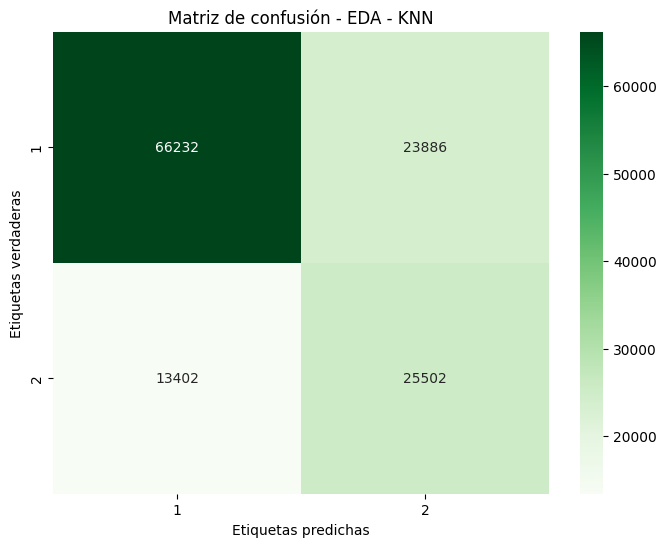

Training by signal:  40%|████      | 2/5 [39:38<57:50, 1156.68s/it]  

              precision    recall  f1-score   support

           1       0.83      0.73      0.78     90118
           2       0.52      0.66      0.58     38904

    accuracy                           0.71    129022
   macro avg       0.67      0.70      0.68    129022
weighted avg       0.74      0.71      0.72    129022

Training DecisionTree model for EMG using LOGO...
[EMG - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EMG - DecisionTree] Fold 1/15 (Subject: 2)
[EMG - DecisionTree] Fold 2/15 (Subject: 3)
[EMG - DecisionTree] Fold 3/15 (Subject: 4)
[EMG - DecisionTree] Fold 4/15 (Subject: 5)
[EMG - DecisionTree] Fold 5/15 (Subject: 6)
[EMG - DecisionTree] Fold 6/15 (Subject: 7)
[EMG - DecisionTree] Fold 7/15 (Subject: 8)
[EMG - DecisionTree] Fold 8/15 (Subject: 9)
[EMG - DecisionTree] Fold 9/15 (Subject: 10)
[EMG - DecisionTree] Fold 10/15 (Subject: 11)
[EMG - DecisionTree] Fold 11/15 (Subject: 13)
[EMG - DecisionTree] F

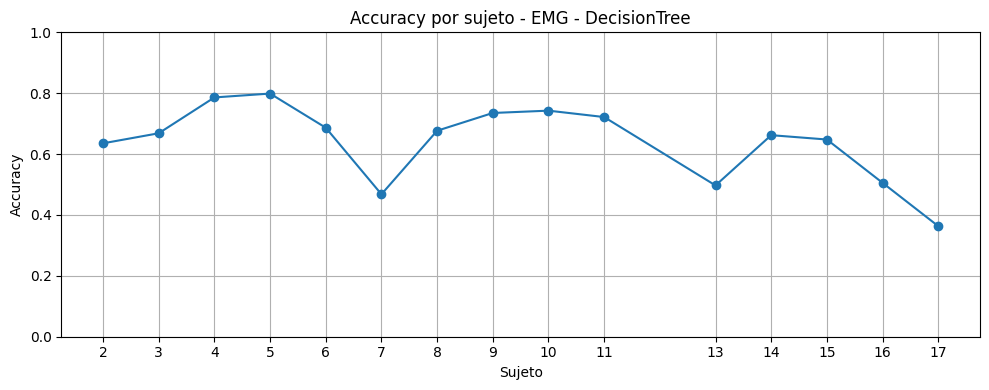

EMG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.639108  EMG - DecisionTree
1  Precision  0.640972  EMG - DecisionTree
2     Recall  0.639108  EMG - DecisionTree
3   F1 Score  0.640022  EMG - DecisionTree
[EMG - DecisionTree] Best Params: {}
[EMG - DecisionTree] Accuracy: 0.6391
EMG - DecisionTree - Confusion Matrix
[[66483 23635]
 [22928 15976]]


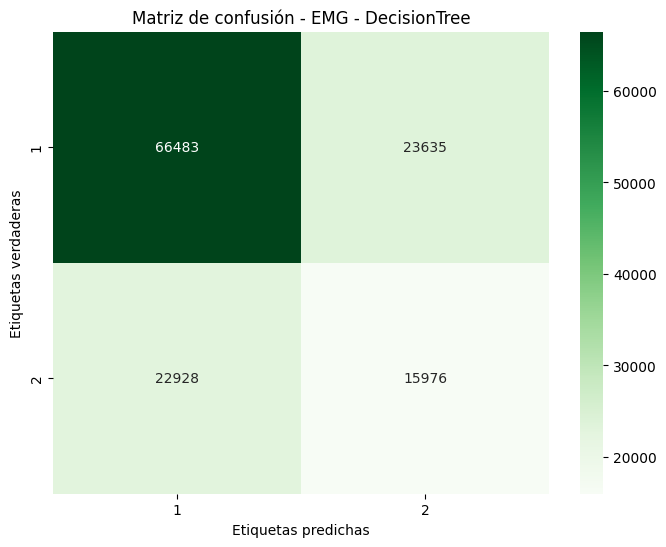

              precision    recall  f1-score   support

           1       0.74      0.74      0.74     90118
           2       0.40      0.41      0.41     38904

    accuracy                           0.64    129022
   macro avg       0.57      0.57      0.57    129022
weighted avg       0.64      0.64      0.64    129022

Training RandomForest model for EMG using LOGO...
[EMG - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EMG - RandomForest] Fold 1/15 (Subject: 2)
[EMG - RandomForest] Fold 2/15 (Subject: 3)
[EMG - RandomForest] Fold 3/15 (Subject: 4)
[EMG - RandomForest] Fold 4/15 (Subject: 5)
[EMG - RandomForest] Fold 5/15 (Subject: 6)
[EMG - RandomForest] Fold 6/15 (Subject: 7)
[EMG - RandomForest] Fold 7/15 (Subject: 8)
[EMG - RandomForest] Fold 8/15 (Subject: 9)
[EMG - RandomForest] Fold 9/15 (Subject: 10)
[EMG - RandomForest] Fold 10/15 (Subject: 11)
[EMG - RandomForest] Fold 11/15 (Subject: 13)
[EMG - RandomForest] F

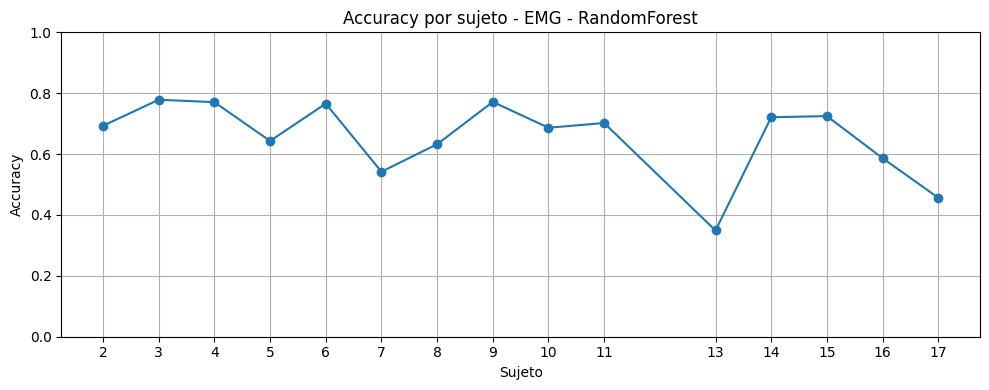

EMG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.653997  EMG - RandomForest
1  Precision  0.620670  EMG - RandomForest
2     Recall  0.653997  EMG - RandomForest
3   F1 Score  0.630976  EMG - RandomForest
[EMG - RandomForest] Best Params: {}
[EMG - RandomForest] Accuracy: 0.6540
EMG - RandomForest - Confusion Matrix
[[74288 15830]
 [28812 10092]]


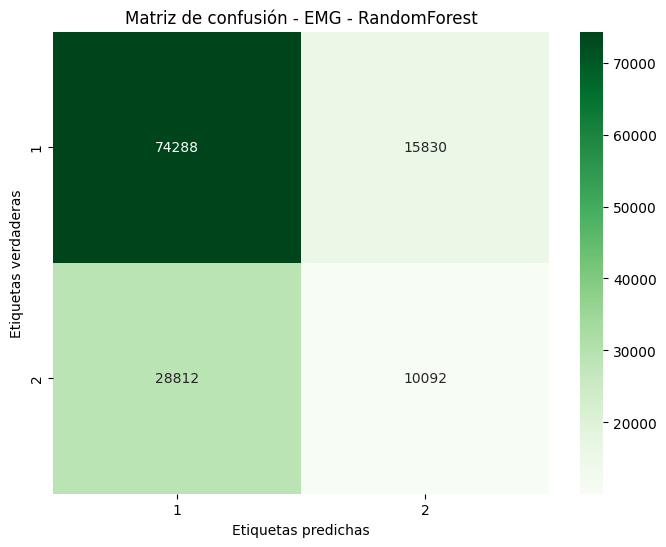

              precision    recall  f1-score   support

           1       0.72      0.82      0.77     90118
           2       0.39      0.26      0.31     38904

    accuracy                           0.65    129022
   macro avg       0.55      0.54      0.54    129022
weighted avg       0.62      0.65      0.63    129022

Training AdaBoost model for EMG using LOGO...
[EMG - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[EMG - AdaBoost] Fold 1/15 (Subject: 2)
[EMG - AdaBoost] Fold 2/15 (Subject: 3)
[EMG - AdaBoost] Fold 3/15 (Subject: 4)
[EMG - AdaBoost] Fold 4/15 (Subject: 5)
[EMG - AdaBoost] Fold 5/15 (Subject: 6)
[EMG - AdaBoost] Fold 6/15 (Subject: 7)
[EMG - AdaBoost] Fold 7/15 (Subject: 8)
[EMG - AdaBoost] Fold 8/15 (Subject: 9)
[EMG - AdaBoost] Fold 9/15 (Subject: 10)
[EMG - AdaBoost] Fold 10/15 (Subject: 11)
[EMG - AdaBoost] Fold 11/15 (Subject: 13)
[EMG - AdaBoost] Fold 12/15 (Subject: 14)
[EMG - AdaBoost] Fold 13/15 (Sub

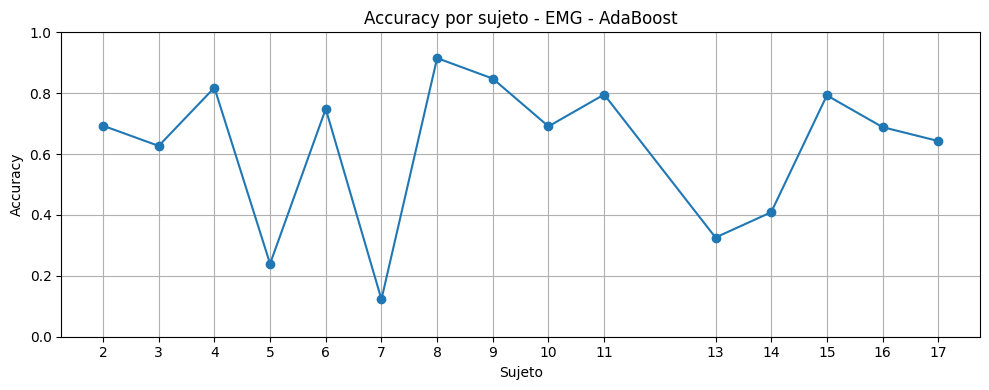

EMG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.623568  EMG - AdaBoost
1  Precision  0.656017  EMG - AdaBoost
2     Recall  0.623568  EMG - AdaBoost
3   F1 Score  0.635054  EMG - AdaBoost
[EMG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.1, 'n_estimators': 100}
[EMG - AdaBoost] Accuracy: 0.6236
EMG - AdaBoost - Confusion Matrix
[[60024 30094]
 [18474 20430]]


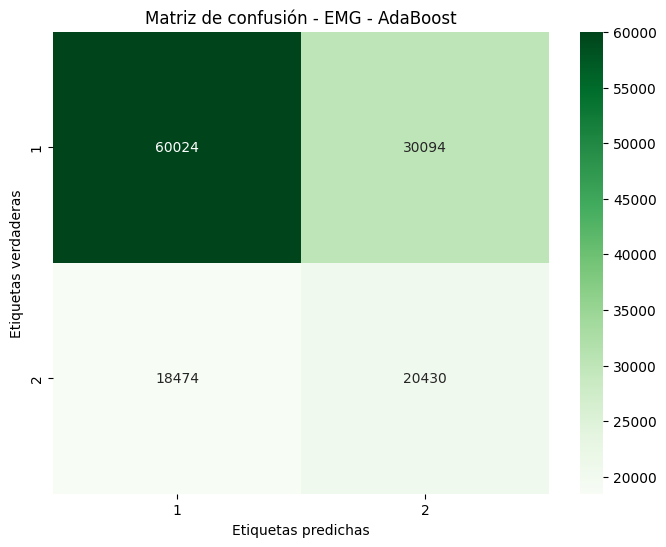

              precision    recall  f1-score   support

           1       0.76      0.67      0.71     90118
           2       0.40      0.53      0.46     38904

    accuracy                           0.62    129022
   macro avg       0.58      0.60      0.58    129022
weighted avg       0.66      0.62      0.64    129022

Training LDA model for EMG using LOGO...
[EMG - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EMG - LDA] Fold 1/15 (Subject: 2)
[EMG - LDA] Fold 2/15 (Subject: 3)
[EMG - LDA] Fold 3/15 (Subject: 4)
[EMG - LDA] Fold 4/15 (Subject: 5)
[EMG - LDA] Fold 5/15 (Subject: 6)
[EMG - LDA] Fold 6/15 (Subject: 7)
[EMG - LDA] Fold 7/15 (Subject: 8)
[EMG - LDA] Fold 8/15 (Subject: 9)
[EMG - LDA] Fold 9/15 (Subject: 10)
[EMG - LDA] Fold 10/15 (Subject: 11)
[EMG - LDA] Fold 11/15 (Subject: 13)
[EMG - LDA] Fold 12/15 (Subject: 14)
[EMG - LDA] Fold 13/15 (Subject: 15)
[EMG - LDA] Fold 14/15 (Subject: 16)
[EMG - LDA] Fold 15/15 (Subj

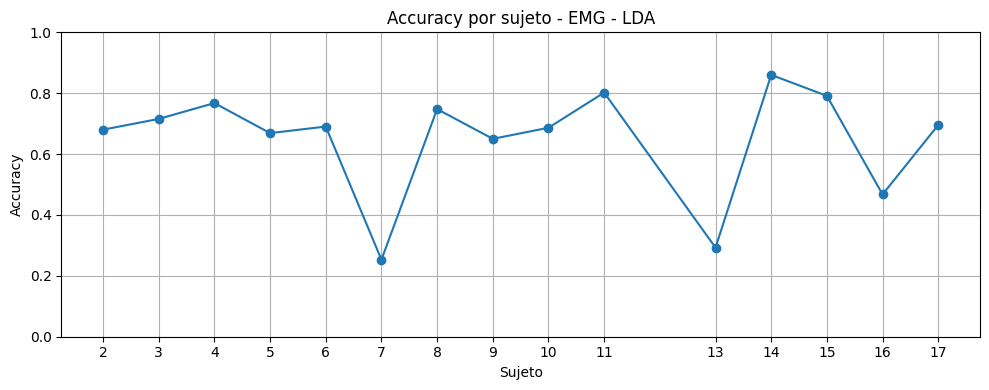

EMG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.651308  EMG - LDA
1  Precision  0.634507  EMG - LDA
2     Recall  0.651308  EMG - LDA
3   F1 Score  0.641273  EMG - LDA
[EMG - LDA] Best Params: {'solver': 'svd'}
[EMG - LDA] Accuracy: 0.6513
EMG - LDA - Confusion Matrix
[[70933 19185]
 [25804 13100]]


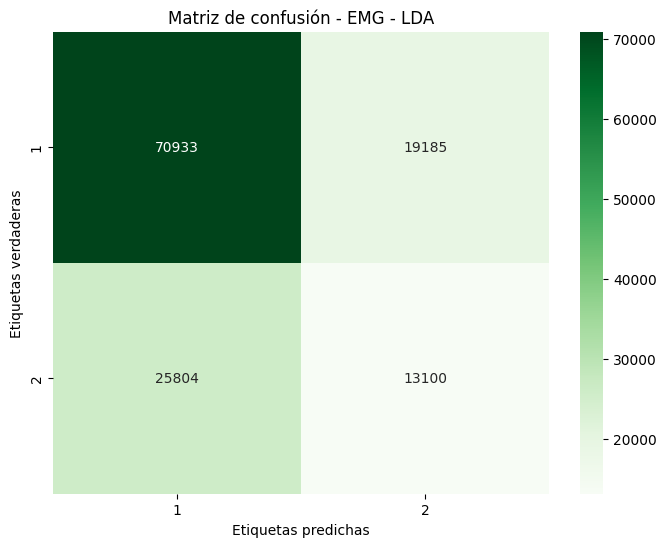

              precision    recall  f1-score   support

           1       0.73      0.79      0.76     90118
           2       0.41      0.34      0.37     38904

    accuracy                           0.65    129022
   macro avg       0.57      0.56      0.56    129022
weighted avg       0.63      0.65      0.64    129022

Training KNN model for EMG using LOGO...
[EMG - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[EMG - KNN] Fold 1/15 (Subject: 2)
[EMG - KNN] Fold 2/15 (Subject: 3)
[EMG - KNN] Fold 3/15 (Subject: 4)
[EMG - KNN] Fold 4/15 (Subject: 5)
[EMG - KNN] Fold 5/15 (Subject: 6)
[EMG - KNN] Fold 6/15 (Subject: 7)
[EMG - KNN] Fold 7/15 (Subject: 8)
[EMG - KNN] Fold 8/15 (Subject: 9)
[EMG - KNN] Fold 9/15 (Subject: 10)
[EMG - KNN] Fold 10/15 (Subject: 11)
[EMG - KNN] Fold 11/15 (Subject: 13)
[EMG - KNN] Fold 12/15 (Subject: 14)
[EMG - KNN] Fold 13/15 (Subject: 15)
[EMG - KNN] Fold 14/15 (Subject: 16)
[EMG - KNN] Fold 15/15 (Subj

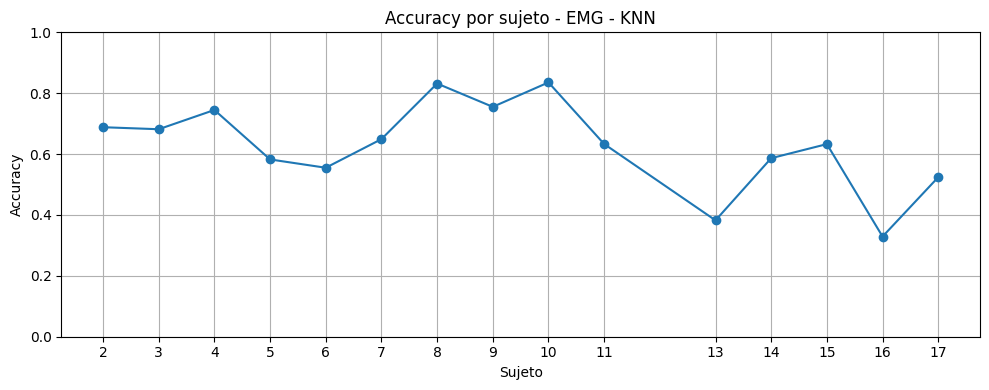

EMG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.626971  EMG - KNN
1  Precision  0.613476  EMG - KNN
2     Recall  0.626971  EMG - KNN
3   F1 Score  0.619402  EMG - KNN
[EMG - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[EMG - KNN] Accuracy: 0.6270
EMG - KNN - Confusion Matrix
[[68495 21623]
 [26506 12398]]


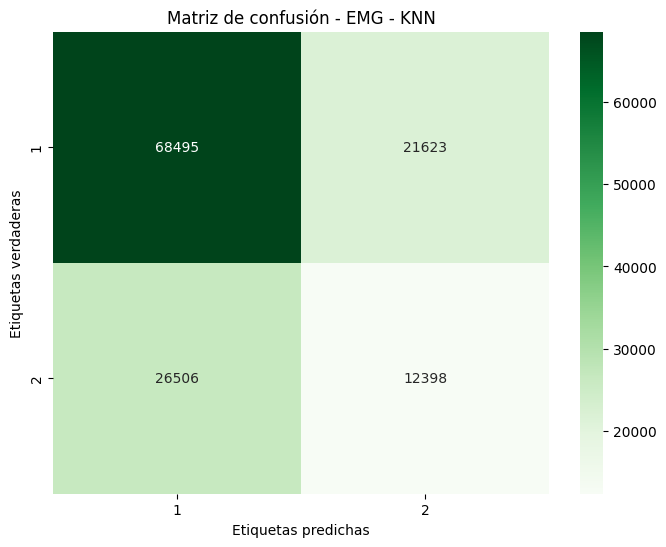

Training by signal:  60%|██████    | 3/5 [1:10:57<49:33, 1486.84s/it]

              precision    recall  f1-score   support

           1       0.72      0.76      0.74     90118
           2       0.36      0.32      0.34     38904

    accuracy                           0.63    129022
   macro avg       0.54      0.54      0.54    129022
weighted avg       0.61      0.63      0.62    129022

Training DecisionTree model for RESP using LOGO...
[RESP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[RESP - DecisionTree] Fold 1/15 (Subject: 2)
[RESP - DecisionTree] Fold 2/15 (Subject: 3)
[RESP - DecisionTree] Fold 3/15 (Subject: 4)
[RESP - DecisionTree] Fold 4/15 (Subject: 5)
[RESP - DecisionTree] Fold 5/15 (Subject: 6)
[RESP - DecisionTree] Fold 6/15 (Subject: 7)
[RESP - DecisionTree] Fold 7/15 (Subject: 8)
[RESP - DecisionTree] Fold 8/15 (Subject: 9)
[RESP - DecisionTree] Fold 9/15 (Subject: 10)
[RESP - DecisionTree] Fold 10/15 (Subject: 11)
[RESP - DecisionTree] Fold 11/15 (Subject: 13)
[RESP - D

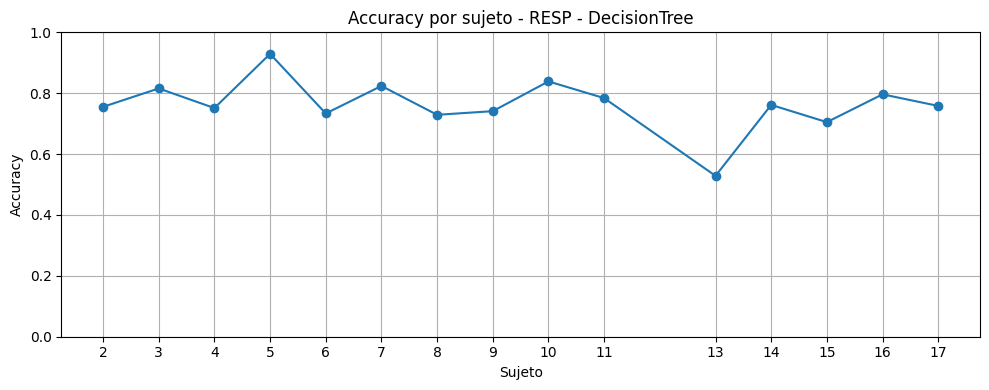

RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.763389  RESP - DecisionTree
1  Precision  0.768937  RESP - DecisionTree
2     Recall  0.763389  RESP - DecisionTree
3   F1 Score  0.765750  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {}
[RESP - DecisionTree] Accuracy: 0.7634
RESP - DecisionTree - Confusion Matrix
[[73374 16744]
 [13784 25120]]


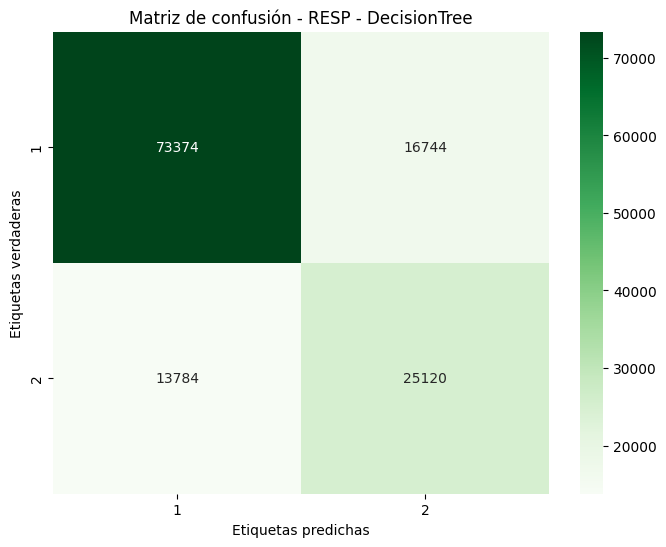

              precision    recall  f1-score   support

           1       0.84      0.81      0.83     90118
           2       0.60      0.65      0.62     38904

    accuracy                           0.76    129022
   macro avg       0.72      0.73      0.72    129022
weighted avg       0.77      0.76      0.77    129022

Training RandomForest model for RESP using LOGO...
[RESP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[RESP - RandomForest] Fold 1/15 (Subject: 2)
[RESP - RandomForest] Fold 2/15 (Subject: 3)
[RESP - RandomForest] Fold 3/15 (Subject: 4)
[RESP - RandomForest] Fold 4/15 (Subject: 5)
[RESP - RandomForest] Fold 5/15 (Subject: 6)
[RESP - RandomForest] Fold 6/15 (Subject: 7)
[RESP - RandomForest] Fold 7/15 (Subject: 8)
[RESP - RandomForest] Fold 8/15 (Subject: 9)
[RESP - RandomForest] Fold 9/15 (Subject: 10)
[RESP - RandomForest] Fold 10/15 (Subject: 11)
[RESP - RandomForest] Fold 11/15 (Subject: 13)
[RESP - R

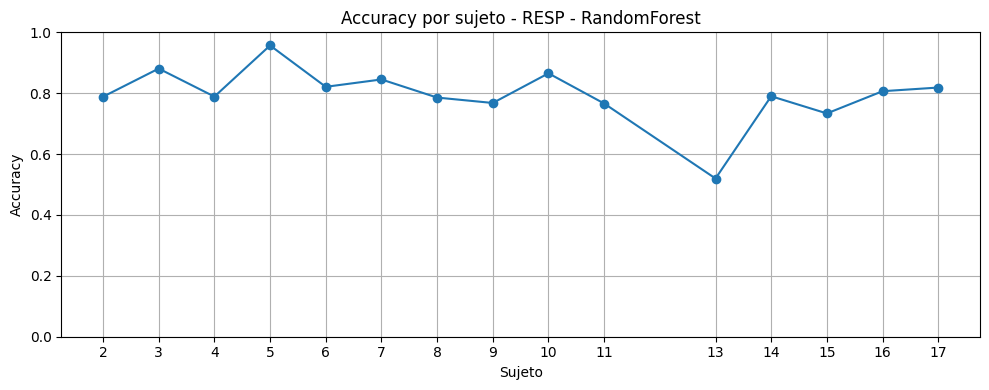

RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.795577  RESP - RandomForest
1  Precision  0.802745  RESP - RandomForest
2     Recall  0.795577  RESP - RandomForest
3   F1 Score  0.798321  RESP - RandomForest
[RESP - RandomForest] Best Params: {}
[RESP - RandomForest] Accuracy: 0.7956
RESP - RandomForest - Confusion Matrix
[[74875 15243]
 [11132 27772]]


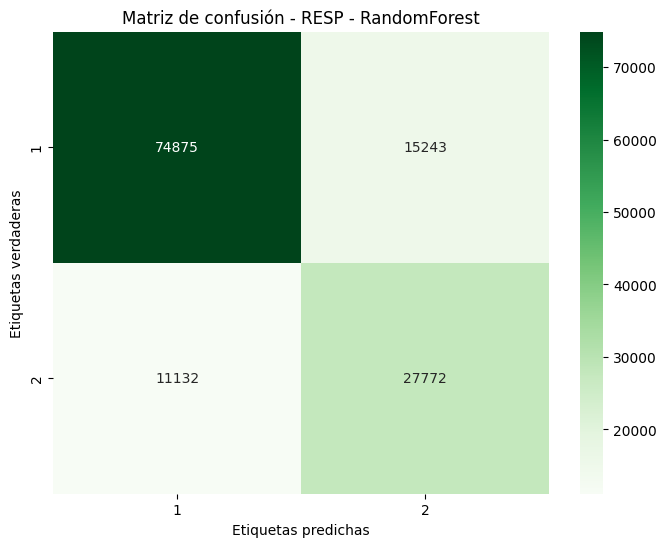

              precision    recall  f1-score   support

           1       0.87      0.83      0.85     90118
           2       0.65      0.71      0.68     38904

    accuracy                           0.80    129022
   macro avg       0.76      0.77      0.76    129022
weighted avg       0.80      0.80      0.80    129022

Training AdaBoost model for RESP using LOGO...
[RESP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[RESP - AdaBoost] Fold 1/15 (Subject: 2)
[RESP - AdaBoost] Fold 2/15 (Subject: 3)
[RESP - AdaBoost] Fold 3/15 (Subject: 4)
[RESP - AdaBoost] Fold 4/15 (Subject: 5)
[RESP - AdaBoost] Fold 5/15 (Subject: 6)
[RESP - AdaBoost] Fold 6/15 (Subject: 7)
[RESP - AdaBoost] Fold 7/15 (Subject: 8)
[RESP - AdaBoost] Fold 8/15 (Subject: 9)
[RESP - AdaBoost] Fold 9/15 (Subject: 10)
[RESP - AdaBoost] Fold 10/15 (Subject: 11)
[RESP - AdaBoost] Fold 11/15 (Subject: 13)
[RESP - AdaBoost] Fold 12/15 (Subject: 14)
[RESP - AdaBoost] 

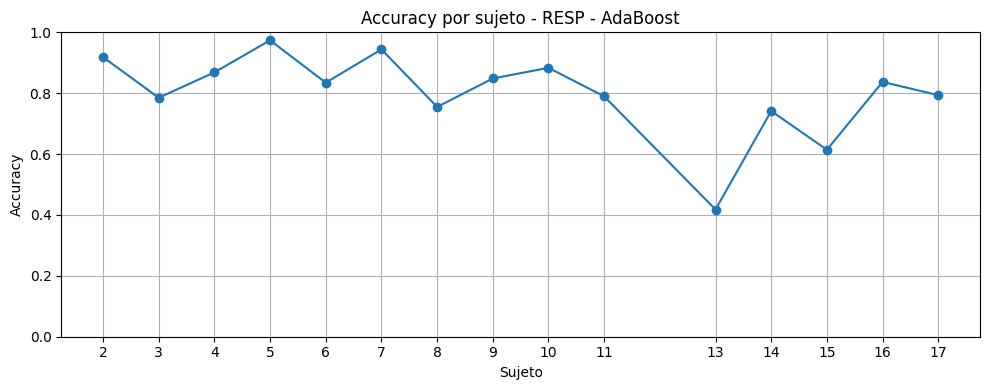

RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.799732  RESP - AdaBoost
1  Precision  0.851789  RESP - AdaBoost
2     Recall  0.799732  RESP - AdaBoost
3   F1 Score  0.807656  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.01, 'n_estimators': 100}
[RESP - AdaBoost] Accuracy: 0.7997
RESP - AdaBoost - Confusion Matrix
[[67426 22692]
 [ 3147 35757]]


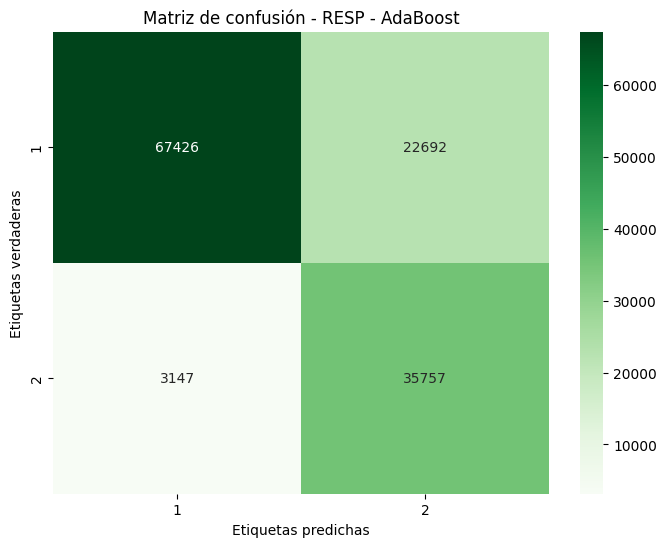

              precision    recall  f1-score   support

           1       0.96      0.75      0.84     90118
           2       0.61      0.92      0.73     38904

    accuracy                           0.80    129022
   macro avg       0.78      0.83      0.79    129022
weighted avg       0.85      0.80      0.81    129022

Training LDA model for RESP using LOGO...
[RESP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[RESP - LDA] Fold 1/15 (Subject: 2)
[RESP - LDA] Fold 2/15 (Subject: 3)
[RESP - LDA] Fold 3/15 (Subject: 4)
[RESP - LDA] Fold 4/15 (Subject: 5)
[RESP - LDA] Fold 5/15 (Subject: 6)
[RESP - LDA] Fold 6/15 (Subject: 7)
[RESP - LDA] Fold 7/15 (Subject: 8)
[RESP - LDA] Fold 8/15 (Subject: 9)
[RESP - LDA] Fold 9/15 (Subject: 10)
[RESP - LDA] Fold 10/15 (Subject: 11)
[RESP - LDA] Fold 11/15 (Subject: 13)
[RESP - LDA] Fold 12/15 (Subject: 14)
[RESP - LDA] Fold 13/15 (Subject: 15)
[RESP - LDA] Fold 14/15 (Subject: 16)
[RESP - LDA]

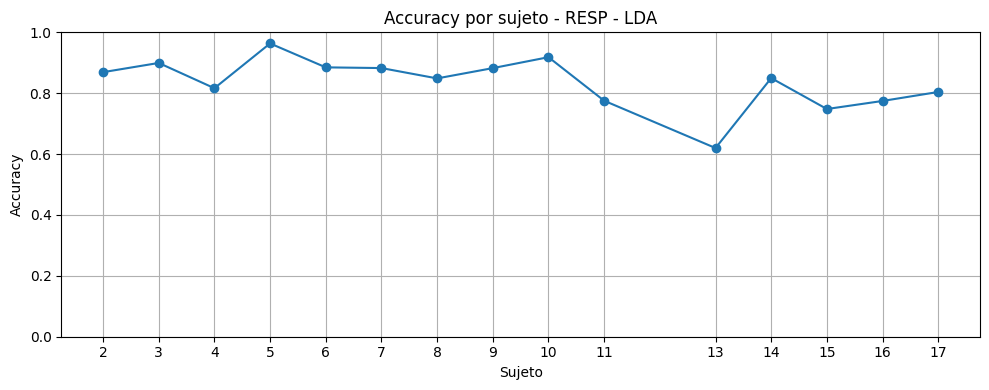

RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.835493  RESP - LDA
1  Precision  0.832119  RESP - LDA
2     Recall  0.835493  RESP - LDA
3   F1 Score  0.832984  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.8355
RESP - LDA - Confusion Matrix
[[81395  8723]
 [12502 26402]]


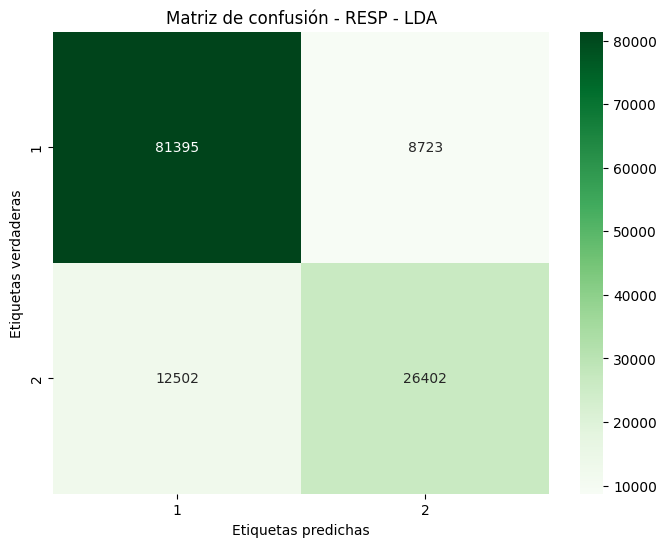

              precision    recall  f1-score   support

           1       0.87      0.90      0.88     90118
           2       0.75      0.68      0.71     38904

    accuracy                           0.84    129022
   macro avg       0.81      0.79      0.80    129022
weighted avg       0.83      0.84      0.83    129022

Training KNN model for RESP using LOGO...
[RESP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[RESP - KNN] Fold 1/15 (Subject: 2)
[RESP - KNN] Fold 2/15 (Subject: 3)
[RESP - KNN] Fold 3/15 (Subject: 4)
[RESP - KNN] Fold 4/15 (Subject: 5)
[RESP - KNN] Fold 5/15 (Subject: 6)
[RESP - KNN] Fold 6/15 (Subject: 7)
[RESP - KNN] Fold 7/15 (Subject: 8)
[RESP - KNN] Fold 8/15 (Subject: 9)
[RESP - KNN] Fold 9/15 (Subject: 10)
[RESP - KNN] Fold 10/15 (Subject: 11)
[RESP - KNN] Fold 11/15 (Subject: 13)
[RESP - KNN] Fold 12/15 (Subject: 14)
[RESP - KNN] Fold 13/15 (Subject: 15)
[RESP - KNN] Fold 14/15 (Subject: 16)
[RESP - KNN]

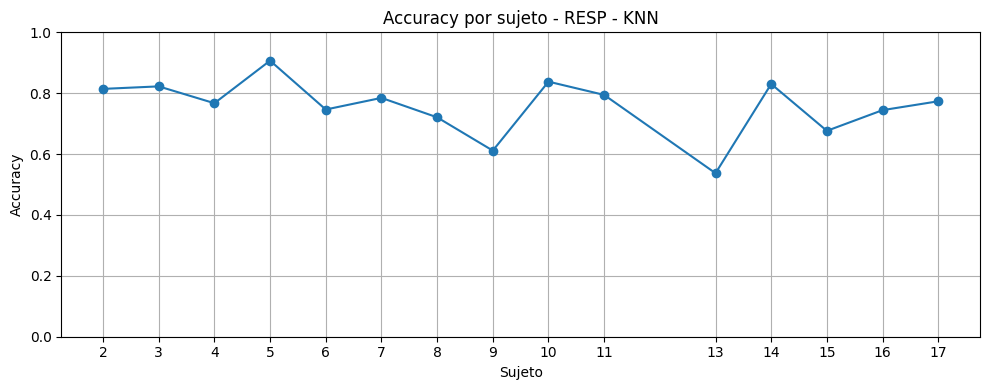

RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.757770  RESP - KNN
1  Precision  0.760035  RESP - KNN
2     Recall  0.757770  RESP - KNN
3   F1 Score  0.758830  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[RESP - KNN] Accuracy: 0.7578
RESP - KNN - Confusion Matrix
[[73872 16246]
 [15007 23897]]


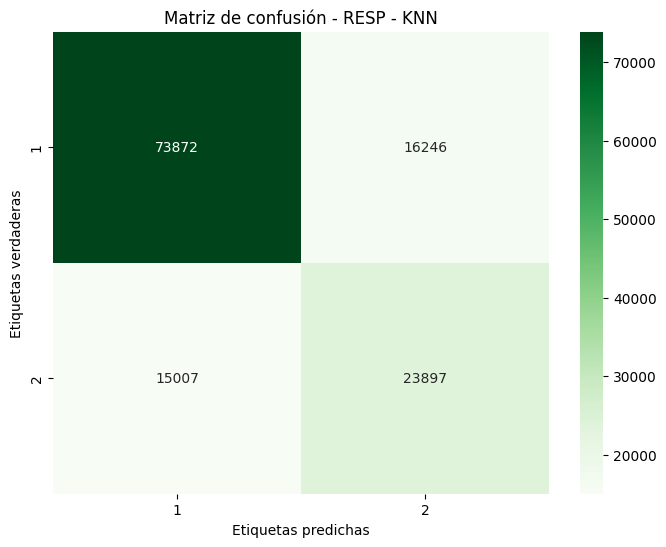

Training by signal:  80%|████████  | 4/5 [1:25:28<20:43, 1243.63s/it]

              precision    recall  f1-score   support

           1       0.83      0.82      0.83     90118
           2       0.60      0.61      0.60     38904

    accuracy                           0.76    129022
   macro avg       0.71      0.72      0.72    129022
weighted avg       0.76      0.76      0.76    129022

Training DecisionTree model for TEMP using LOGO...
[TEMP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[TEMP - DecisionTree] Fold 1/15 (Subject: 2)
[TEMP - DecisionTree] Fold 2/15 (Subject: 3)
[TEMP - DecisionTree] Fold 3/15 (Subject: 4)
[TEMP - DecisionTree] Fold 4/15 (Subject: 5)
[TEMP - DecisionTree] Fold 5/15 (Subject: 6)
[TEMP - DecisionTree] Fold 6/15 (Subject: 7)
[TEMP - DecisionTree] Fold 7/15 (Subject: 8)
[TEMP - DecisionTree] Fold 8/15 (Subject: 9)
[TEMP - DecisionTree] Fold 9/15 (Subject: 10)
[TEMP - DecisionTree] Fold 10/15 (Subject: 11)
[TEMP - DecisionTree] Fold 11/15 (Subject: 13)
[TEMP - D

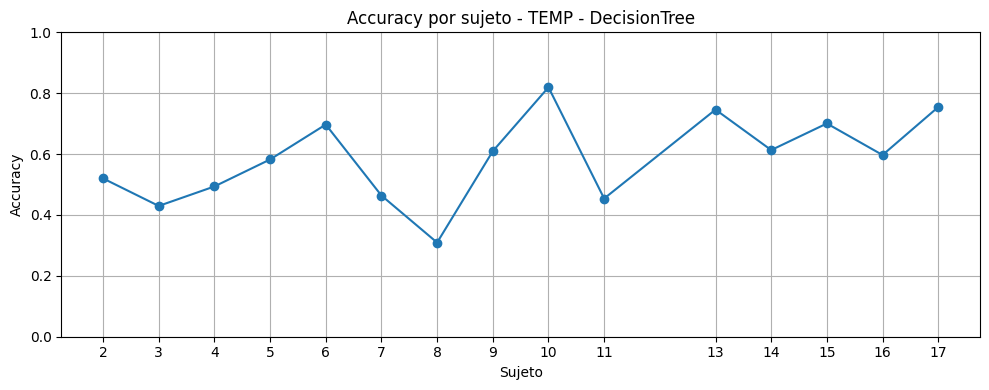

TEMP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.587559  TEMP - DecisionTree
1  Precision  0.595774  TEMP - DecisionTree
2     Recall  0.587559  TEMP - DecisionTree
3   F1 Score  0.591426  TEMP - DecisionTree
[TEMP - DecisionTree] Best Params: {}
[TEMP - DecisionTree] Accuracy: 0.5876
TEMP - DecisionTree - Confusion Matrix
[[62127 27991]
 [25223 13681]]


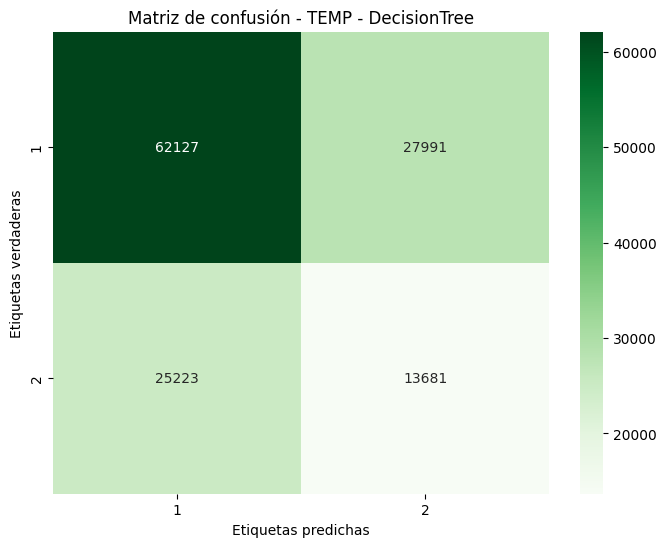

              precision    recall  f1-score   support

           1       0.71      0.69      0.70     90118
           2       0.33      0.35      0.34     38904

    accuracy                           0.59    129022
   macro avg       0.52      0.52      0.52    129022
weighted avg       0.60      0.59      0.59    129022

Training RandomForest model for TEMP using LOGO...
[TEMP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[TEMP - RandomForest] Fold 1/15 (Subject: 2)
[TEMP - RandomForest] Fold 2/15 (Subject: 3)
[TEMP - RandomForest] Fold 3/15 (Subject: 4)
[TEMP - RandomForest] Fold 4/15 (Subject: 5)
[TEMP - RandomForest] Fold 5/15 (Subject: 6)
[TEMP - RandomForest] Fold 6/15 (Subject: 7)
[TEMP - RandomForest] Fold 7/15 (Subject: 8)
[TEMP - RandomForest] Fold 8/15 (Subject: 9)
[TEMP - RandomForest] Fold 9/15 (Subject: 10)
[TEMP - RandomForest] Fold 10/15 (Subject: 11)
[TEMP - RandomForest] Fold 11/15 (Subject: 13)
[TEMP - R

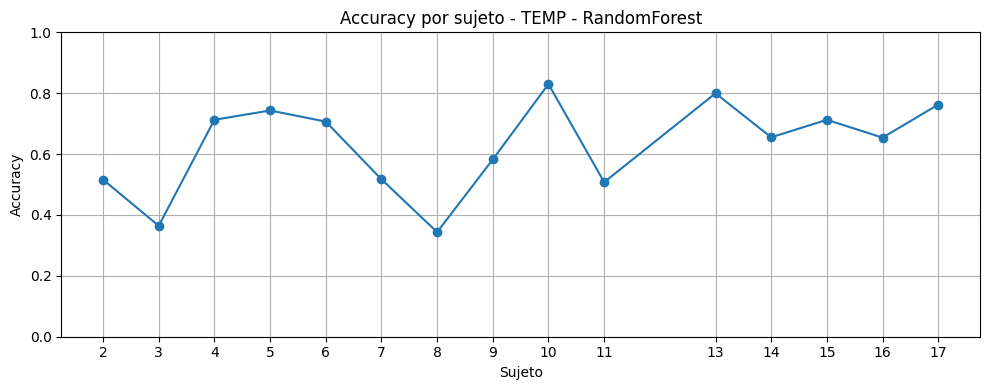

TEMP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.628745  TEMP - RandomForest
1  Precision  0.619227  TEMP - RandomForest
2     Recall  0.628745  TEMP - RandomForest
3   F1 Score  0.623564  TEMP - RandomForest
[TEMP - RandomForest] Best Params: {}
[TEMP - RandomForest] Accuracy: 0.6287
TEMP - RandomForest - Confusion Matrix
[[67910 22208]
 [25692 13212]]


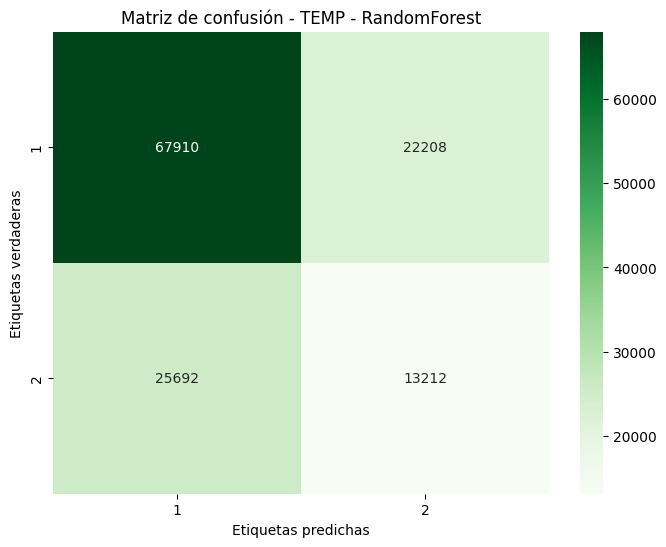

              precision    recall  f1-score   support

           1       0.73      0.75      0.74     90118
           2       0.37      0.34      0.36     38904

    accuracy                           0.63    129022
   macro avg       0.55      0.55      0.55    129022
weighted avg       0.62      0.63      0.62    129022

Training AdaBoost model for TEMP using LOGO...
[TEMP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[TEMP - AdaBoost] Fold 1/15 (Subject: 2)
[TEMP - AdaBoost] Fold 2/15 (Subject: 3)
[TEMP - AdaBoost] Fold 3/15 (Subject: 4)
[TEMP - AdaBoost] Fold 4/15 (Subject: 5)
[TEMP - AdaBoost] Fold 5/15 (Subject: 6)
[TEMP - AdaBoost] Fold 6/15 (Subject: 7)
[TEMP - AdaBoost] Fold 7/15 (Subject: 8)
[TEMP - AdaBoost] Fold 8/15 (Subject: 9)
[TEMP - AdaBoost] Fold 9/15 (Subject: 10)
[TEMP - AdaBoost] Fold 10/15 (Subject: 11)
[TEMP - AdaBoost] Fold 11/15 (Subject: 13)
[TEMP - AdaBoost] Fold 12/15 (Subject: 14)
[TEMP - AdaBoost] 

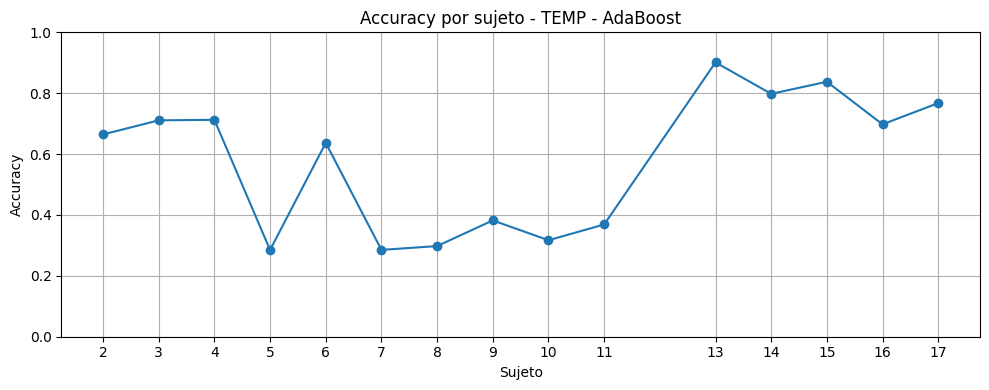

TEMP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.577243  TEMP - AdaBoost
1  Precision  0.662145  TEMP - AdaBoost
2     Recall  0.577243  TEMP - AdaBoost
3   F1 Score  0.594412  TEMP - AdaBoost
[TEMP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.01, 'n_estimators': 100}
[TEMP - AdaBoost] Accuracy: 0.5772
TEMP - AdaBoost - Confusion Matrix
[[49196 40922]
 [13623 25281]]


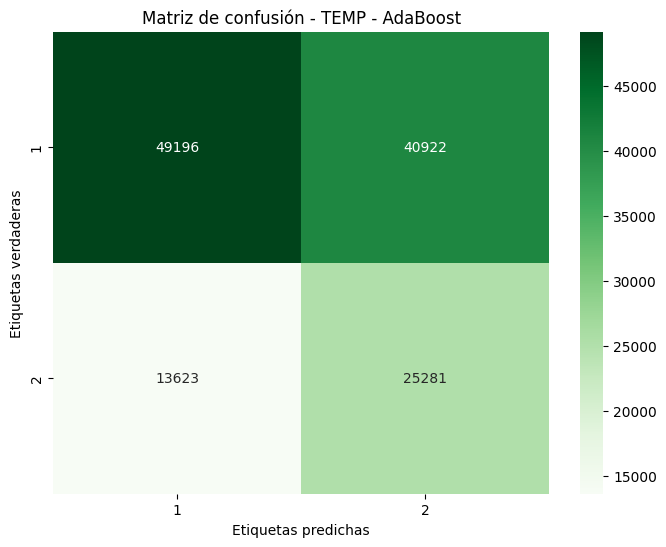

              precision    recall  f1-score   support

           1       0.78      0.55      0.64     90118
           2       0.38      0.65      0.48     38904

    accuracy                           0.58    129022
   macro avg       0.58      0.60      0.56    129022
weighted avg       0.66      0.58      0.59    129022

Training LDA model for TEMP using LOGO...
[TEMP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[TEMP - LDA] Fold 1/15 (Subject: 2)
[TEMP - LDA] Fold 2/15 (Subject: 3)
[TEMP - LDA] Fold 3/15 (Subject: 4)
[TEMP - LDA] Fold 4/15 (Subject: 5)
[TEMP - LDA] Fold 5/15 (Subject: 6)
[TEMP - LDA] Fold 6/15 (Subject: 7)
[TEMP - LDA] Fold 7/15 (Subject: 8)
[TEMP - LDA] Fold 8/15 (Subject: 9)
[TEMP - LDA] Fold 9/15 (Subject: 10)
[TEMP - LDA] Fold 10/15 (Subject: 11)
[TEMP - LDA] Fold 11/15 (Subject: 13)
[TEMP - LDA] Fold 12/15 (Subject: 14)
[TEMP - LDA] Fold 13/15 (Subject: 15)
[TEMP - LDA] Fold 14/15 (Subject: 16)
[TEMP - LDA]

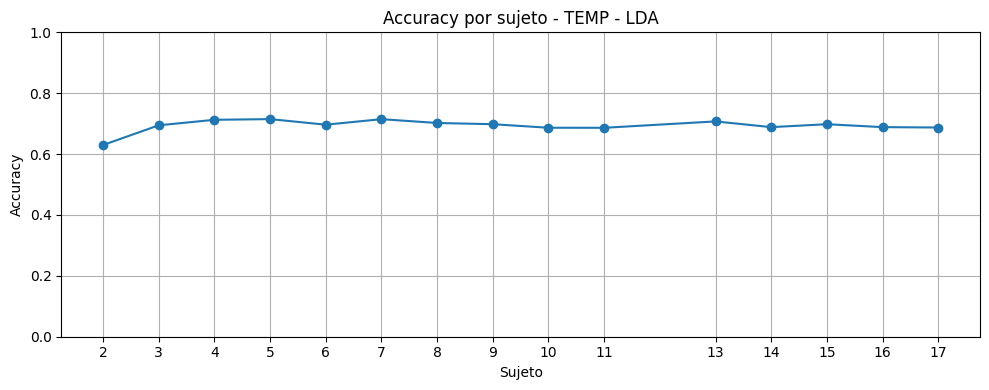

TEMP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.693882  TEMP - LDA
1  Precision  0.489405  TEMP - LDA
2     Recall  0.693882  TEMP - LDA
3   F1 Score  0.572313  TEMP - LDA
[TEMP - LDA] Best Params: {'solver': 'svd'}
[TEMP - LDA] Accuracy: 0.6939
TEMP - LDA - Confusion Matrix
[[89521   597]
 [38899     5]]


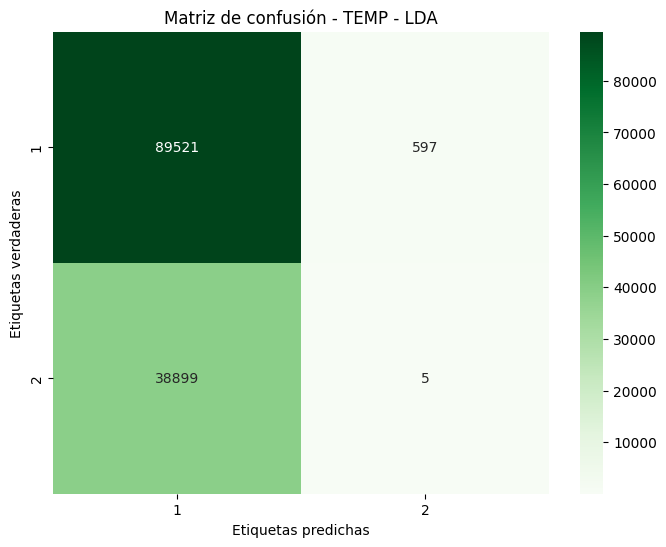

              precision    recall  f1-score   support

           1       0.70      0.99      0.82     90118
           2       0.01      0.00      0.00     38904

    accuracy                           0.69    129022
   macro avg       0.35      0.50      0.41    129022
weighted avg       0.49      0.69      0.57    129022

Training KNN model for TEMP using LOGO...
[TEMP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[TEMP - KNN] Fold 1/15 (Subject: 2)
[TEMP - KNN] Fold 2/15 (Subject: 3)
[TEMP - KNN] Fold 3/15 (Subject: 4)
[TEMP - KNN] Fold 4/15 (Subject: 5)
[TEMP - KNN] Fold 5/15 (Subject: 6)
[TEMP - KNN] Fold 6/15 (Subject: 7)
[TEMP - KNN] Fold 7/15 (Subject: 8)
[TEMP - KNN] Fold 8/15 (Subject: 9)
[TEMP - KNN] Fold 9/15 (Subject: 10)
[TEMP - KNN] Fold 10/15 (Subject: 11)
[TEMP - KNN] Fold 11/15 (Subject: 13)
[TEMP - KNN] Fold 12/15 (Subject: 14)
[TEMP - KNN] Fold 13/15 (Subject: 15)
[TEMP - KNN] Fold 14/15 (Subject: 16)
[TEMP - KNN]

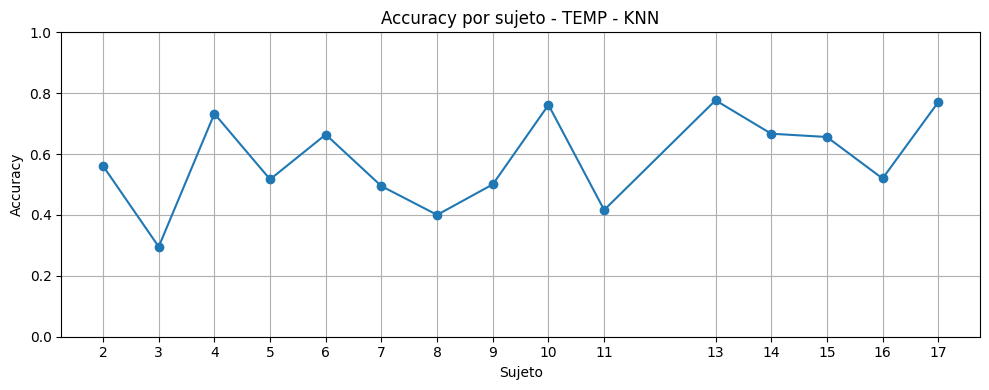

TEMP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.583528  TEMP - KNN
1  Precision  0.594380  TEMP - KNN
2     Recall  0.583528  TEMP - KNN
3   F1 Score  0.588543  TEMP - KNN
[TEMP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[TEMP - KNN] Accuracy: 0.5835
TEMP - KNN - Confusion Matrix
[[61431 28687]
 [25047 13857]]


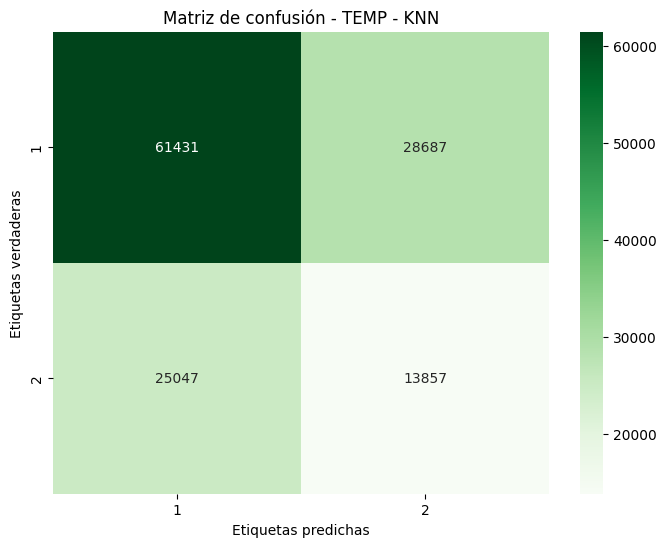

Training by signal: 100%|██████████| 5/5 [1:35:46<00:00, 1149.33s/it]


              precision    recall  f1-score   support

           1       0.71      0.68      0.70     90118
           2       0.33      0.36      0.34     38904

    accuracy                           0.58    129022
   macro avg       0.52      0.52      0.52    129022
weighted avg       0.59      0.58      0.59    129022



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOGO...
[ALL - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ALL - DecisionTree] Fold 1/15 (Subject: 2)
[ALL - DecisionTree] Fold 2/15 (Subject: 3)
[ALL - DecisionTree] Fold 3/15 (Subject: 4)
[ALL - DecisionTree] Fold 4/15 (Subject: 5)
[ALL - DecisionTree] Fold 5/15 (Subject: 6)
[ALL - DecisionTree] Fold 6/15 (Subject: 7)
[ALL - DecisionTree] Fold 7/15 (Subject: 8)
[ALL - DecisionTree] Fold 8/15 (Subject: 9)
[ALL - DecisionTree] Fold 9/15 (Subject: 10)
[ALL - DecisionTree] Fold 10/15 (Subject: 11)
[ALL - DecisionTree] Fold 11/15 (Subject: 13)
[ALL - DecisionTree] Fold 12/15 (Subject: 14)
[ALL - DecisionTree] Fold 13/15 (Subject: 15)
[ALL - DecisionTree] Fold 14/15 (Subject: 16)
[ALL - DecisionTree] Fold 15/15 (Subject: 17)


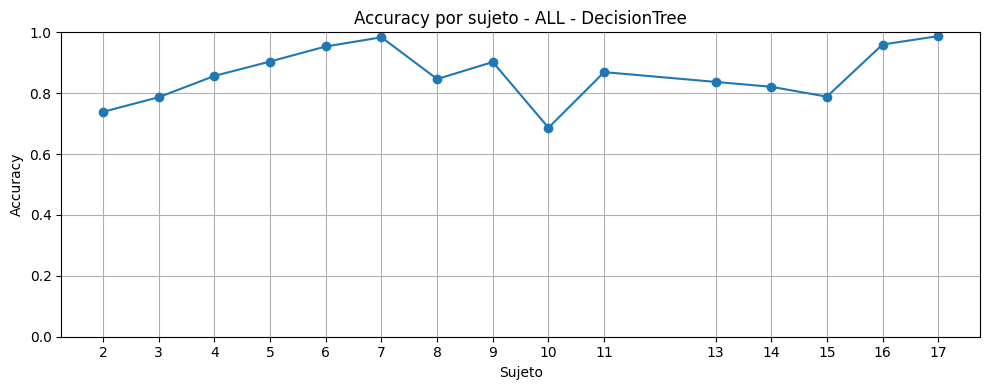

ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.861791  ALL - DecisionTree
1  Precision  0.859672  ALL - DecisionTree
2     Recall  0.861791  ALL - DecisionTree
3   F1 Score  0.860256  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {}
[ALL - DecisionTree] Accuracy: 0.8618
ALL - DecisionTree - Confusion Matrix
[[82613  7505]
 [10327 28577]]


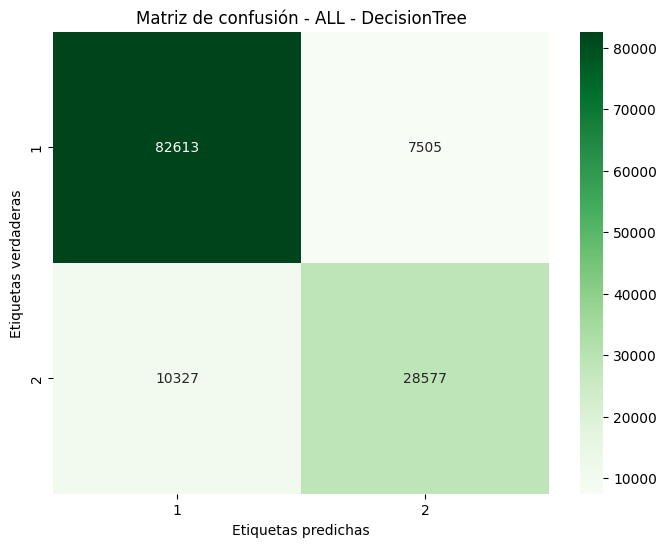

Training with ALL signals:  20%|██        | 1/5 [02:08<08:33, 128.47s/it]

              precision    recall  f1-score   support

           1       0.89      0.92      0.90     90118
           2       0.79      0.73      0.76     38904

    accuracy                           0.86    129022
   macro avg       0.84      0.83      0.83    129022
weighted avg       0.86      0.86      0.86    129022

Training RandomForest model for ALL signals using LOGO...
[ALL - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ALL - RandomForest] Fold 1/15 (Subject: 2)
[ALL - RandomForest] Fold 2/15 (Subject: 3)
[ALL - RandomForest] Fold 3/15 (Subject: 4)
[ALL - RandomForest] Fold 4/15 (Subject: 5)
[ALL - RandomForest] Fold 5/15 (Subject: 6)
[ALL - RandomForest] Fold 6/15 (Subject: 7)
[ALL - RandomForest] Fold 7/15 (Subject: 8)
[ALL - RandomForest] Fold 8/15 (Subject: 9)
[ALL - RandomForest] Fold 9/15 (Subject: 10)
[ALL - RandomForest] Fold 10/15 (Subject: 11)
[ALL - RandomForest] Fold 11/15 (Subject: 13)
[ALL - RandomF

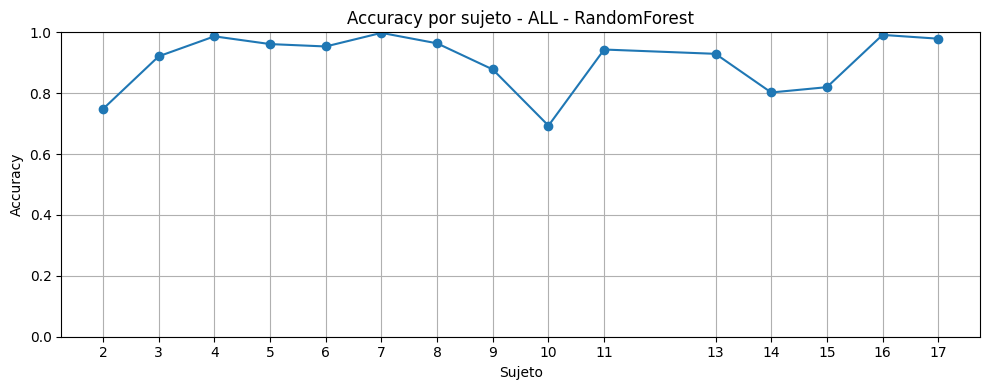

ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.904636  ALL - RandomForest
1  Precision  0.905205  ALL - RandomForest
2     Recall  0.904636  ALL - RandomForest
3   F1 Score  0.901858  ALL - RandomForest
[ALL - RandomForest] Best Params: {}
[ALL - RandomForest] Accuracy: 0.9046
ALL - RandomForest - Confusion Matrix
[[87311  2807]
 [ 9497 29407]]


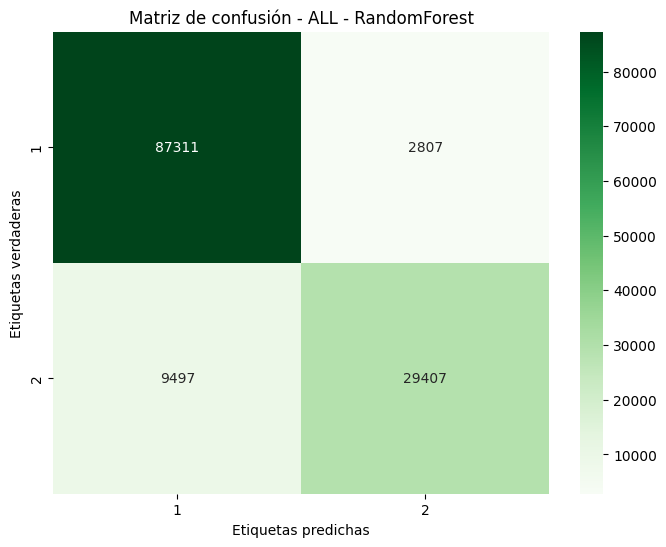

Training with ALL signals:  40%|████      | 2/5 [19:31<33:18, 666.19s/it]

              precision    recall  f1-score   support

           1       0.90      0.97      0.93     90118
           2       0.91      0.76      0.83     38904

    accuracy                           0.90    129022
   macro avg       0.91      0.86      0.88    129022
weighted avg       0.91      0.90      0.90    129022

Training AdaBoost model for ALL signals using LOGO...
[ALL - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[ALL - AdaBoost] Fold 1/15 (Subject: 2)
[ALL - AdaBoost] Fold 2/15 (Subject: 3)
[ALL - AdaBoost] Fold 3/15 (Subject: 4)
[ALL - AdaBoost] Fold 4/15 (Subject: 5)
[ALL - AdaBoost] Fold 5/15 (Subject: 6)
[ALL - AdaBoost] Fold 6/15 (Subject: 7)
[ALL - AdaBoost] Fold 7/15 (Subject: 8)
[ALL - AdaBoost] Fold 8/15 (Subject: 9)
[ALL - AdaBoost] Fold 9/15 (Subject: 10)
[ALL - AdaBoost] Fold 10/15 (Subject: 11)
[ALL - AdaBoost] Fold 11/15 (Subject: 13)
[ALL - AdaBoost] Fold 12/15 (Subject: 14)
[ALL - AdaBoost] Fold 13

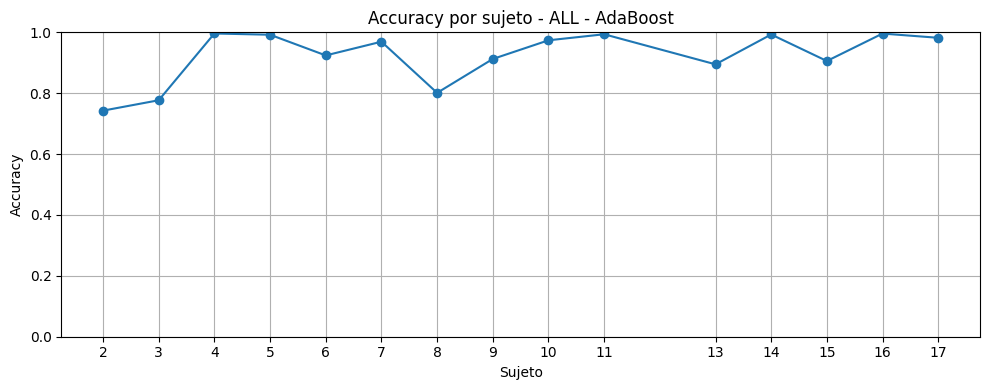

ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.924563  ALL - AdaBoost
1  Precision  0.924940  ALL - AdaBoost
2     Recall  0.924563  ALL - AdaBoost
3   F1 Score  0.924728  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 1, 'n_estimators': 100}
[ALL - AdaBoost] Accuracy: 0.9246
ALL - AdaBoost - Confusion Matrix
[[84947  5171]
 [ 4562 34342]]


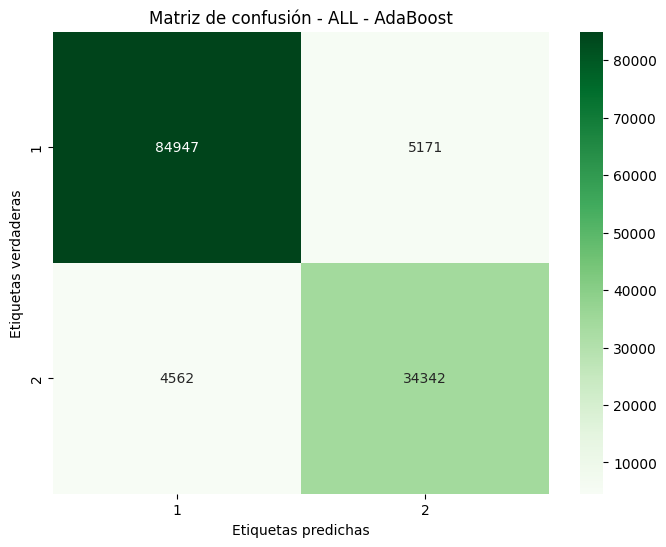

Training with ALL signals:  60%|██████    | 3/5 [1:01:08<50:04, 1502.20s/it]

              precision    recall  f1-score   support

           1       0.95      0.94      0.95     90118
           2       0.87      0.88      0.88     38904

    accuracy                           0.92    129022
   macro avg       0.91      0.91      0.91    129022
weighted avg       0.92      0.92      0.92    129022

Training LDA model for ALL signals using LOGO...
[ALL - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ALL - LDA] Fold 1/15 (Subject: 2)
[ALL - LDA] Fold 2/15 (Subject: 3)
[ALL - LDA] Fold 3/15 (Subject: 4)
[ALL - LDA] Fold 4/15 (Subject: 5)
[ALL - LDA] Fold 5/15 (Subject: 6)
[ALL - LDA] Fold 6/15 (Subject: 7)
[ALL - LDA] Fold 7/15 (Subject: 8)
[ALL - LDA] Fold 8/15 (Subject: 9)
[ALL - LDA] Fold 9/15 (Subject: 10)
[ALL - LDA] Fold 10/15 (Subject: 11)
[ALL - LDA] Fold 11/15 (Subject: 13)
[ALL - LDA] Fold 12/15 (Subject: 14)
[ALL - LDA] Fold 13/15 (Subject: 15)
[ALL - LDA] Fold 14/15 (Subject: 16)
[ALL - LDA] Fold 15/

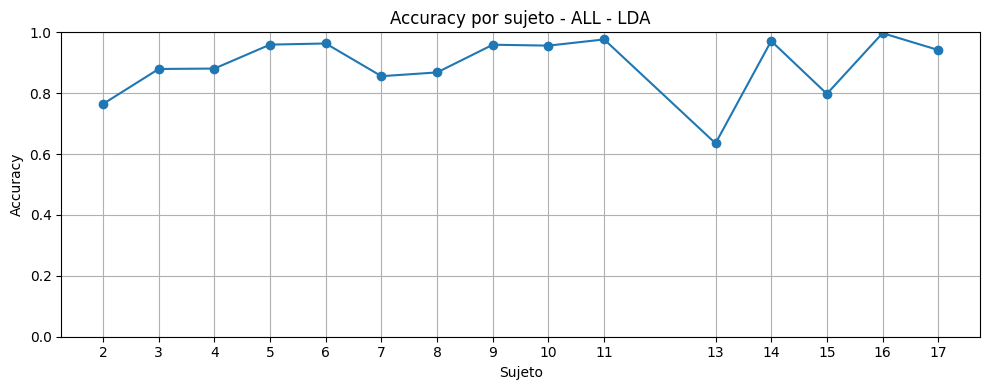

ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.894475  ALL - LDA
1  Precision  0.893388  ALL - LDA
2     Recall  0.894475  ALL - LDA
3   F1 Score  0.893708  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.8945
ALL - LDA - Confusion Matrix
[[84257  5861]
 [ 7754 31150]]


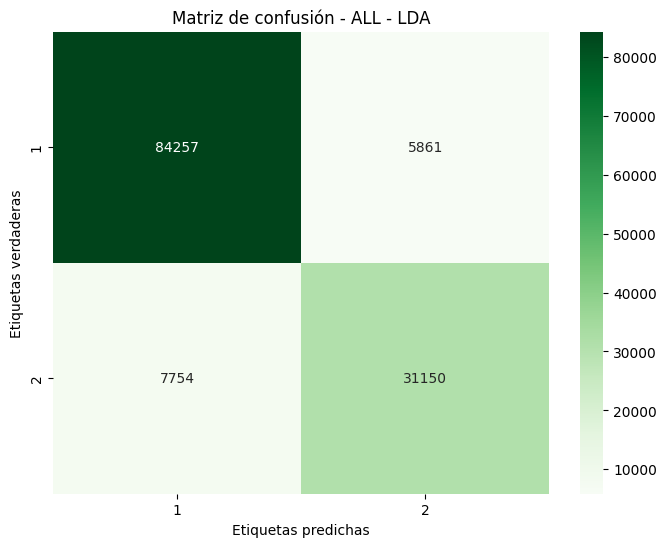

Training with ALL signals:  80%|████████  | 4/5 [1:01:29<15:17, 917.46s/it] 

              precision    recall  f1-score   support

           1       0.92      0.93      0.93     90118
           2       0.84      0.80      0.82     38904

    accuracy                           0.89    129022
   macro avg       0.88      0.87      0.87    129022
weighted avg       0.89      0.89      0.89    129022

Training KNN model for ALL signals using LOGO...
[ALL - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[ALL - KNN] Fold 1/15 (Subject: 2)
[ALL - KNN] Fold 2/15 (Subject: 3)
[ALL - KNN] Fold 3/15 (Subject: 4)
[ALL - KNN] Fold 4/15 (Subject: 5)
[ALL - KNN] Fold 5/15 (Subject: 6)
[ALL - KNN] Fold 6/15 (Subject: 7)
[ALL - KNN] Fold 7/15 (Subject: 8)
[ALL - KNN] Fold 8/15 (Subject: 9)
[ALL - KNN] Fold 9/15 (Subject: 10)
[ALL - KNN] Fold 10/15 (Subject: 11)
[ALL - KNN] Fold 11/15 (Subject: 13)
[ALL - KNN] Fold 12/15 (Subject: 14)
[ALL - KNN] Fold 13/15 (Subject: 15)
[ALL - KNN] Fold 14/15 (Subject: 16)
[ALL - KNN] Fold 15/

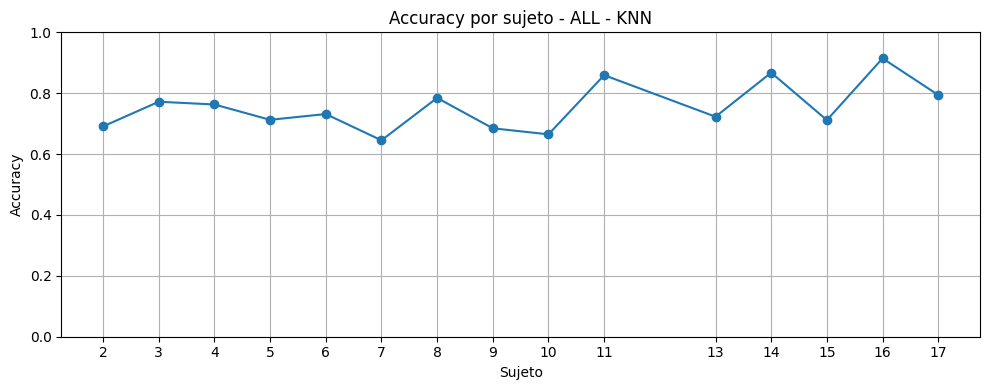

ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.754848  ALL - KNN
1  Precision  0.747258  ALL - KNN
2     Recall  0.754848  ALL - KNN
3   F1 Score  0.749886  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.7548
ALL - KNN - Confusion Matrix
[[76739 13379]
 [18251 20653]]


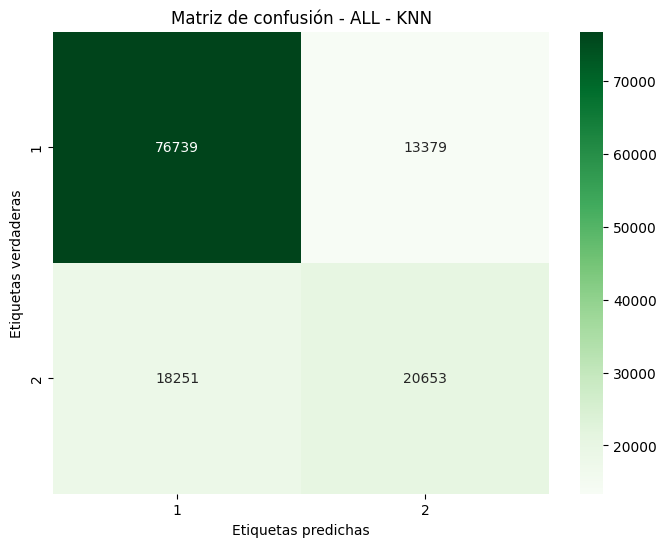

Training with ALL signals: 100%|██████████| 5/5 [1:02:03<00:00, 744.79s/it]

              precision    recall  f1-score   support

           1       0.81      0.85      0.83     90118
           2       0.61      0.53      0.57     38904

    accuracy                           0.75    129022
   macro avg       0.71      0.69      0.70    129022
weighted avg       0.75      0.75      0.75    129022


Final Comparison:
ECG_BVP - DecisionTree:
     Métrica     Valor                   Etapa
0   Accuracy  0.813590  ECG_BVP - DecisionTree
1  Precision  0.817094  ECG_BVP - DecisionTree
2     Recall  0.813590  ECG_BVP - DecisionTree
3   F1 Score  0.815065  ECG_BVP - DecisionTree
ECG_BVP - RandomForest:
     Métrica     Valor                   Etapa
0   Accuracy  0.841887  ECG_BVP - RandomForest
1  Precision  0.840562  ECG_BVP - RandomForest
2     Recall  0.841887  ECG_BVP - RandomForest
3   F1 Score  0.841135  ECG_BVP - RandomForest
ECG_BVP - AdaBoost:
     Métrica     Valor               Etapa
0   Accuracy  0.790602  ECG_BVP - AdaBoost
1  Precision  0.819998  ECG_BV

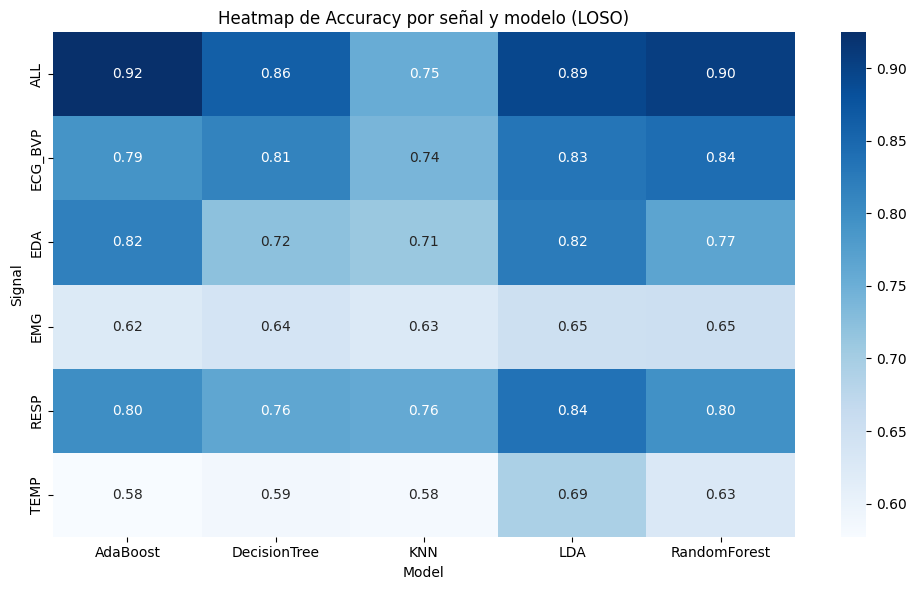

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_14388\1711118399.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

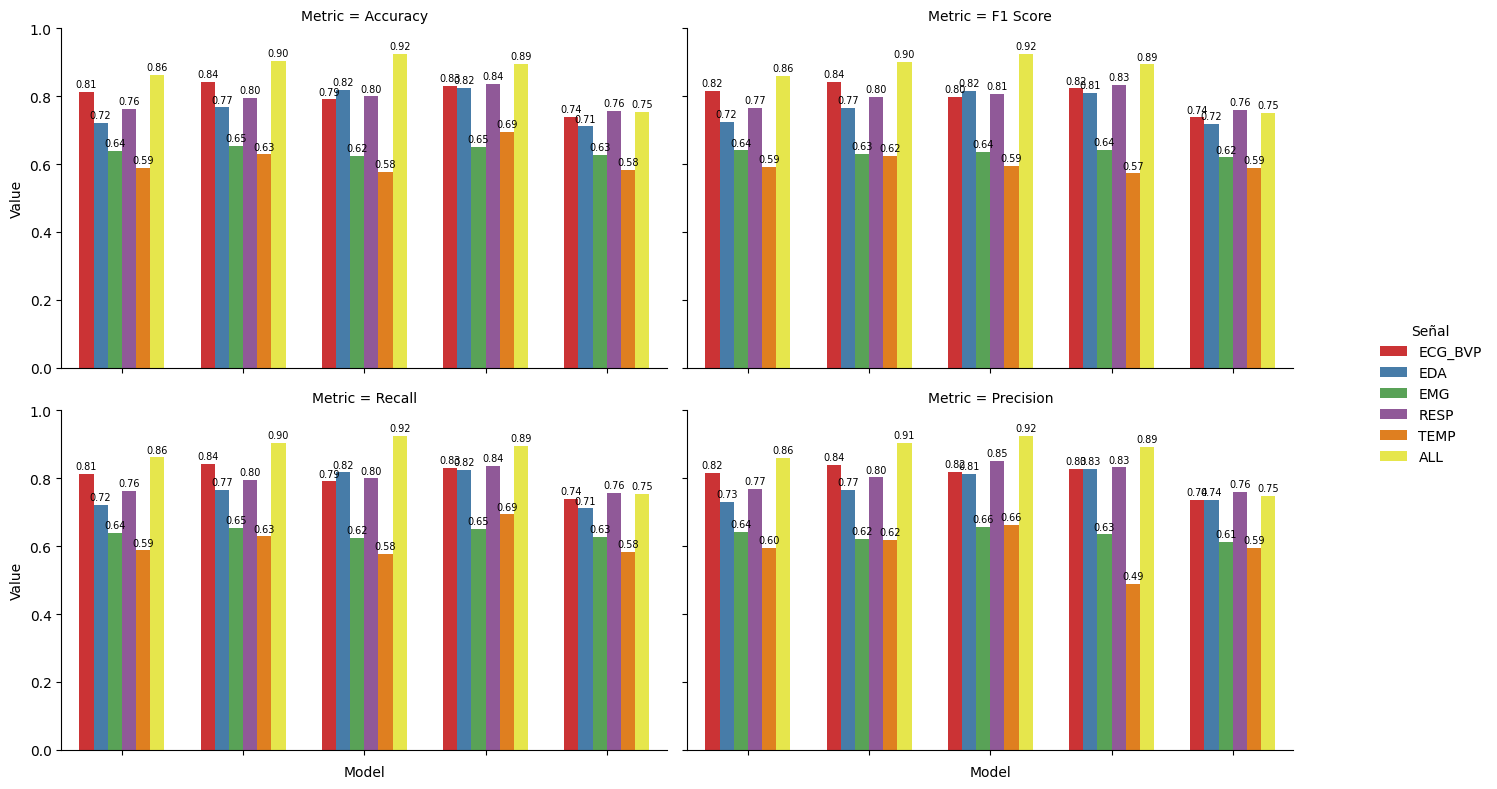

In [144]:
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features].values  # Convertimos a array
        y = df['label'].values
        subjects = df['subject'].values  # Identificador de sujetos

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOGO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas usando LOGO
X_all = df.drop(columns=['label', 'subject']).values
y_all = df['label'].values
subjects_all = df['subject'].values

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOGO...')
    metrics = train_and_evaluate_logo(X_all, y_all, subjects_all, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [145]:
file = r'WESAD_DATA_60_025\features.csv'

df = load_data(file)
df = df.fillna(0)

In [146]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 68659
Label: 2 total: 38904
Label: 3 total: 21459


Training by signal:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ECG_BVP using LOGO...
[ECG_BVP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - DecisionTree] Fold 1/15 (Subject: 2)
[ECG_BVP - DecisionTree] Fold 2/15 (Subject: 3)
[ECG_BVP - DecisionTree] Fold 3/15 (Subject: 4)
[ECG_BVP - DecisionTree] Fold 4/15 (Subject: 5)
[ECG_BVP - DecisionTree] Fold 5/15 (Subject: 6)
[ECG_BVP - DecisionTree] Fold 6/15 (Subject: 7)
[ECG_BVP - DecisionTree] Fold 7/15 (Subject: 8)
[ECG_BVP - DecisionTree] Fold 8/15 (Subject: 9)
[ECG_BVP - DecisionTree] Fold 9/15 (Subject: 10)
[ECG_BVP - DecisionTree] Fold 10/15 (Subject: 11)
[ECG_BVP - DecisionTree] Fold 11/15 (Subject: 13)
[ECG_BVP - DecisionTree] Fold 12/15 (Subject: 14)
[ECG_BVP - DecisionTree] Fold 13/15 (Subject: 15)
[ECG_BVP - DecisionTree] Fold 14/15 (Subject: 16)
[ECG_BVP - DecisionTree] Fold 15/15 (Subject: 17)


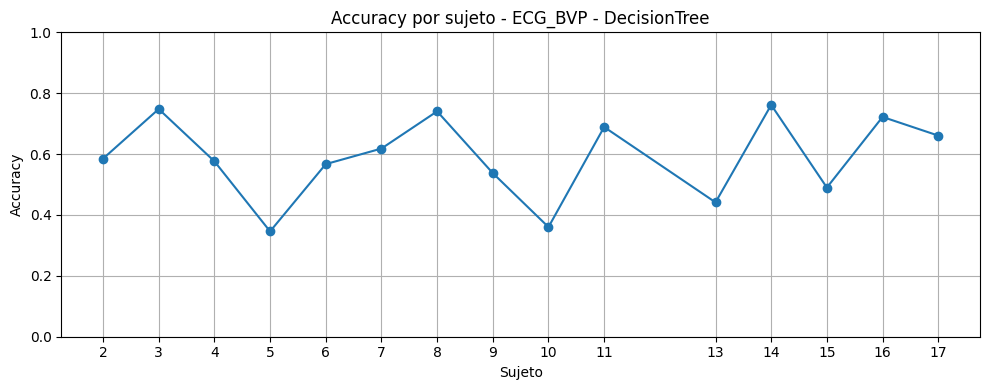

ECG_BVP - DecisionTree Metrics
     Métrica     Valor                   Etapa
0   Accuracy  0.589000  ECG_BVP - DecisionTree
1  Precision  0.601456  ECG_BVP - DecisionTree
2     Recall  0.589000  ECG_BVP - DecisionTree
3   F1 Score  0.593761  ECG_BVP - DecisionTree
[ECG_BVP - DecisionTree] Best Params: {}
[ECG_BVP - DecisionTree] Accuracy: 0.5890
ECG_BVP - DecisionTree - Confusion Matrix
[[42199 10190 16270]
 [ 7481 28305  3118]
 [12281  3688  5490]]


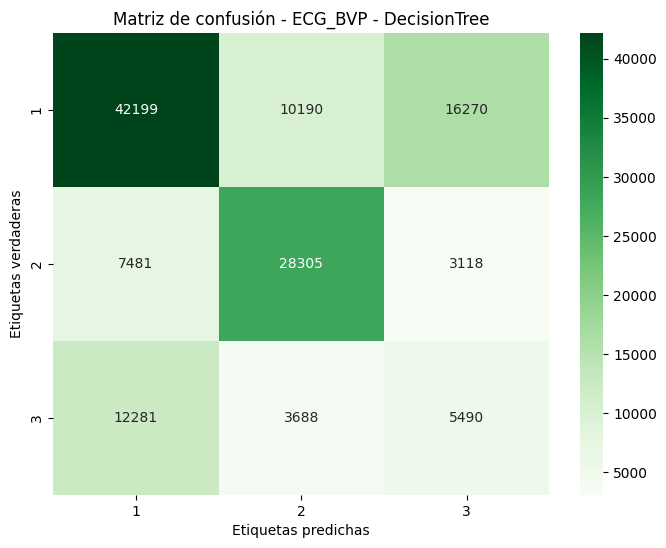

              precision    recall  f1-score   support

           1       0.68      0.61      0.65     68659
           2       0.67      0.73      0.70     38904
           3       0.22      0.26      0.24     21459

    accuracy                           0.59    129022
   macro avg       0.52      0.53      0.53    129022
weighted avg       0.60      0.59      0.59    129022

Training RandomForest model for ECG_BVP using LOGO...
[ECG_BVP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - RandomForest] Fold 1/15 (Subject: 2)
[ECG_BVP - RandomForest] Fold 2/15 (Subject: 3)
[ECG_BVP - RandomForest] Fold 3/15 (Subject: 4)
[ECG_BVP - RandomForest] Fold 4/15 (Subject: 5)
[ECG_BVP - RandomForest] Fold 5/15 (Subject: 6)
[ECG_BVP - RandomForest] Fold 6/15 (Subject: 7)
[ECG_BVP - RandomForest] Fold 7/15 (Subject: 8)
[ECG_BVP - RandomForest] Fold 8/15 (Subject: 9)
[ECG_BVP - RandomForest] Fold 9/15 (Subject: 10)
[ECG_BVP - Rando

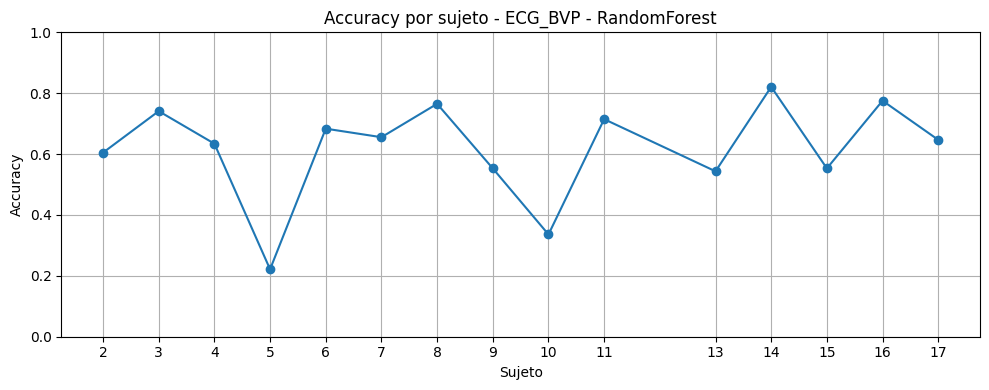

ECG_BVP - RandomForest Metrics
     Métrica     Valor                   Etapa
0   Accuracy  0.615895  ECG_BVP - RandomForest
1  Precision  0.607854  ECG_BVP - RandomForest
2     Recall  0.615895  ECG_BVP - RandomForest
3   F1 Score  0.611734  ECG_BVP - RandomForest
[ECG_BVP - RandomForest] Best Params: {}
[ECG_BVP - RandomForest] Accuracy: 0.6159
ECG_BVP - RandomForest - Confusion Matrix
[[47073  8493 13093]
 [ 7226 28844  2834]
 [14982  2930  3547]]


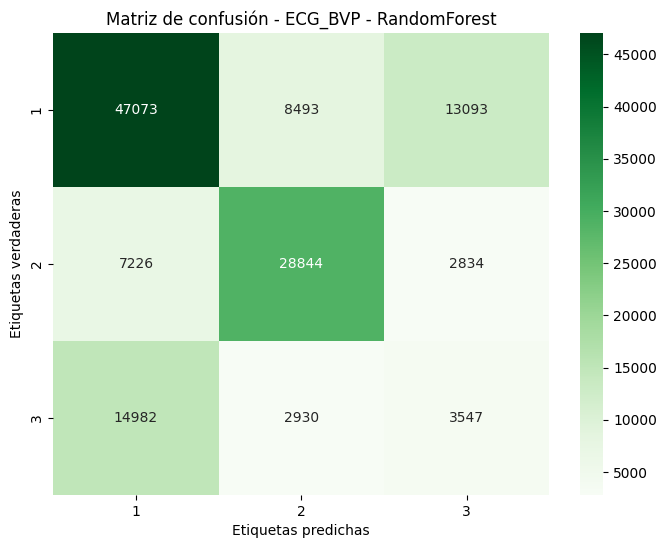

              precision    recall  f1-score   support

           1       0.68      0.69      0.68     68659
           2       0.72      0.74      0.73     38904
           3       0.18      0.17      0.17     21459

    accuracy                           0.62    129022
   macro avg       0.53      0.53      0.53    129022
weighted avg       0.61      0.62      0.61    129022

Training AdaBoost model for ECG_BVP using LOGO...
[ECG_BVP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[ECG_BVP - AdaBoost] Fold 1/15 (Subject: 2)
[ECG_BVP - AdaBoost] Fold 2/15 (Subject: 3)
[ECG_BVP - AdaBoost] Fold 3/15 (Subject: 4)
[ECG_BVP - AdaBoost] Fold 4/15 (Subject: 5)
[ECG_BVP - AdaBoost] Fold 5/15 (Subject: 6)
[ECG_BVP - AdaBoost] Fold 6/15 (Subject: 7)
[ECG_BVP - AdaBoost] Fold 7/15 (Subject: 8)
[ECG_BVP - AdaBoost] Fold 8/15 (Subject: 9)
[ECG_BVP - AdaBoost] Fold 9/15 (Subject: 10)
[ECG_BVP - AdaBoost] Fold 10/15 (Subject: 11)
[ECG_BVP - Ada

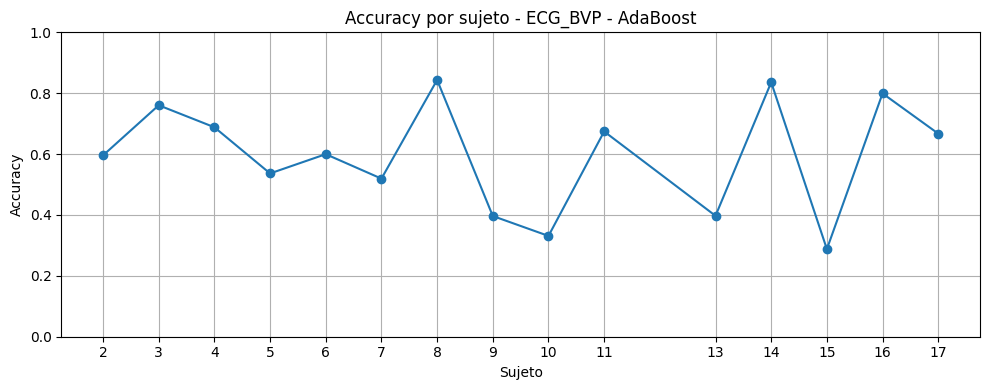

ECG_BVP - AdaBoost Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.594713  ECG_BVP - AdaBoost
1  Precision  0.615661  ECG_BVP - AdaBoost
2     Recall  0.594713  ECG_BVP - AdaBoost
3   F1 Score  0.602597  ECG_BVP - AdaBoost
[ECG_BVP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.1, 'n_estimators': 100}
[ECG_BVP - AdaBoost] Accuracy: 0.5947
ECG_BVP - AdaBoost - Confusion Matrix
[[42563  9913 16183]
 [ 4887 28970  5047]
 [12310  3951  5198]]


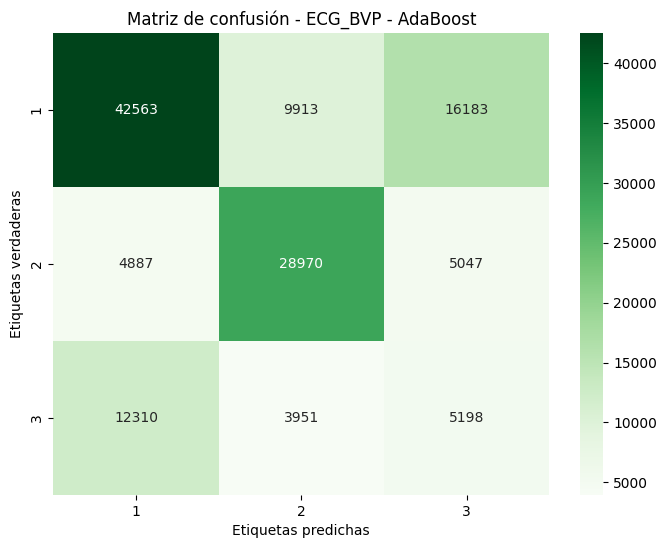

              precision    recall  f1-score   support

           1       0.71      0.62      0.66     68659
           2       0.68      0.74      0.71     38904
           3       0.20      0.24      0.22     21459

    accuracy                           0.59    129022
   macro avg       0.53      0.54      0.53    129022
weighted avg       0.62      0.59      0.60    129022

Training LDA model for ECG_BVP using LOGO...
[ECG_BVP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - LDA] Fold 1/15 (Subject: 2)
[ECG_BVP - LDA] Fold 2/15 (Subject: 3)
[ECG_BVP - LDA] Fold 3/15 (Subject: 4)
[ECG_BVP - LDA] Fold 4/15 (Subject: 5)
[ECG_BVP - LDA] Fold 5/15 (Subject: 6)
[ECG_BVP - LDA] Fold 6/15 (Subject: 7)
[ECG_BVP - LDA] Fold 7/15 (Subject: 8)
[ECG_BVP - LDA] Fold 8/15 (Subject: 9)
[ECG_BVP - LDA] Fold 9/15 (Subject: 10)
[ECG_BVP - LDA] Fold 10/15 (Subject: 11)
[ECG_BVP - LDA] Fold 11/15 (Subject: 13)
[ECG_BVP - LDA] Fold 12/15 (Subje

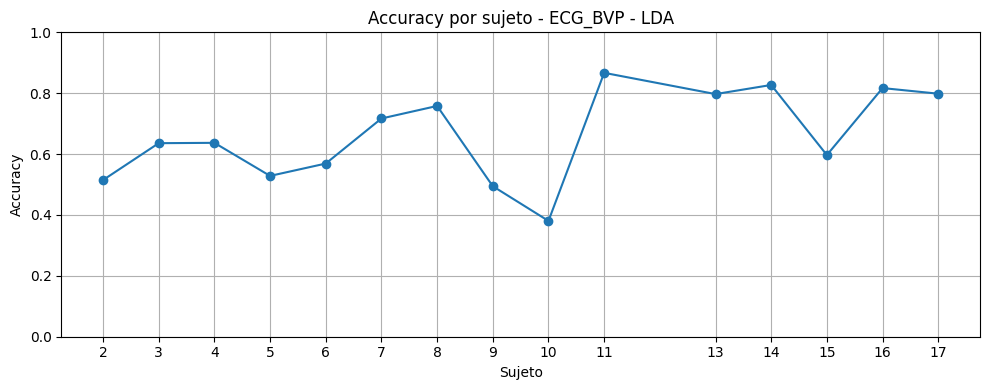

ECG_BVP - LDA Metrics
     Métrica     Valor          Etapa
0   Accuracy  0.663026  ECG_BVP - LDA
1  Precision  0.634387  ECG_BVP - LDA
2     Recall  0.663026  ECG_BVP - LDA
3   F1 Score  0.633521  ECG_BVP - LDA
[ECG_BVP - LDA] Best Params: {'solver': 'svd'}
[ECG_BVP - LDA] Accuracy: 0.6630
ECG_BVP - LDA - Confusion Matrix
[[58964  5123  4572]
 [13071 23952  1881]
 [17036  1794  2629]]


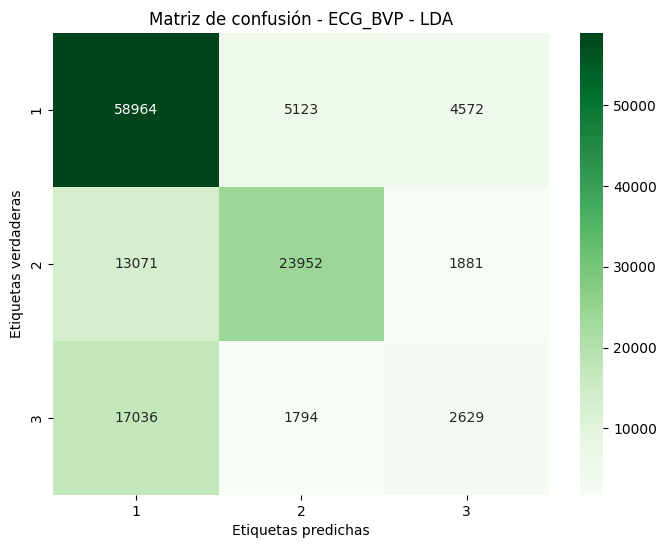

              precision    recall  f1-score   support

           1       0.66      0.86      0.75     68659
           2       0.78      0.62      0.69     38904
           3       0.29      0.12      0.17     21459

    accuracy                           0.66    129022
   macro avg       0.58      0.53      0.54    129022
weighted avg       0.63      0.66      0.63    129022

Training KNN model for ECG_BVP using LOGO...
[ECG_BVP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[ECG_BVP - KNN] Fold 1/15 (Subject: 2)
[ECG_BVP - KNN] Fold 2/15 (Subject: 3)
[ECG_BVP - KNN] Fold 3/15 (Subject: 4)
[ECG_BVP - KNN] Fold 4/15 (Subject: 5)
[ECG_BVP - KNN] Fold 5/15 (Subject: 6)
[ECG_BVP - KNN] Fold 6/15 (Subject: 7)
[ECG_BVP - KNN] Fold 7/15 (Subject: 8)
[ECG_BVP - KNN] Fold 8/15 (Subject: 9)
[ECG_BVP - KNN] Fold 9/15 (Subject: 10)
[ECG_BVP - KNN] Fold 10/15 (Subject: 11)
[ECG_BVP - KNN] Fold 11/15 (Subject: 13)
[ECG_BVP - KNN] Fold 12/15 (Subje

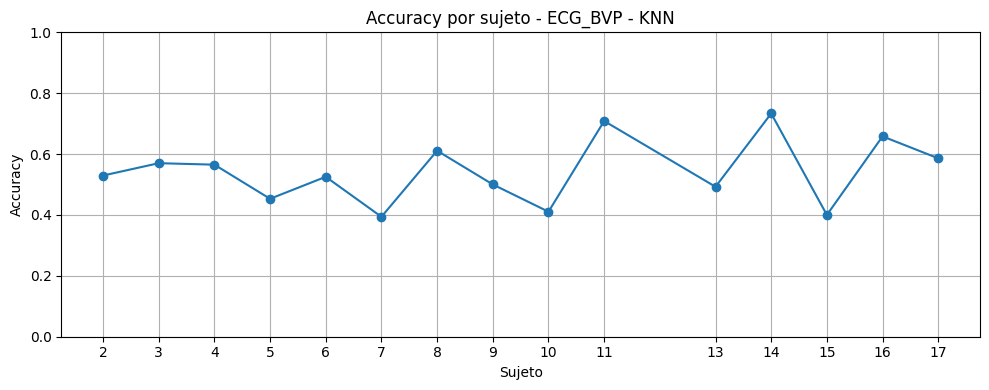

ECG_BVP - KNN Metrics
     Métrica     Valor          Etapa
0   Accuracy  0.542504  ECG_BVP - KNN
1  Precision  0.540288  ECG_BVP - KNN
2     Recall  0.542504  ECG_BVP - KNN
3   F1 Score  0.541311  ECG_BVP - KNN
[ECG_BVP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[ECG_BVP - KNN] Accuracy: 0.5425
ECG_BVP - KNN - Confusion Matrix
[[43770 13167 11722]
 [13404 21282  4218]
 [13113  3403  4943]]


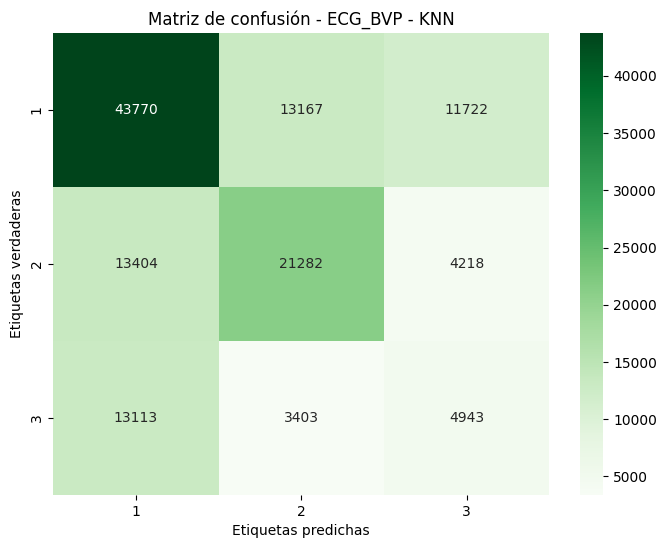

Training by signal:  20%|██        | 1/5 [26:57<1:47:48, 1617.19s/it]

              precision    recall  f1-score   support

           1       0.62      0.64      0.63     68659
           2       0.56      0.55      0.55     38904
           3       0.24      0.23      0.23     21459

    accuracy                           0.54    129022
   macro avg       0.47      0.47      0.47    129022
weighted avg       0.54      0.54      0.54    129022

Training DecisionTree model for EDA using LOGO...
[EDA - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - DecisionTree] Fold 1/15 (Subject: 2)
[EDA - DecisionTree] Fold 2/15 (Subject: 3)
[EDA - DecisionTree] Fold 3/15 (Subject: 4)
[EDA - DecisionTree] Fold 4/15 (Subject: 5)
[EDA - DecisionTree] Fold 5/15 (Subject: 6)
[EDA - DecisionTree] Fold 6/15 (Subject: 7)
[EDA - DecisionTree] Fold 7/15 (Subject: 8)
[EDA - DecisionTree] Fold 8/15 (Subject: 9)
[EDA - DecisionTree] Fold 9/15 (Subject: 10)
[EDA - DecisionTree] Fold 10/15 (Subject: 11)
[EDA - Decisio

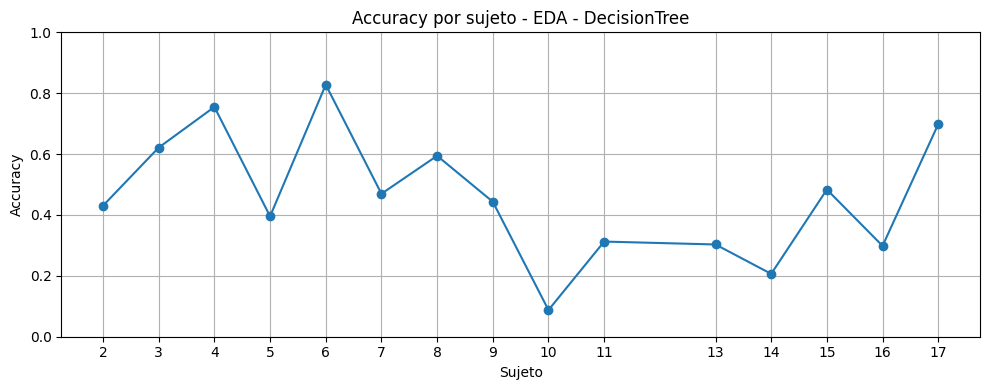

EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.460534  EDA - DecisionTree
1  Precision  0.521693  EDA - DecisionTree
2     Recall  0.460534  EDA - DecisionTree
3   F1 Score  0.482836  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {}
[EDA - DecisionTree] Accuracy: 0.4605
EDA - DecisionTree - Confusion Matrix
[[30423 10240 27996]
 [ 9055 24390  5459]
 [11470  5383  4606]]


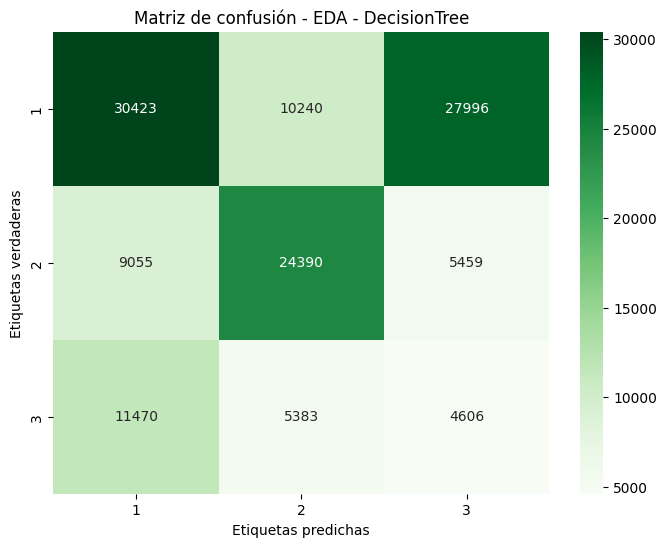

              precision    recall  f1-score   support

           1       0.60      0.44      0.51     68659
           2       0.61      0.63      0.62     38904
           3       0.12      0.21      0.15     21459

    accuracy                           0.46    129022
   macro avg       0.44      0.43      0.43    129022
weighted avg       0.52      0.46      0.48    129022

Training RandomForest model for EDA using LOGO...
[EDA - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - RandomForest] Fold 1/15 (Subject: 2)
[EDA - RandomForest] Fold 2/15 (Subject: 3)
[EDA - RandomForest] Fold 3/15 (Subject: 4)
[EDA - RandomForest] Fold 4/15 (Subject: 5)
[EDA - RandomForest] Fold 5/15 (Subject: 6)
[EDA - RandomForest] Fold 6/15 (Subject: 7)
[EDA - RandomForest] Fold 7/15 (Subject: 8)
[EDA - RandomForest] Fold 8/15 (Subject: 9)
[EDA - RandomForest] Fold 9/15 (Subject: 10)
[EDA - RandomForest] Fold 10/15 (Subject: 11)
[EDA - RandomF

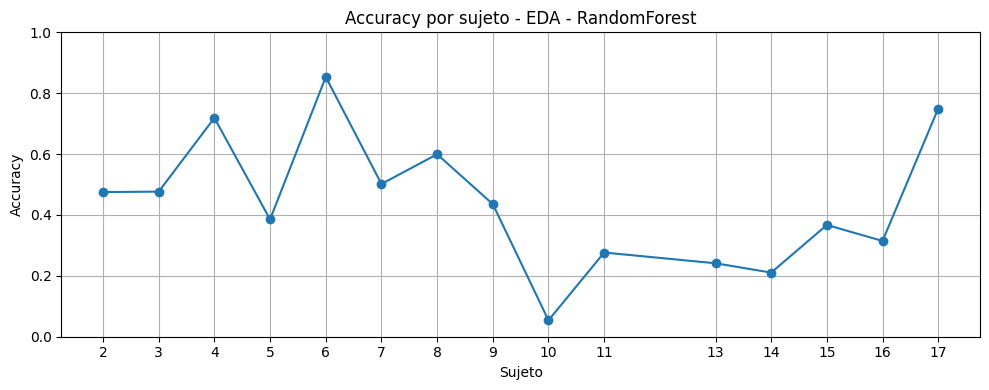

EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.442762  EDA - RandomForest
1  Precision  0.502597  EDA - RandomForest
2     Recall  0.442762  EDA - RandomForest
3   F1 Score  0.460346  EDA - RandomForest
[EDA - RandomForest] Best Params: {}
[EDA - RandomForest] Accuracy: 0.4428
EDA - RandomForest - Confusion Matrix
[[27011 13360 28288]
 [ 8197 25312  5395]
 [11516  5140  4803]]


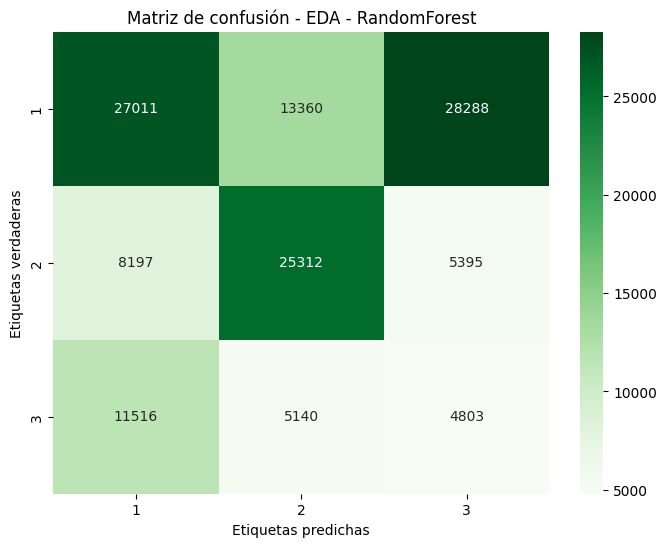

              precision    recall  f1-score   support

           1       0.58      0.39      0.47     68659
           2       0.58      0.65      0.61     38904
           3       0.12      0.22      0.16     21459

    accuracy                           0.44    129022
   macro avg       0.43      0.42      0.41    129022
weighted avg       0.50      0.44      0.46    129022

Training AdaBoost model for EDA using LOGO...
[EDA - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[EDA - AdaBoost] Fold 1/15 (Subject: 2)
[EDA - AdaBoost] Fold 2/15 (Subject: 3)
[EDA - AdaBoost] Fold 3/15 (Subject: 4)
[EDA - AdaBoost] Fold 4/15 (Subject: 5)
[EDA - AdaBoost] Fold 5/15 (Subject: 6)
[EDA - AdaBoost] Fold 6/15 (Subject: 7)
[EDA - AdaBoost] Fold 7/15 (Subject: 8)
[EDA - AdaBoost] Fold 8/15 (Subject: 9)
[EDA - AdaBoost] Fold 9/15 (Subject: 10)
[EDA - AdaBoost] Fold 10/15 (Subject: 11)
[EDA - AdaBoost] Fold 11/15 (Subject: 13)
[EDA - AdaBoost] Fol

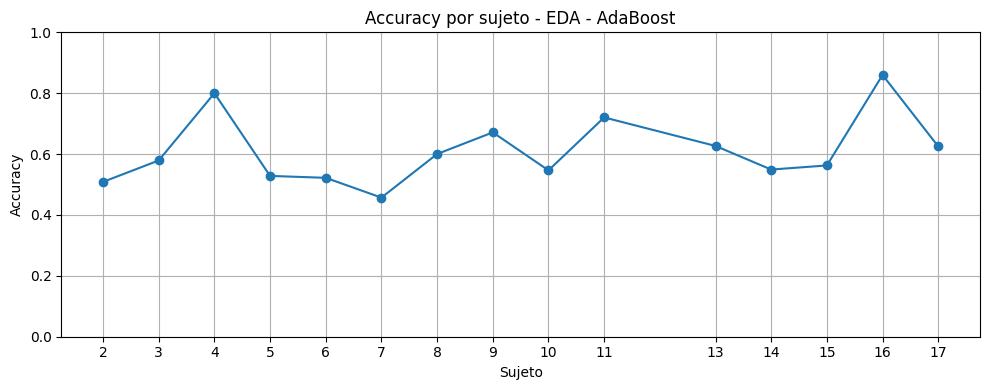

EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.610586  EDA - AdaBoost
1  Precision  0.616685  EDA - AdaBoost
2     Recall  0.610586  EDA - AdaBoost
3   F1 Score  0.612637  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.01, 'n_estimators': 100}
[EDA - AdaBoost] Accuracy: 0.6106
EDA - AdaBoost - Confusion Matrix
[[48963  4305 15391]
 [11115 25179  2610]
 [11869  4953  4637]]


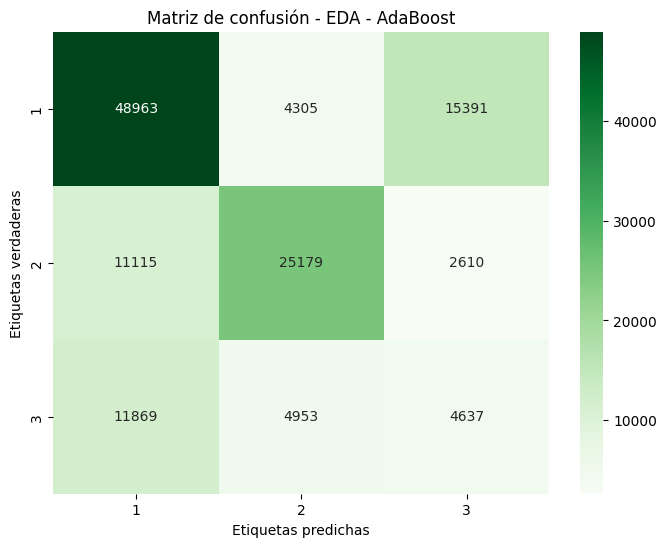

              precision    recall  f1-score   support

           1       0.68      0.71      0.70     68659
           2       0.73      0.65      0.69     38904
           3       0.20      0.22      0.21     21459

    accuracy                           0.61    129022
   macro avg       0.54      0.53      0.53    129022
weighted avg       0.62      0.61      0.61    129022

Training LDA model for EDA using LOGO...
[EDA - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - LDA] Fold 1/15 (Subject: 2)
[EDA - LDA] Fold 2/15 (Subject: 3)
[EDA - LDA] Fold 3/15 (Subject: 4)
[EDA - LDA] Fold 4/15 (Subject: 5)
[EDA - LDA] Fold 5/15 (Subject: 6)
[EDA - LDA] Fold 6/15 (Subject: 7)
[EDA - LDA] Fold 7/15 (Subject: 8)
[EDA - LDA] Fold 8/15 (Subject: 9)
[EDA - LDA] Fold 9/15 (Subject: 10)
[EDA - LDA] Fold 10/15 (Subject: 11)
[EDA - LDA] Fold 11/15 (Subject: 13)
[EDA - LDA] Fold 12/15 (Subject: 14)
[EDA - LDA] Fold 13/15 (Subject: 15)
[EDA - LDA]

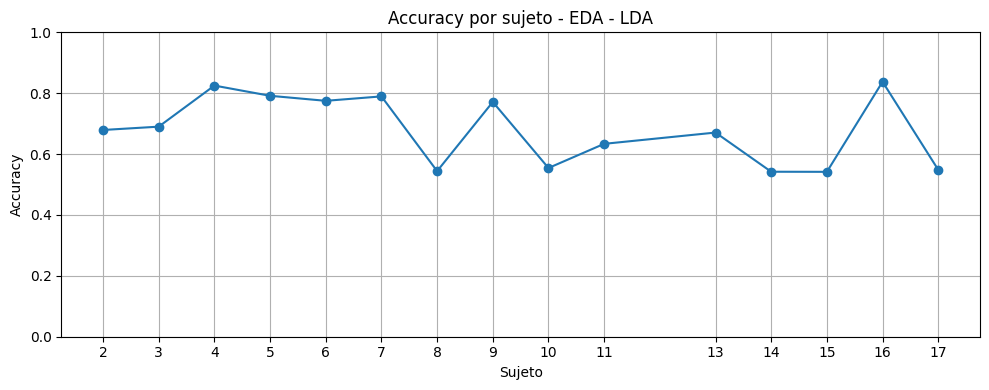

EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.678659  EDA - LDA
1  Precision  0.669664  EDA - LDA
2     Recall  0.678659  EDA - LDA
3   F1 Score  0.615723  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.6787
EDA - LDA - Confusion Matrix
[[66331  1900   428]
 [18013 20588   303]
 [18249  2567   643]]


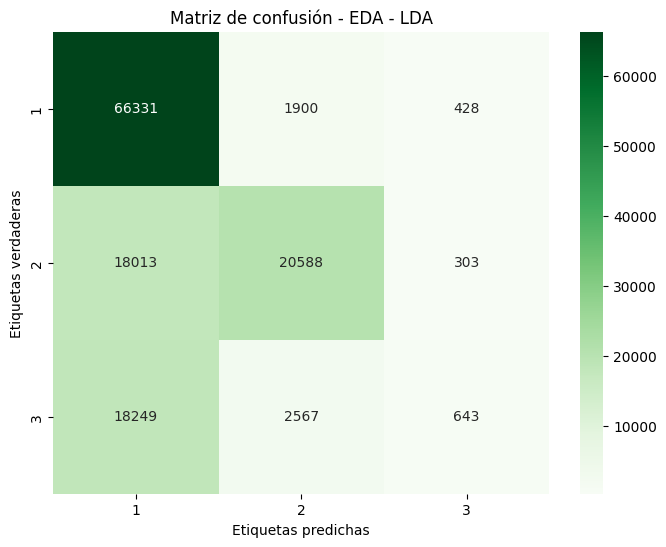

              precision    recall  f1-score   support

           1       0.65      0.97      0.77     68659
           2       0.82      0.53      0.64     38904
           3       0.47      0.03      0.06     21459

    accuracy                           0.68    129022
   macro avg       0.65      0.51      0.49    129022
weighted avg       0.67      0.68      0.62    129022

Training KNN model for EDA using LOGO...
[EDA - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[EDA - KNN] Fold 1/15 (Subject: 2)
[EDA - KNN] Fold 2/15 (Subject: 3)
[EDA - KNN] Fold 3/15 (Subject: 4)
[EDA - KNN] Fold 4/15 (Subject: 5)
[EDA - KNN] Fold 5/15 (Subject: 6)
[EDA - KNN] Fold 6/15 (Subject: 7)
[EDA - KNN] Fold 7/15 (Subject: 8)
[EDA - KNN] Fold 8/15 (Subject: 9)
[EDA - KNN] Fold 9/15 (Subject: 10)
[EDA - KNN] Fold 10/15 (Subject: 11)
[EDA - KNN] Fold 11/15 (Subject: 13)
[EDA - KNN] Fold 12/15 (Subject: 14)
[EDA - KNN] Fold 13/15 (Subject: 15)
[EDA - KNN]

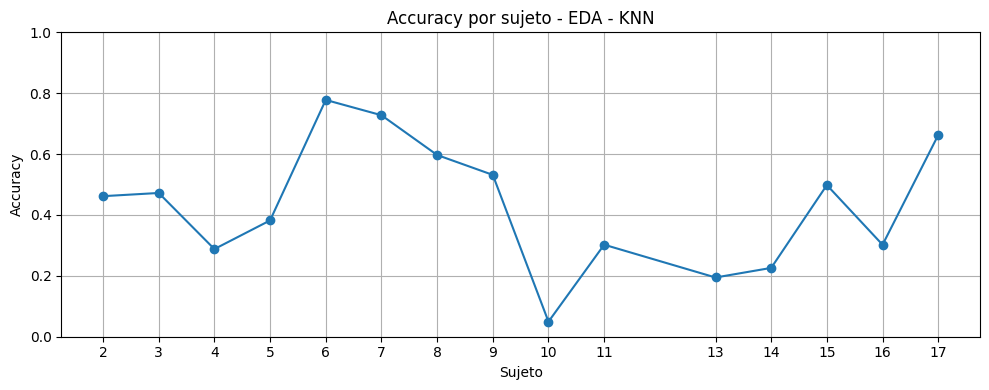

EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.430764  EDA - KNN
1  Precision  0.475362  EDA - KNN
2     Recall  0.430764  EDA - KNN
3   F1 Score  0.438659  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.4308
EDA - KNN - Confusion Matrix
[[25231 18486 24942]
 [ 8888 25503  4513]
 [11215  5400  4844]]


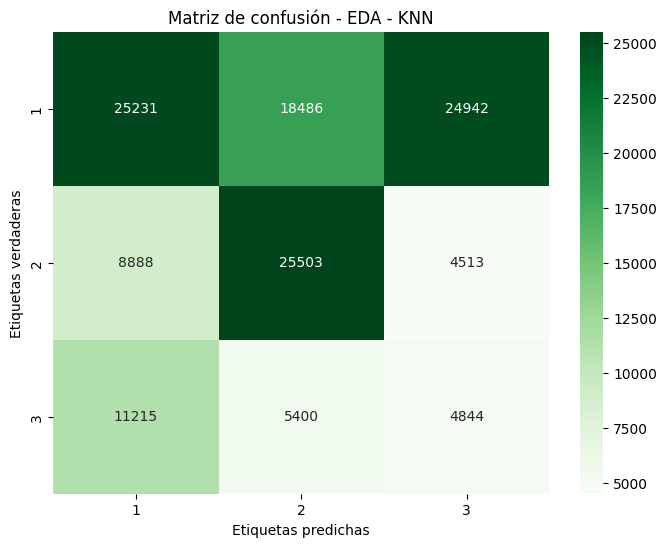

Training by signal:  40%|████      | 2/5 [45:50<1:06:37, 1332.41s/it]

              precision    recall  f1-score   support

           1       0.56      0.37      0.44     68659
           2       0.52      0.66      0.58     38904
           3       0.14      0.23      0.17     21459

    accuracy                           0.43    129022
   macro avg       0.40      0.42      0.40    129022
weighted avg       0.48      0.43      0.44    129022

Training DecisionTree model for EMG using LOGO...
[EMG - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EMG - DecisionTree] Fold 1/15 (Subject: 2)
[EMG - DecisionTree] Fold 2/15 (Subject: 3)
[EMG - DecisionTree] Fold 3/15 (Subject: 4)
[EMG - DecisionTree] Fold 4/15 (Subject: 5)
[EMG - DecisionTree] Fold 5/15 (Subject: 6)
[EMG - DecisionTree] Fold 6/15 (Subject: 7)
[EMG - DecisionTree] Fold 7/15 (Subject: 8)
[EMG - DecisionTree] Fold 8/15 (Subject: 9)
[EMG - DecisionTree] Fold 9/15 (Subject: 10)
[EMG - DecisionTree] Fold 10/15 (Subject: 11)
[EMG - Decisio

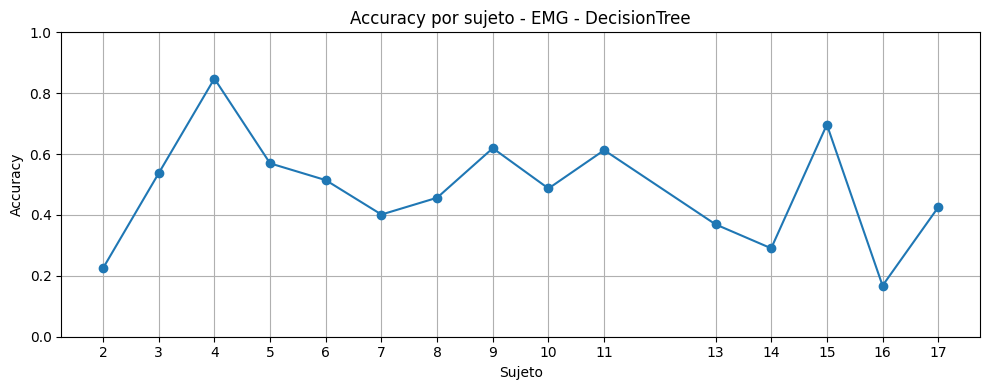

EMG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.481360  EMG - DecisionTree
1  Precision  0.486707  EMG - DecisionTree
2     Recall  0.481360  EMG - DecisionTree
3   F1 Score  0.481787  EMG - DecisionTree
[EMG - DecisionTree] Best Params: {}
[EMG - DecisionTree] Accuracy: 0.4814
EMG - DecisionTree - Confusion Matrix
[[44552 13203 10904]
 [16896 10778 11230]
 [ 7762  6921  6776]]


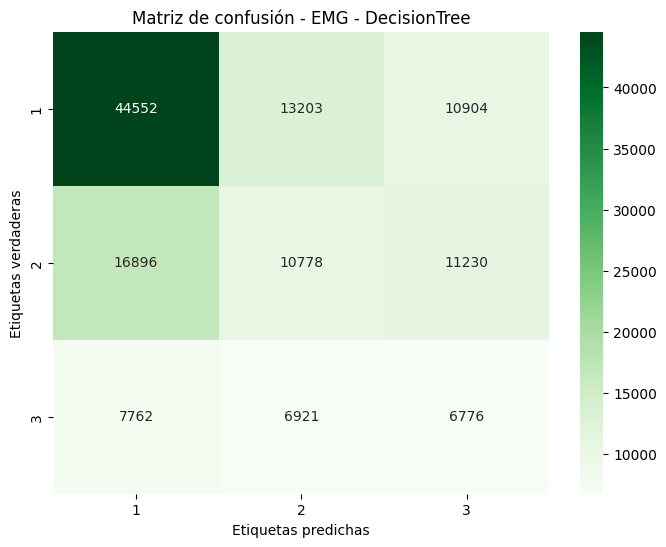

              precision    recall  f1-score   support

           1       0.64      0.65      0.65     68659
           2       0.35      0.28      0.31     38904
           3       0.23      0.32      0.27     21459

    accuracy                           0.48    129022
   macro avg       0.41      0.41      0.41    129022
weighted avg       0.49      0.48      0.48    129022

Training RandomForest model for EMG using LOGO...
[EMG - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EMG - RandomForest] Fold 1/15 (Subject: 2)
[EMG - RandomForest] Fold 2/15 (Subject: 3)
[EMG - RandomForest] Fold 3/15 (Subject: 4)
[EMG - RandomForest] Fold 4/15 (Subject: 5)
[EMG - RandomForest] Fold 5/15 (Subject: 6)
[EMG - RandomForest] Fold 6/15 (Subject: 7)
[EMG - RandomForest] Fold 7/15 (Subject: 8)
[EMG - RandomForest] Fold 8/15 (Subject: 9)
[EMG - RandomForest] Fold 9/15 (Subject: 10)
[EMG - RandomForest] Fold 10/15 (Subject: 11)
[EMG - RandomF

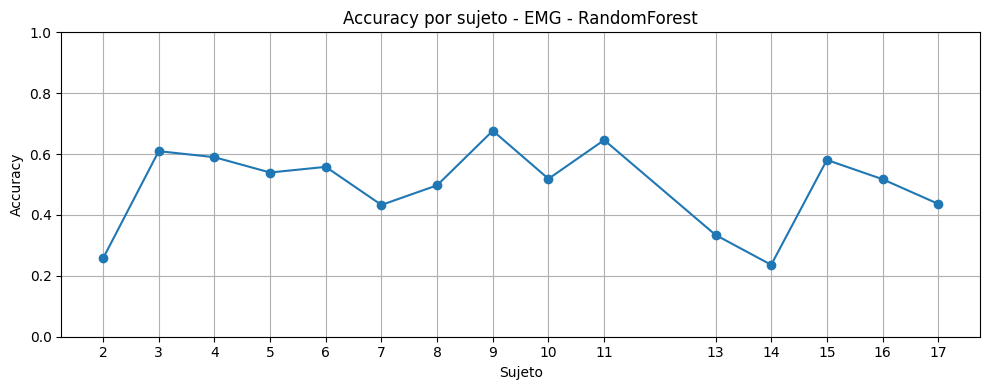

EMG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.495567  EMG - RandomForest
1  Precision  0.467895  EMG - RandomForest
2     Recall  0.495567  EMG - RandomForest
3   F1 Score  0.478282  EMG - RandomForest
[EMG - RandomForest] Best Params: {}
[EMG - RandomForest] Accuracy: 0.4956
EMG - RandomForest - Confusion Matrix
[[48509 15449  4701]
 [19818 11777  7309]
 [11700  6106  3653]]


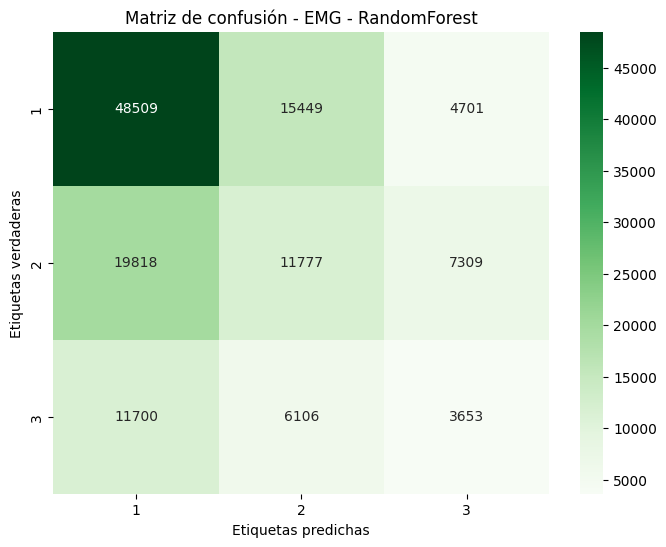

              precision    recall  f1-score   support

           1       0.61      0.71      0.65     68659
           2       0.35      0.30      0.33     38904
           3       0.23      0.17      0.20     21459

    accuracy                           0.50    129022
   macro avg       0.40      0.39      0.39    129022
weighted avg       0.47      0.50      0.48    129022

Training AdaBoost model for EMG using LOGO...
[EMG - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[EMG - AdaBoost] Fold 1/15 (Subject: 2)
[EMG - AdaBoost] Fold 2/15 (Subject: 3)
[EMG - AdaBoost] Fold 3/15 (Subject: 4)
[EMG - AdaBoost] Fold 4/15 (Subject: 5)
[EMG - AdaBoost] Fold 5/15 (Subject: 6)
[EMG - AdaBoost] Fold 6/15 (Subject: 7)
[EMG - AdaBoost] Fold 7/15 (Subject: 8)
[EMG - AdaBoost] Fold 8/15 (Subject: 9)
[EMG - AdaBoost] Fold 9/15 (Subject: 10)
[EMG - AdaBoost] Fold 10/15 (Subject: 11)
[EMG - AdaBoost] Fold 11/15 (Subject: 13)
[EMG - AdaBoost] Fol

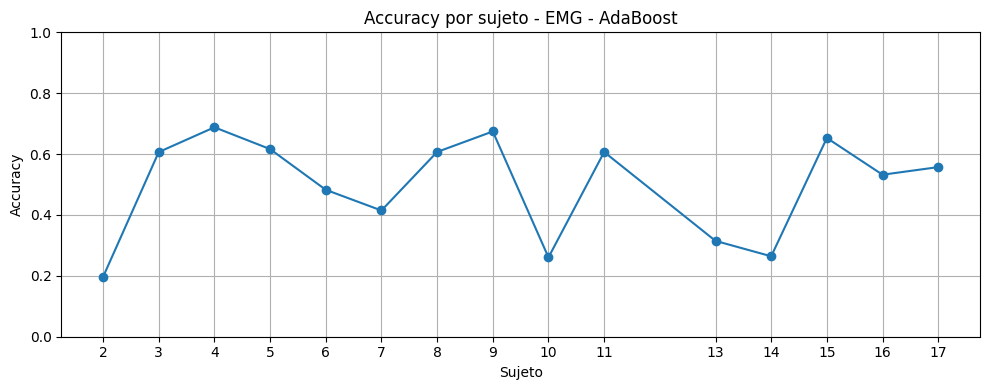

EMG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.498303  EMG - AdaBoost
1  Precision  0.531908  EMG - AdaBoost
2     Recall  0.498303  EMG - AdaBoost
3   F1 Score  0.500641  EMG - AdaBoost
[EMG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.1, 'n_estimators': 100}
[EMG - AdaBoost] Accuracy: 0.4983
EMG - AdaBoost - Confusion Matrix
[[43872  8959 15828]
 [14247  9100 15557]
 [ 5599  4540 11320]]


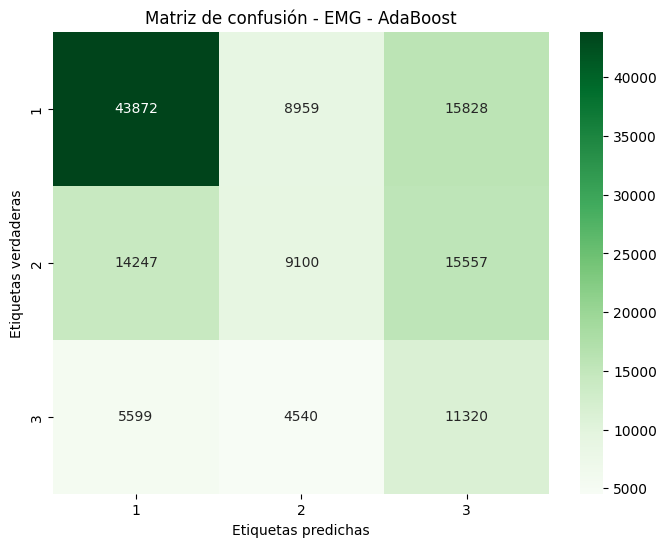

              precision    recall  f1-score   support

           1       0.69      0.64      0.66     68659
           2       0.40      0.23      0.30     38904
           3       0.27      0.53      0.35     21459

    accuracy                           0.50    129022
   macro avg       0.45      0.47      0.44    129022
weighted avg       0.53      0.50      0.50    129022

Training LDA model for EMG using LOGO...
[EMG - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EMG - LDA] Fold 1/15 (Subject: 2)
[EMG - LDA] Fold 2/15 (Subject: 3)
[EMG - LDA] Fold 3/15 (Subject: 4)
[EMG - LDA] Fold 4/15 (Subject: 5)
[EMG - LDA] Fold 5/15 (Subject: 6)
[EMG - LDA] Fold 6/15 (Subject: 7)
[EMG - LDA] Fold 7/15 (Subject: 8)
[EMG - LDA] Fold 8/15 (Subject: 9)
[EMG - LDA] Fold 9/15 (Subject: 10)
[EMG - LDA] Fold 10/15 (Subject: 11)
[EMG - LDA] Fold 11/15 (Subject: 13)
[EMG - LDA] Fold 12/15 (Subject: 14)
[EMG - LDA] Fold 13/15 (Subject: 15)
[EMG - LDA]

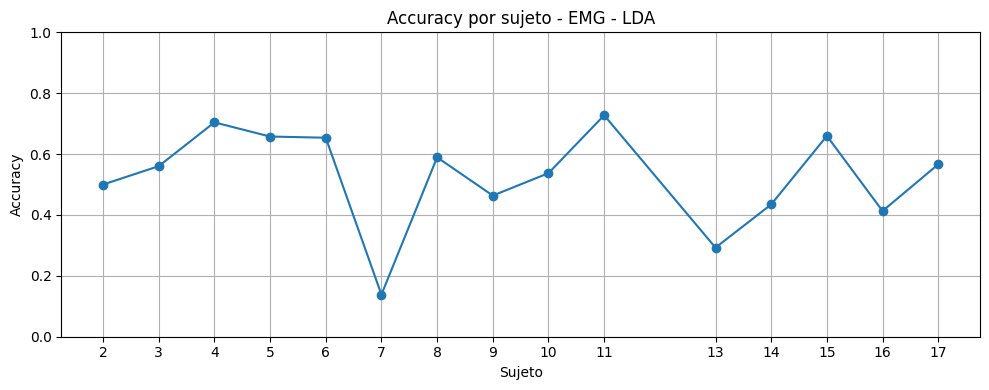

EMG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.526623  EMG - LDA
1  Precision  0.514995  EMG - LDA
2     Recall  0.526623  EMG - LDA
3   F1 Score  0.517219  EMG - LDA
[EMG - LDA] Best Params: {'solver': 'svd'}
[EMG - LDA] Accuracy: 0.5266
EMG - LDA - Confusion Matrix
[[46761 18210  3688]
 [19620 14874  4410]
 [10880  4268  6311]]


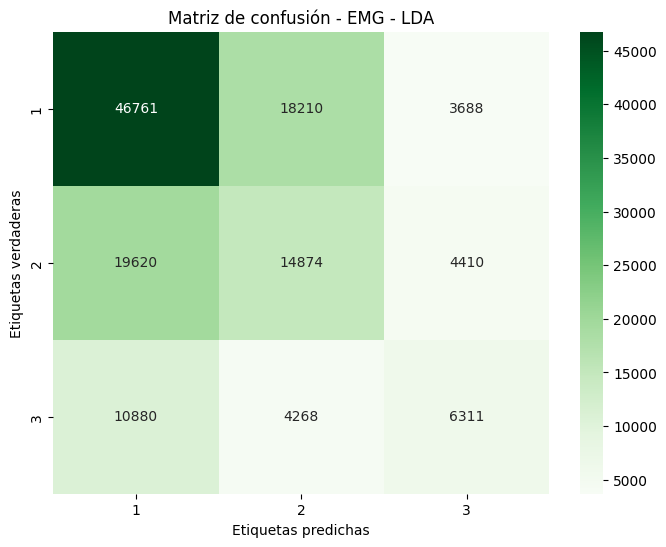

              precision    recall  f1-score   support

           1       0.61      0.68      0.64     68659
           2       0.40      0.38      0.39     38904
           3       0.44      0.29      0.35     21459

    accuracy                           0.53    129022
   macro avg       0.48      0.45      0.46    129022
weighted avg       0.51      0.53      0.52    129022

Training KNN model for EMG using LOGO...
[EMG - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[EMG - KNN] Fold 1/15 (Subject: 2)
[EMG - KNN] Fold 2/15 (Subject: 3)
[EMG - KNN] Fold 3/15 (Subject: 4)
[EMG - KNN] Fold 4/15 (Subject: 5)
[EMG - KNN] Fold 5/15 (Subject: 6)
[EMG - KNN] Fold 6/15 (Subject: 7)
[EMG - KNN] Fold 7/15 (Subject: 8)
[EMG - KNN] Fold 8/15 (Subject: 9)
[EMG - KNN] Fold 9/15 (Subject: 10)
[EMG - KNN] Fold 10/15 (Subject: 11)
[EMG - KNN] Fold 11/15 (Subject: 13)
[EMG - KNN] Fold 12/15 (Subject: 14)
[EMG - KNN] Fold 13/15 (Subject: 15)
[EMG - KNN]

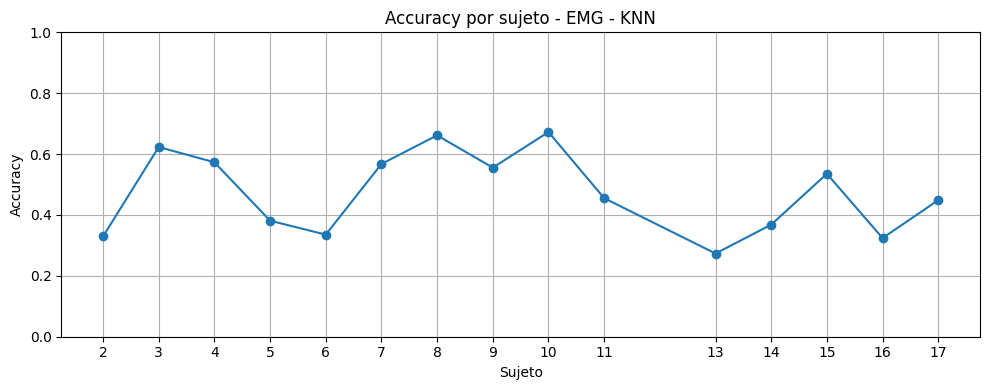

EMG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.473749  EMG - KNN
1  Precision  0.460316  EMG - KNN
2     Recall  0.473749  EMG - KNN
3   F1 Score  0.465959  EMG - KNN
[EMG - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[EMG - KNN] Accuracy: 0.4737
EMG - KNN - Confusion Matrix
[[44503 16498  7658]
 [18739 12408  7757]
 [11689  5557  4213]]


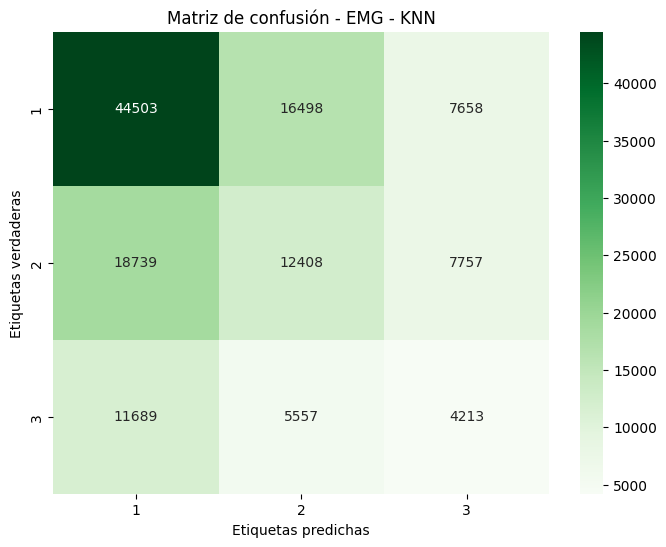

Training by signal:  60%|██████    | 3/5 [1:18:11<53:40, 1610.21s/it]

              precision    recall  f1-score   support

           1       0.59      0.65      0.62     68659
           2       0.36      0.32      0.34     38904
           3       0.21      0.20      0.21     21459

    accuracy                           0.47    129022
   macro avg       0.39      0.39      0.39    129022
weighted avg       0.46      0.47      0.47    129022

Training DecisionTree model for RESP using LOGO...
[RESP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[RESP - DecisionTree] Fold 1/15 (Subject: 2)
[RESP - DecisionTree] Fold 2/15 (Subject: 3)
[RESP - DecisionTree] Fold 3/15 (Subject: 4)
[RESP - DecisionTree] Fold 4/15 (Subject: 5)
[RESP - DecisionTree] Fold 5/15 (Subject: 6)
[RESP - DecisionTree] Fold 6/15 (Subject: 7)
[RESP - DecisionTree] Fold 7/15 (Subject: 8)
[RESP - DecisionTree] Fold 8/15 (Subject: 9)
[RESP - DecisionTree] Fold 9/15 (Subject: 10)
[RESP - DecisionTree] Fold 10/15 (Subject: 11)
[R

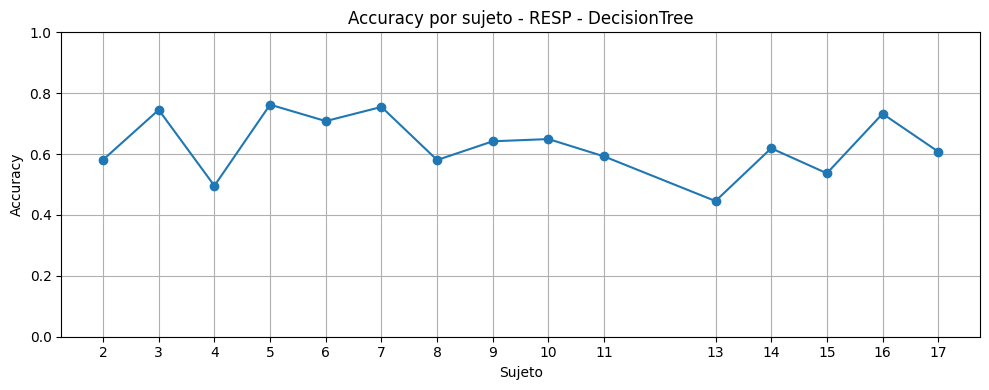

RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.630241  RESP - DecisionTree
1  Precision  0.619561  RESP - DecisionTree
2     Recall  0.630241  RESP - DecisionTree
3   F1 Score  0.624066  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {}
[RESP - DecisionTree] Accuracy: 0.6302
RESP - DecisionTree - Confusion Matrix
[[50152 10192  8315]
 [ 8895 26047  3962]
 [10270  6073  5116]]


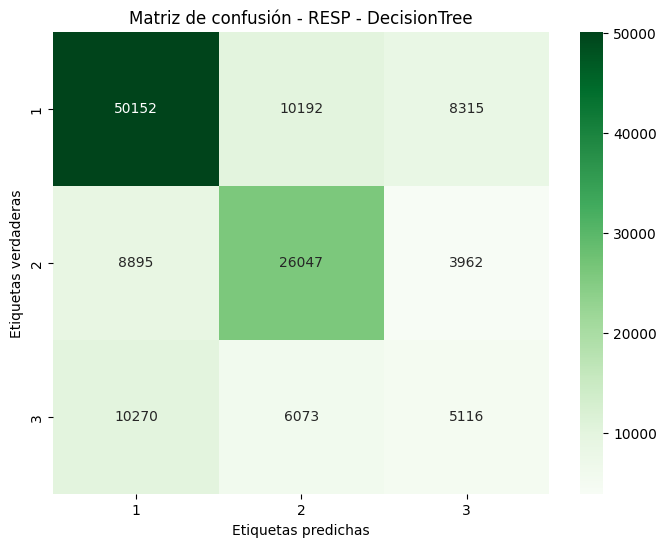

              precision    recall  f1-score   support

           1       0.72      0.73      0.73     68659
           2       0.62      0.67      0.64     38904
           3       0.29      0.24      0.26     21459

    accuracy                           0.63    129022
   macro avg       0.54      0.55      0.54    129022
weighted avg       0.62      0.63      0.62    129022

Training RandomForest model for RESP using LOGO...
[RESP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[RESP - RandomForest] Fold 1/15 (Subject: 2)
[RESP - RandomForest] Fold 2/15 (Subject: 3)
[RESP - RandomForest] Fold 3/15 (Subject: 4)
[RESP - RandomForest] Fold 4/15 (Subject: 5)
[RESP - RandomForest] Fold 5/15 (Subject: 6)
[RESP - RandomForest] Fold 6/15 (Subject: 7)
[RESP - RandomForest] Fold 7/15 (Subject: 8)
[RESP - RandomForest] Fold 8/15 (Subject: 9)
[RESP - RandomForest] Fold 9/15 (Subject: 10)
[RESP - RandomForest] Fold 10/15 (Subject: 11)
[R

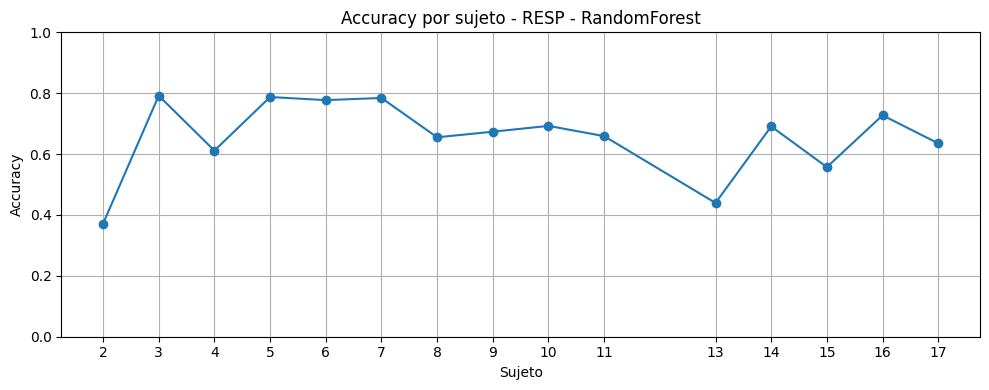

RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.657407  RESP - RandomForest
1  Precision  0.645239  RESP - RandomForest
2     Recall  0.657407  RESP - RandomForest
3   F1 Score  0.648024  RESP - RandomForest
[RESP - RandomForest] Best Params: {}
[RESP - RandomForest] Accuracy: 0.6574
RESP - RandomForest - Confusion Matrix
[[50150 10715  7794]
 [ 5474 30078  3352]
 [10116  6751  4592]]


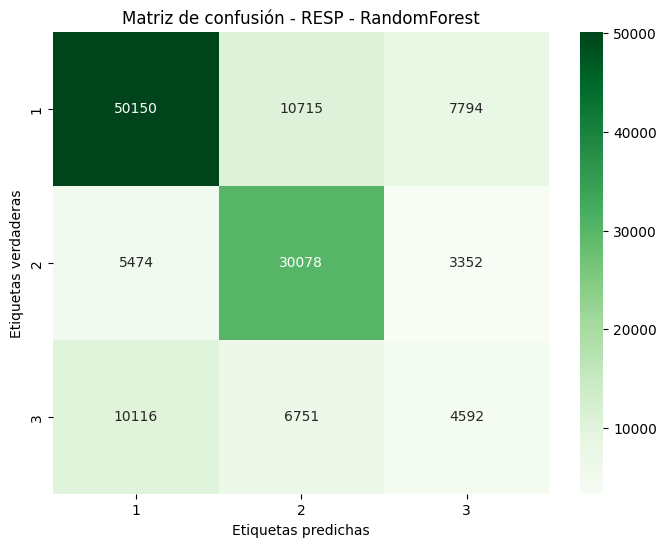

              precision    recall  f1-score   support

           1       0.76      0.73      0.75     68659
           2       0.63      0.77      0.70     38904
           3       0.29      0.21      0.25     21459

    accuracy                           0.66    129022
   macro avg       0.56      0.57      0.56    129022
weighted avg       0.65      0.66      0.65    129022

Training AdaBoost model for RESP using LOGO...
[RESP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[RESP - AdaBoost] Fold 1/15 (Subject: 2)
[RESP - AdaBoost] Fold 2/15 (Subject: 3)
[RESP - AdaBoost] Fold 3/15 (Subject: 4)
[RESP - AdaBoost] Fold 4/15 (Subject: 5)
[RESP - AdaBoost] Fold 5/15 (Subject: 6)
[RESP - AdaBoost] Fold 6/15 (Subject: 7)
[RESP - AdaBoost] Fold 7/15 (Subject: 8)
[RESP - AdaBoost] Fold 8/15 (Subject: 9)
[RESP - AdaBoost] Fold 9/15 (Subject: 10)
[RESP - AdaBoost] Fold 10/15 (Subject: 11)
[RESP - AdaBoost] Fold 11/15 (Subject: 13)
[RESP -

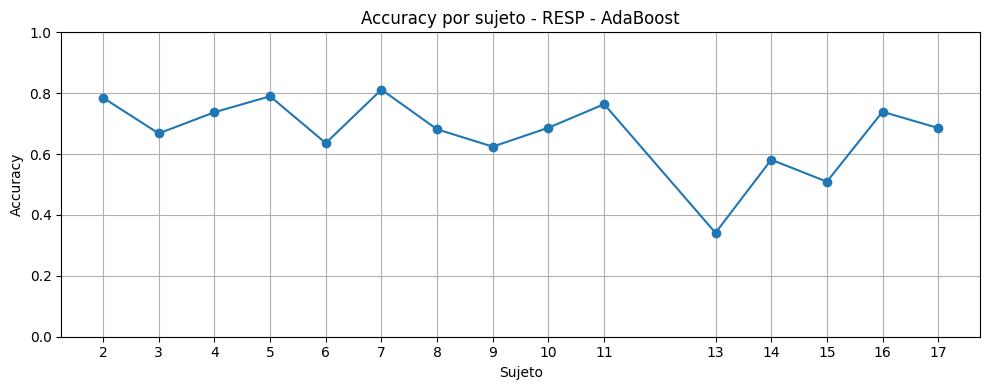

RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.668839  RESP - AdaBoost
1  Precision  0.658960  RESP - AdaBoost
2     Recall  0.668839  RESP - AdaBoost
3   F1 Score  0.651071  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.01, 'n_estimators': 100}
[RESP - AdaBoost] Accuracy: 0.6688
RESP - AdaBoost - Confusion Matrix
[[47526 13607  7526]
 [ 1173 35516  2215]
 [10083  8123  3253]]


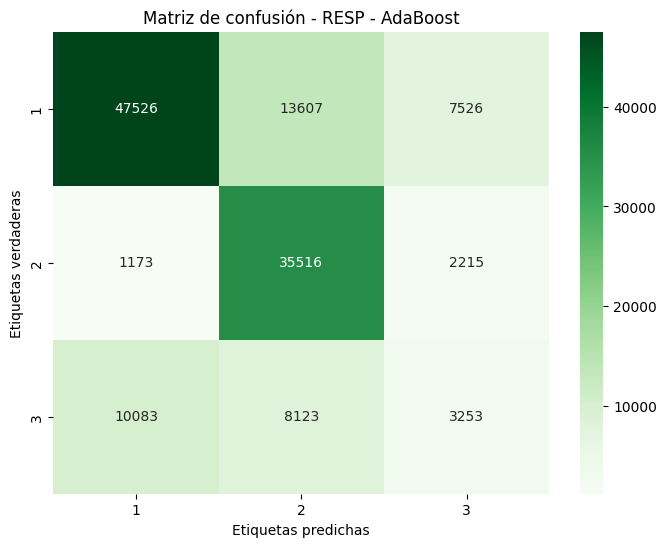

              precision    recall  f1-score   support

           1       0.81      0.69      0.75     68659
           2       0.62      0.91      0.74     38904
           3       0.25      0.15      0.19     21459

    accuracy                           0.67    129022
   macro avg       0.56      0.59      0.56    129022
weighted avg       0.66      0.67      0.65    129022

Training LDA model for RESP using LOGO...
[RESP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[RESP - LDA] Fold 1/15 (Subject: 2)
[RESP - LDA] Fold 2/15 (Subject: 3)
[RESP - LDA] Fold 3/15 (Subject: 4)
[RESP - LDA] Fold 4/15 (Subject: 5)
[RESP - LDA] Fold 5/15 (Subject: 6)
[RESP - LDA] Fold 6/15 (Subject: 7)
[RESP - LDA] Fold 7/15 (Subject: 8)
[RESP - LDA] Fold 8/15 (Subject: 9)
[RESP - LDA] Fold 9/15 (Subject: 10)
[RESP - LDA] Fold 10/15 (Subject: 11)
[RESP - LDA] Fold 11/15 (Subject: 13)
[RESP - LDA] Fold 12/15 (Subject: 14)
[RESP - LDA] Fold 13/15 (Subject: 

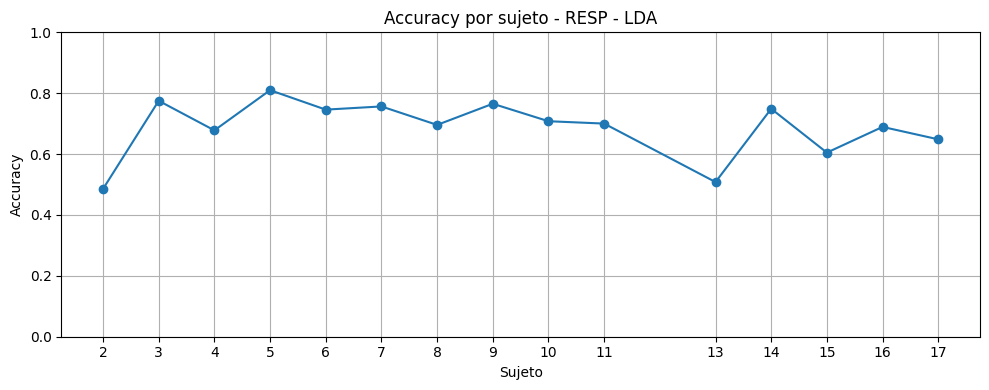

RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.688255  RESP - LDA
1  Precision  0.641637  RESP - LDA
2     Recall  0.688255  RESP - LDA
3   F1 Score  0.657831  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.6883
RESP - LDA - Confusion Matrix
[[57758  6218  4683]
 [ 7720 28917  2267]
 [14827  4507  2125]]


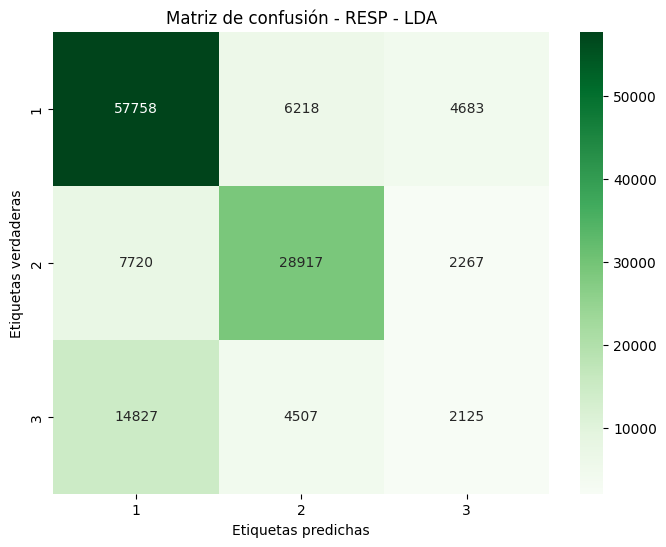

              precision    recall  f1-score   support

           1       0.72      0.84      0.78     68659
           2       0.73      0.74      0.74     38904
           3       0.23      0.10      0.14     21459

    accuracy                           0.69    129022
   macro avg       0.56      0.56      0.55    129022
weighted avg       0.64      0.69      0.66    129022

Training KNN model for RESP using LOGO...
[RESP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[RESP - KNN] Fold 1/15 (Subject: 2)
[RESP - KNN] Fold 2/15 (Subject: 3)
[RESP - KNN] Fold 3/15 (Subject: 4)
[RESP - KNN] Fold 4/15 (Subject: 5)
[RESP - KNN] Fold 5/15 (Subject: 6)
[RESP - KNN] Fold 6/15 (Subject: 7)
[RESP - KNN] Fold 7/15 (Subject: 8)
[RESP - KNN] Fold 8/15 (Subject: 9)
[RESP - KNN] Fold 9/15 (Subject: 10)
[RESP - KNN] Fold 10/15 (Subject: 11)
[RESP - KNN] Fold 11/15 (Subject: 13)
[RESP - KNN] Fold 12/15 (Subject: 14)
[RESP - KNN] Fold 13/15 (Subject: 

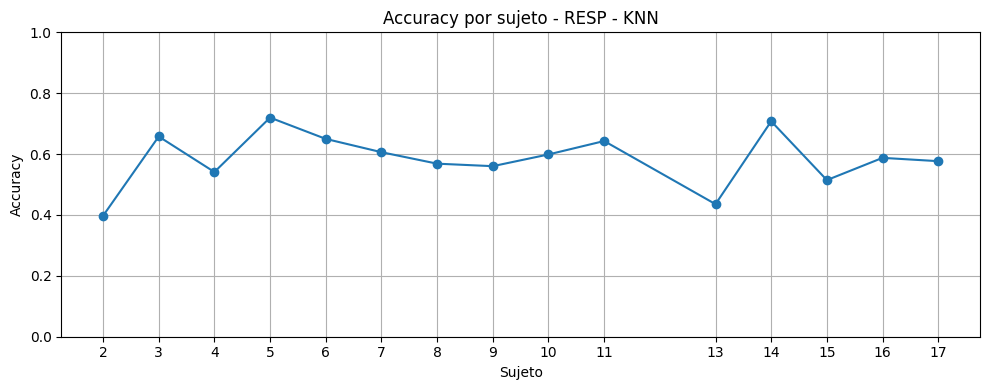

RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.584792  RESP - KNN
1  Precision  0.596553  RESP - KNN
2     Recall  0.584792  RESP - KNN
3   F1 Score  0.589986  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[RESP - KNN] Accuracy: 0.5848
RESP - KNN - Confusion Matrix
[[45031 10961 12667]
 [ 9463 23979  5462]
 [ 9658  5360  6441]]


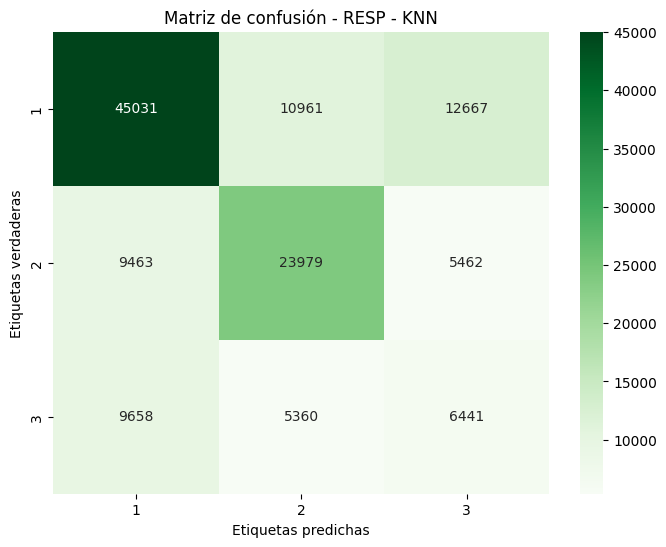

Training by signal:  80%|████████  | 4/5 [1:34:50<22:49, 1369.03s/it]

              precision    recall  f1-score   support

           1       0.70      0.66      0.68     68659
           2       0.60      0.62      0.61     38904
           3       0.26      0.30      0.28     21459

    accuracy                           0.58    129022
   macro avg       0.52      0.52      0.52    129022
weighted avg       0.60      0.58      0.59    129022

Training DecisionTree model for TEMP using LOGO...
[TEMP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[TEMP - DecisionTree] Fold 1/15 (Subject: 2)
[TEMP - DecisionTree] Fold 2/15 (Subject: 3)
[TEMP - DecisionTree] Fold 3/15 (Subject: 4)
[TEMP - DecisionTree] Fold 4/15 (Subject: 5)
[TEMP - DecisionTree] Fold 5/15 (Subject: 6)
[TEMP - DecisionTree] Fold 6/15 (Subject: 7)
[TEMP - DecisionTree] Fold 7/15 (Subject: 8)
[TEMP - DecisionTree] Fold 8/15 (Subject: 9)
[TEMP - DecisionTree] Fold 9/15 (Subject: 10)
[TEMP - DecisionTree] Fold 10/15 (Subject: 11)
[T

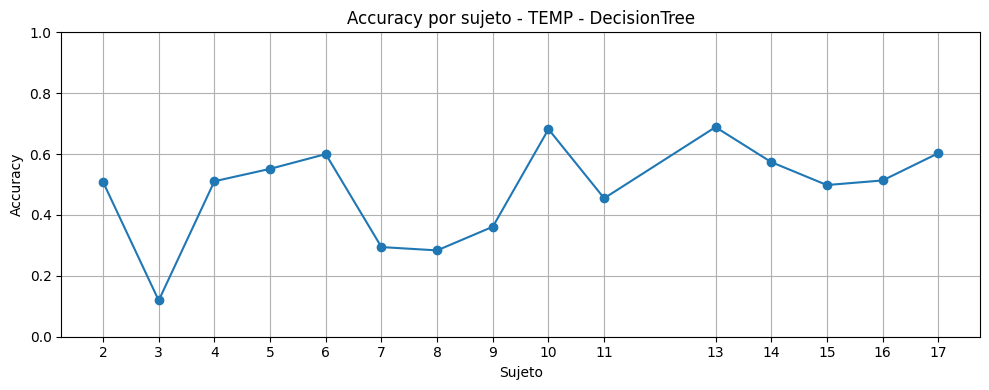

TEMP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.484297  TEMP - DecisionTree
1  Precision  0.478576  TEMP - DecisionTree
2     Recall  0.484297  TEMP - DecisionTree
3   F1 Score  0.480784  TEMP - DecisionTree
[TEMP - DecisionTree] Best Params: {}
[TEMP - DecisionTree] Accuracy: 0.4843
TEMP - DecisionTree - Confusion Matrix
[[42328 19412  6919]
 [19797 14319  4788]
 [ 9259  6362  5838]]


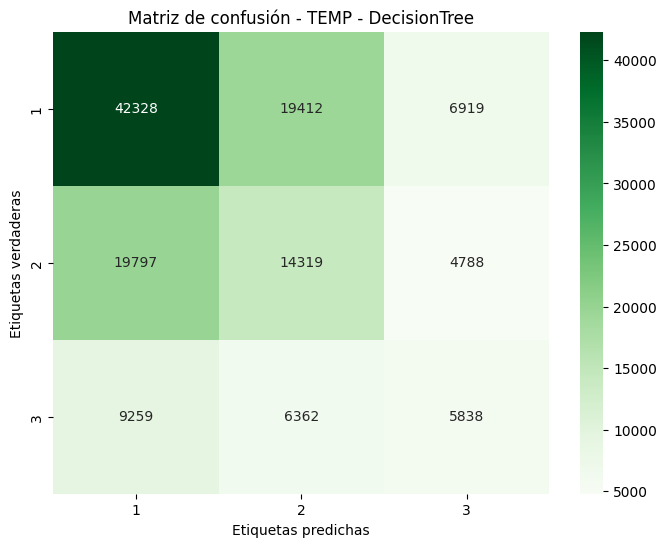

              precision    recall  f1-score   support

           1       0.59      0.62      0.60     68659
           2       0.36      0.37      0.36     38904
           3       0.33      0.27      0.30     21459

    accuracy                           0.48    129022
   macro avg       0.43      0.42      0.42    129022
weighted avg       0.48      0.48      0.48    129022

Training RandomForest model for TEMP using LOGO...
[TEMP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[TEMP - RandomForest] Fold 1/15 (Subject: 2)
[TEMP - RandomForest] Fold 2/15 (Subject: 3)
[TEMP - RandomForest] Fold 3/15 (Subject: 4)
[TEMP - RandomForest] Fold 4/15 (Subject: 5)
[TEMP - RandomForest] Fold 5/15 (Subject: 6)
[TEMP - RandomForest] Fold 6/15 (Subject: 7)
[TEMP - RandomForest] Fold 7/15 (Subject: 8)
[TEMP - RandomForest] Fold 8/15 (Subject: 9)
[TEMP - RandomForest] Fold 9/15 (Subject: 10)
[TEMP - RandomForest] Fold 10/15 (Subject: 11)
[T

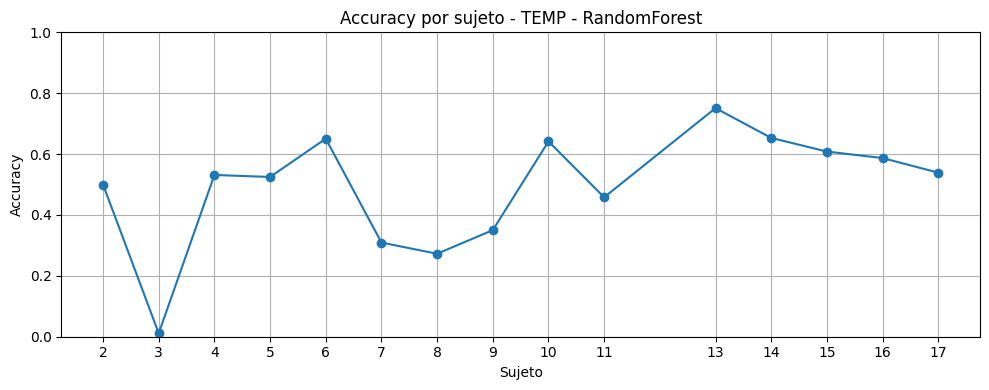

TEMP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.494117  TEMP - RandomForest
1  Precision  0.486385  TEMP - RandomForest
2     Recall  0.494117  TEMP - RandomForest
3   F1 Score  0.488500  TEMP - RandomForest
[TEMP - RandomForest] Best Params: {}
[TEMP - RandomForest] Accuracy: 0.4941
TEMP - RandomForest - Confusion Matrix
[[44014 19782  4863]
 [20333 13777  4794]
 [ 9076  6422  5961]]


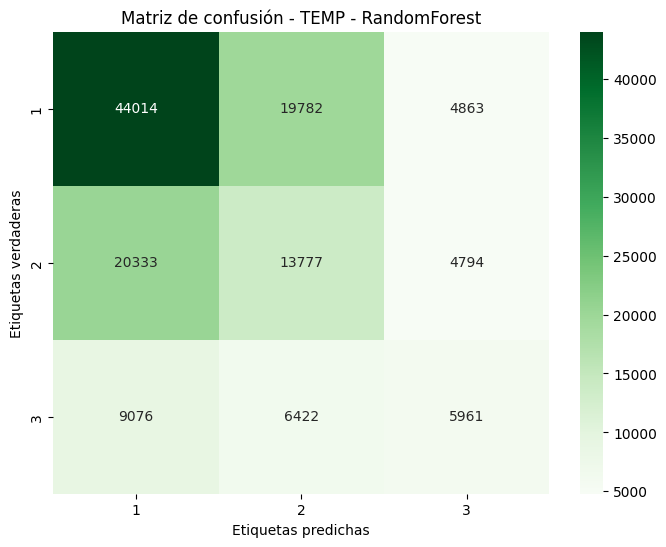

              precision    recall  f1-score   support

           1       0.60      0.64      0.62     68659
           2       0.34      0.35      0.35     38904
           3       0.38      0.28      0.32     21459

    accuracy                           0.49    129022
   macro avg       0.44      0.42      0.43    129022
weighted avg       0.49      0.49      0.49    129022

Training AdaBoost model for TEMP using LOGO...
[TEMP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[TEMP - AdaBoost] Fold 1/15 (Subject: 2)
[TEMP - AdaBoost] Fold 2/15 (Subject: 3)
[TEMP - AdaBoost] Fold 3/15 (Subject: 4)
[TEMP - AdaBoost] Fold 4/15 (Subject: 5)
[TEMP - AdaBoost] Fold 5/15 (Subject: 6)
[TEMP - AdaBoost] Fold 6/15 (Subject: 7)
[TEMP - AdaBoost] Fold 7/15 (Subject: 8)
[TEMP - AdaBoost] Fold 8/15 (Subject: 9)
[TEMP - AdaBoost] Fold 9/15 (Subject: 10)
[TEMP - AdaBoost] Fold 10/15 (Subject: 11)
[TEMP - AdaBoost] Fold 11/15 (Subject: 13)
[TEMP -

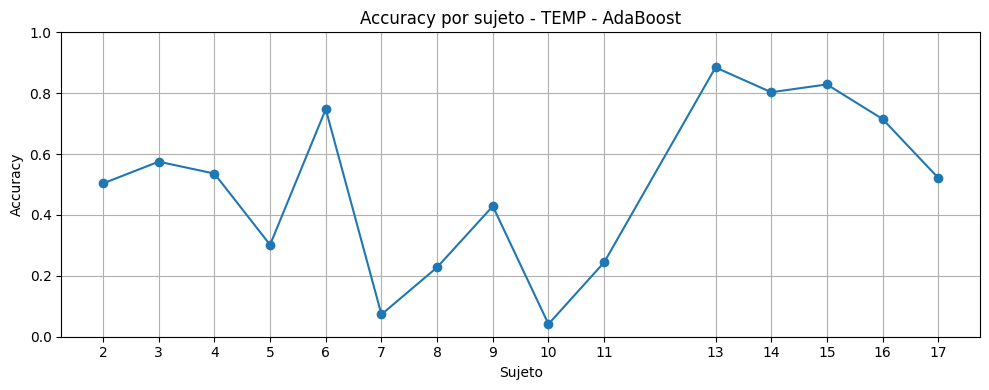

TEMP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.495102  TEMP - AdaBoost
1  Precision  0.529415  TEMP - AdaBoost
2     Recall  0.495102  TEMP - AdaBoost
3   F1 Score  0.506543  TEMP - AdaBoost
[TEMP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.01, 'n_estimators': 100}
[TEMP - AdaBoost] Accuracy: 0.4951
TEMP - AdaBoost - Confusion Matrix
[[40844 24254  3561]
 [ 9201 17896 11807]
 [ 6601  9719  5139]]


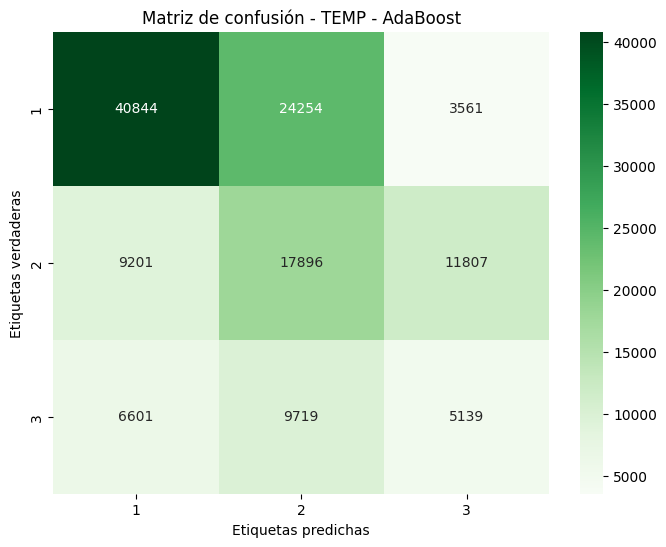

              precision    recall  f1-score   support

           1       0.72      0.59      0.65     68659
           2       0.35      0.46      0.39     38904
           3       0.25      0.24      0.24     21459

    accuracy                           0.50    129022
   macro avg       0.44      0.43      0.43    129022
weighted avg       0.53      0.50      0.51    129022

Training LDA model for TEMP using LOGO...
[TEMP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[TEMP - LDA] Fold 1/15 (Subject: 2)
[TEMP - LDA] Fold 2/15 (Subject: 3)
[TEMP - LDA] Fold 3/15 (Subject: 4)
[TEMP - LDA] Fold 4/15 (Subject: 5)
[TEMP - LDA] Fold 5/15 (Subject: 6)
[TEMP - LDA] Fold 6/15 (Subject: 7)
[TEMP - LDA] Fold 7/15 (Subject: 8)
[TEMP - LDA] Fold 8/15 (Subject: 9)
[TEMP - LDA] Fold 9/15 (Subject: 10)
[TEMP - LDA] Fold 10/15 (Subject: 11)
[TEMP - LDA] Fold 11/15 (Subject: 13)
[TEMP - LDA] Fold 12/15 (Subject: 14)
[TEMP - LDA] Fold 13/15 (Subject: 

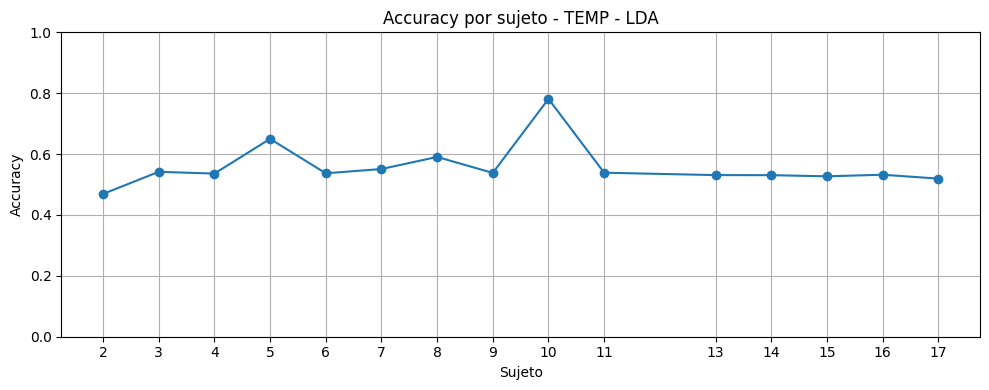

TEMP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.558920  TEMP - LDA
1  Precision  0.645718  TEMP - LDA
2     Recall  0.558920  TEMP - LDA
3   F1 Score  0.443571  TEMP - LDA
[TEMP - LDA] Best Params: {'solver': 'svd'}
[TEMP - LDA] Accuracy: 0.5589
TEMP - LDA - Confusion Matrix
[[66793  1866     0]
 [33584  5320     0]
 [19924  1535     0]]


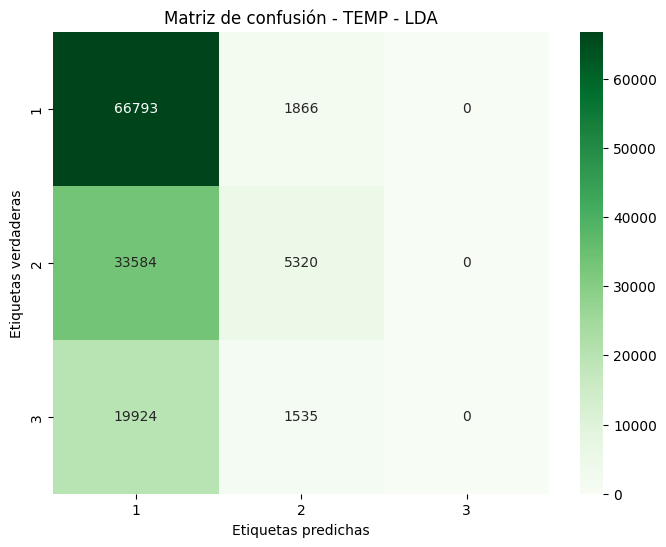

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.56      0.97      0.71     68659
           2       0.61      0.14      0.22     38904
           3       0.00      0.00      0.00     21459

    accuracy                           0.56    129022
   macro avg       0.39      0.37      0.31    129022
weighted avg       0.48      0.56      0.44    129022

Training KNN model for TEMP using LOGO...
[TEMP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[TEMP - KNN] Fold 1/15 (Subject: 2)
[TEMP - KNN] Fold 2/15 (Subject: 3)
[TEMP - KNN] Fold 3/15 (Subject: 4)
[TEMP - KNN] Fold 4/15 (Subject: 5)
[TEMP - KNN] Fold 5/15 (Subject: 6)
[TEMP - KNN] Fold 6/15 (Subject: 7)
[TEMP - KNN] Fold 7/15 (Subject: 8)
[TEMP - KNN] Fold 8/15 (Subject: 9)
[TEMP - KNN] Fold 9/15 (Subject: 10)
[TEMP - KNN] Fold 10/15 (Subject: 11)
[TEMP - KNN] Fold 11/15 (Subject: 13)
[TEMP - KNN] Fold 12/15 (Subject: 14)
[TEMP - KNN] Fold 13/15 (Subject: 

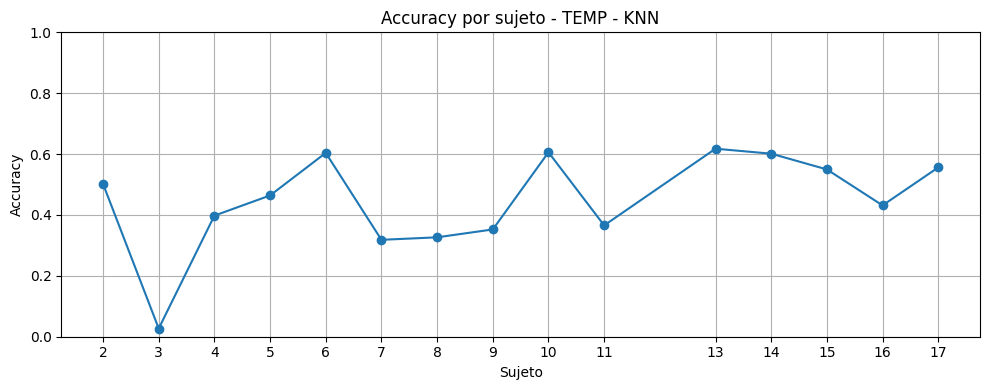

TEMP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.449435  TEMP - KNN
1  Precision  0.443479  TEMP - KNN
2     Recall  0.449435  TEMP - KNN
3   F1 Score  0.445731  TEMP - KNN
[TEMP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[TEMP - KNN] Accuracy: 0.4494
TEMP - KNN - Confusion Matrix
[[40411 20846  7402]
 [19268 13941  5695]
 [ 9967  7857  3635]]


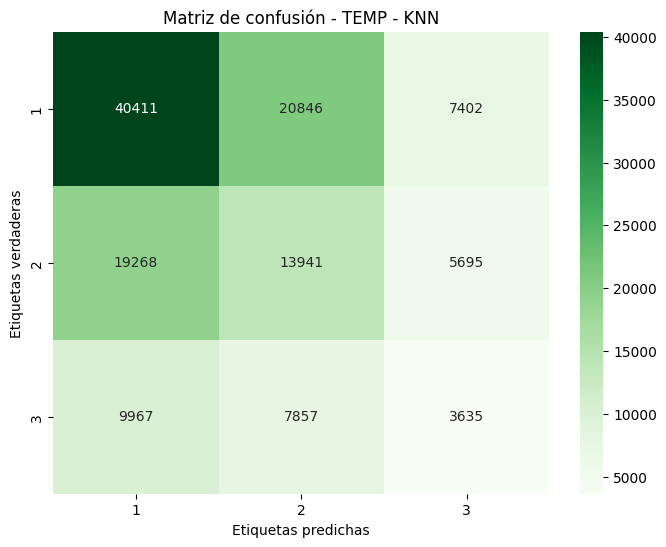

Training by signal: 100%|██████████| 5/5 [1:45:48<00:00, 1269.63s/it]


              precision    recall  f1-score   support

           1       0.58      0.59      0.58     68659
           2       0.33      0.36      0.34     38904
           3       0.22      0.17      0.19     21459

    accuracy                           0.45    129022
   macro avg       0.37      0.37      0.37    129022
weighted avg       0.44      0.45      0.45    129022



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOGO...
[ALL - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ALL - DecisionTree] Fold 1/15 (Subject: 2)
[ALL - DecisionTree] Fold 2/15 (Subject: 3)
[ALL - DecisionTree] Fold 3/15 (Subject: 4)
[ALL - DecisionTree] Fold 4/15 (Subject: 5)
[ALL - DecisionTree] Fold 5/15 (Subject: 6)
[ALL - DecisionTree] Fold 6/15 (Subject: 7)
[ALL - DecisionTree] Fold 7/15 (Subject: 8)
[ALL - DecisionTree] Fold 8/15 (Subject: 9)
[ALL - DecisionTree] Fold 9/15 (Subject: 10)
[ALL - DecisionTree] Fold 10/15 (Subject: 11)
[ALL - DecisionTree] Fold 11/15 (Subject: 13)
[ALL - DecisionTree] Fold 12/15 (Subject: 14)
[ALL - DecisionTree] Fold 13/15 (Subject: 15)
[ALL - DecisionTree] Fold 14/15 (Subject: 16)
[ALL - DecisionTree] Fold 15/15 (Subject: 17)


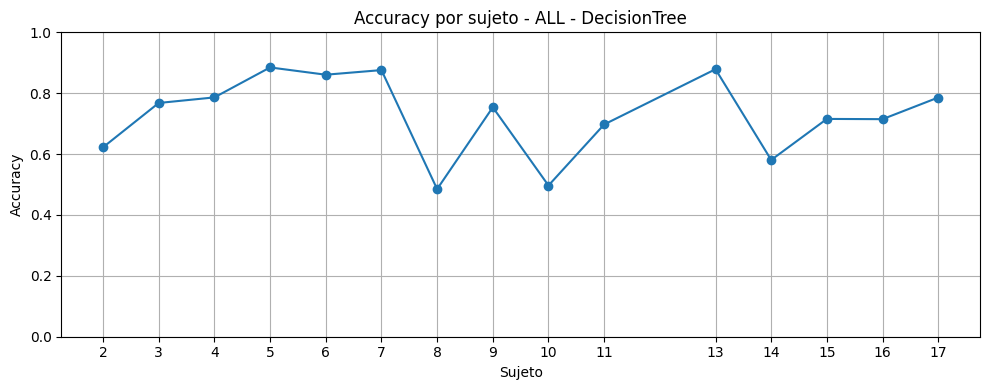

ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.726791  ALL - DecisionTree
1  Precision  0.731800  ALL - DecisionTree
2     Recall  0.726791  ALL - DecisionTree
3   F1 Score  0.728923  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {}
[ALL - DecisionTree] Accuracy: 0.7268
ALL - DecisionTree - Confusion Matrix
[[53419  6132  9108]
 [ 5343 30032  3529]
 [ 6934  4204 10321]]


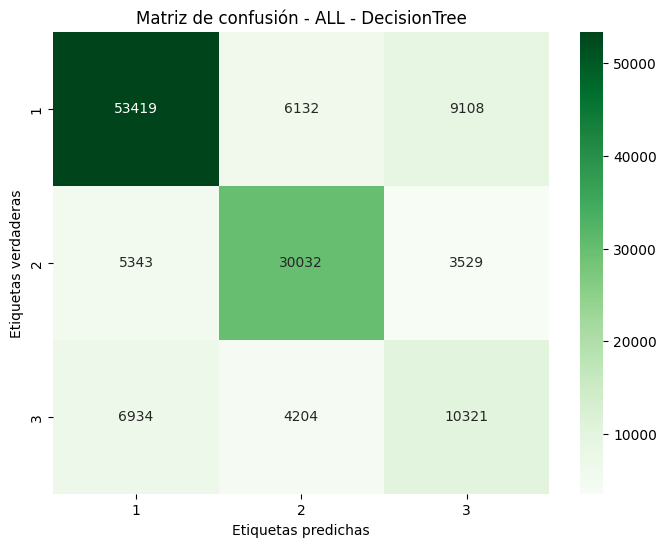

Training with ALL signals:  20%|██        | 1/5 [02:24<09:36, 144.03s/it]

              precision    recall  f1-score   support

           1       0.81      0.78      0.80     68659
           2       0.74      0.77      0.76     38904
           3       0.45      0.48      0.46     21459

    accuracy                           0.73    129022
   macro avg       0.67      0.68      0.67    129022
weighted avg       0.73      0.73      0.73    129022

Training RandomForest model for ALL signals using LOGO...
[ALL - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ALL - RandomForest] Fold 1/15 (Subject: 2)
[ALL - RandomForest] Fold 2/15 (Subject: 3)
[ALL - RandomForest] Fold 3/15 (Subject: 4)
[ALL - RandomForest] Fold 4/15 (Subject: 5)
[ALL - RandomForest] Fold 5/15 (Subject: 6)
[ALL - RandomForest] Fold 6/15 (Subject: 7)
[ALL - RandomForest] Fold 7/15 (Subject: 8)
[ALL - RandomForest] Fold 8/15 (Subject: 9)
[ALL - RandomForest] Fold 9/15 (Subject: 10)
[ALL - RandomForest] Fold 10/15 (Subject: 11)
[ALL -

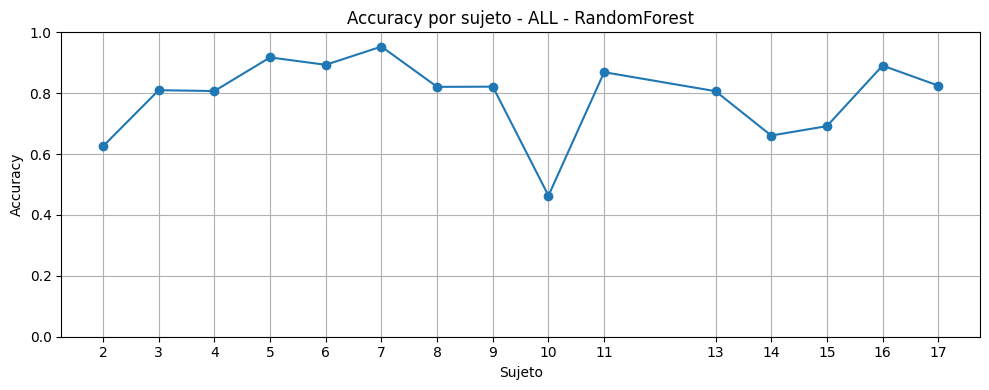

ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.790137  ALL - RandomForest
1  Precision  0.769782  ALL - RandomForest
2     Recall  0.790137  ALL - RandomForest
3   F1 Score  0.774729  ALL - RandomForest
[ALL - RandomForest] Best Params: {}
[ALL - RandomForest] Accuracy: 0.7901
ALL - RandomForest - Confusion Matrix
[[62428  1262  4969]
 [ 3200 33380  2324]
 [12446  2876  6137]]


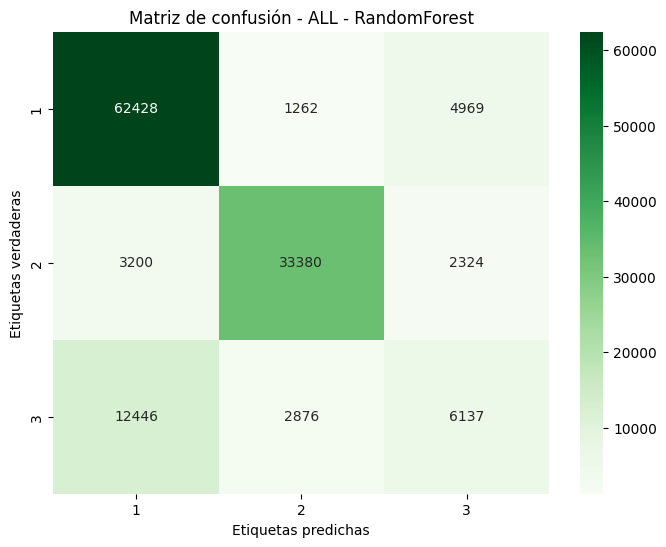

Training with ALL signals:  40%|████      | 2/5 [24:30<41:58, 839.35s/it]

              precision    recall  f1-score   support

           1       0.80      0.91      0.85     68659
           2       0.89      0.86      0.87     38904
           3       0.46      0.29      0.35     21459

    accuracy                           0.79    129022
   macro avg       0.72      0.68      0.69    129022
weighted avg       0.77      0.79      0.77    129022

Training AdaBoost model for ALL signals using LOGO...
[ALL - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[ALL - AdaBoost] Fold 1/15 (Subject: 2)
[ALL - AdaBoost] Fold 2/15 (Subject: 3)
[ALL - AdaBoost] Fold 3/15 (Subject: 4)
[ALL - AdaBoost] Fold 4/15 (Subject: 5)
[ALL - AdaBoost] Fold 5/15 (Subject: 6)
[ALL - AdaBoost] Fold 6/15 (Subject: 7)
[ALL - AdaBoost] Fold 7/15 (Subject: 8)
[ALL - AdaBoost] Fold 8/15 (Subject: 9)
[ALL - AdaBoost] Fold 9/15 (Subject: 10)
[ALL - AdaBoost] Fold 10/15 (Subject: 11)
[ALL - AdaBoost] Fold 11/15 (Subject: 13)
[ALL - AdaBo

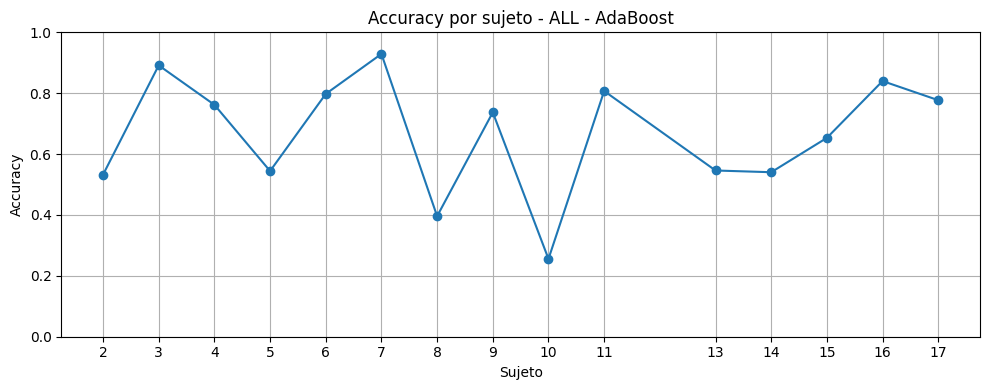

ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.666359  ALL - AdaBoost
1  Precision  0.736481  ALL - AdaBoost
2     Recall  0.666359  ALL - AdaBoost
3   F1 Score  0.691526  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.5, 'n_estimators': 100}
[ALL - AdaBoost] Accuracy: 0.6664
ALL - AdaBoost - Confusion Matrix
[[45492  1011 22156]
 [ 4461 29407  5036]
 [ 8253  2130 11076]]


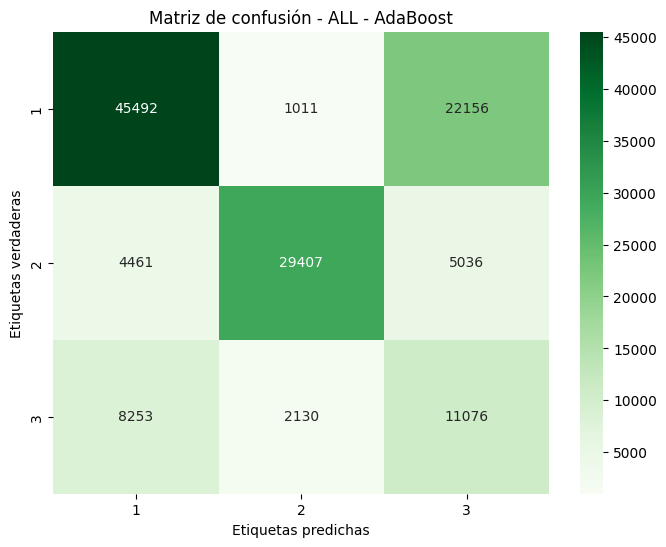

Training with ALL signals:  60%|██████    | 3/5 [1:07:50<54:46, 1643.28s/it]

              precision    recall  f1-score   support

           1       0.78      0.66      0.72     68659
           2       0.90      0.76      0.82     38904
           3       0.29      0.52      0.37     21459

    accuracy                           0.67    129022
   macro avg       0.66      0.64      0.64    129022
weighted avg       0.74      0.67      0.69    129022

Training LDA model for ALL signals using LOGO...
[ALL - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ALL - LDA] Fold 1/15 (Subject: 2)
[ALL - LDA] Fold 2/15 (Subject: 3)
[ALL - LDA] Fold 3/15 (Subject: 4)
[ALL - LDA] Fold 4/15 (Subject: 5)
[ALL - LDA] Fold 5/15 (Subject: 6)
[ALL - LDA] Fold 6/15 (Subject: 7)
[ALL - LDA] Fold 7/15 (Subject: 8)
[ALL - LDA] Fold 8/15 (Subject: 9)
[ALL - LDA] Fold 9/15 (Subject: 10)
[ALL - LDA] Fold 10/15 (Subject: 11)
[ALL - LDA] Fold 11/15 (Subject: 13)
[ALL - LDA] Fold 12/15 (Subject: 14)
[ALL - LDA] Fold 13/15 (Subject: 15)
[AL

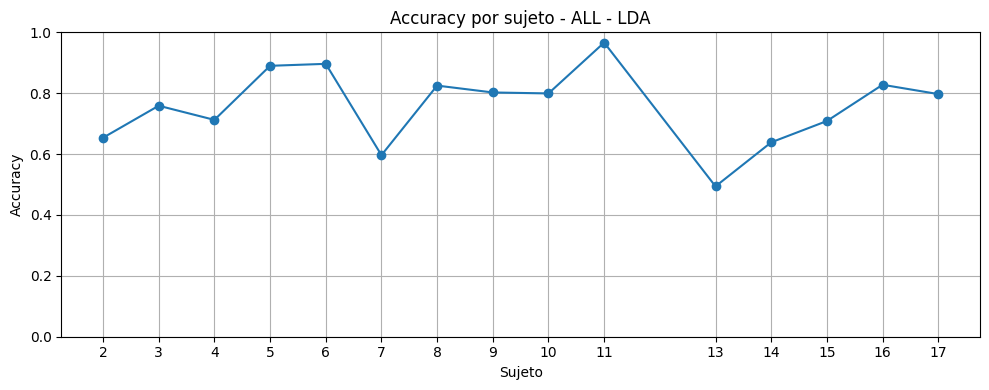

ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.758274  ALL - LDA
1  Precision  0.759331  ALL - LDA
2     Recall  0.758274  ALL - LDA
3   F1 Score  0.758489  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.7583
ALL - LDA - Confusion Matrix
[[55937  4674  8048]
 [ 5875 30699  2330]
 [ 8964  1297 11198]]


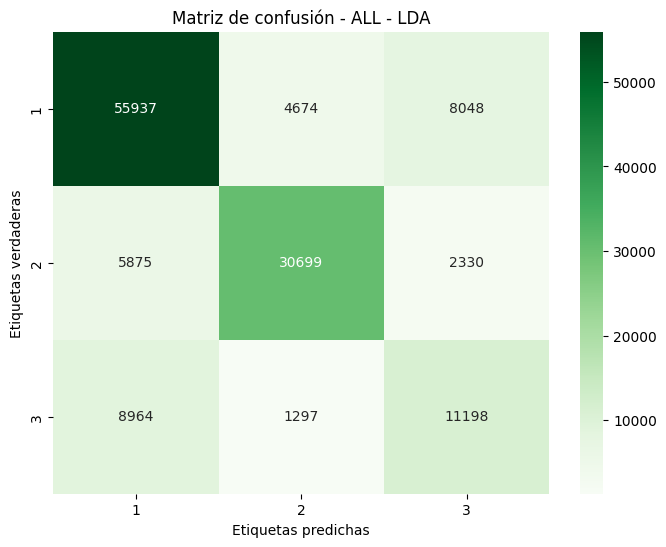

Training with ALL signals:  80%|████████  | 4/5 [1:08:10<16:42, 1002.65s/it]

              precision    recall  f1-score   support

           1       0.79      0.81      0.80     68659
           2       0.84      0.79      0.81     38904
           3       0.52      0.52      0.52     21459

    accuracy                           0.76    129022
   macro avg       0.72      0.71      0.71    129022
weighted avg       0.76      0.76      0.76    129022

Training KNN model for ALL signals using LOGO...
[ALL - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[ALL - KNN] Fold 1/15 (Subject: 2)
[ALL - KNN] Fold 2/15 (Subject: 3)
[ALL - KNN] Fold 3/15 (Subject: 4)
[ALL - KNN] Fold 4/15 (Subject: 5)
[ALL - KNN] Fold 5/15 (Subject: 6)
[ALL - KNN] Fold 6/15 (Subject: 7)
[ALL - KNN] Fold 7/15 (Subject: 8)
[ALL - KNN] Fold 8/15 (Subject: 9)
[ALL - KNN] Fold 9/15 (Subject: 10)
[ALL - KNN] Fold 10/15 (Subject: 11)
[ALL - KNN] Fold 11/15 (Subject: 13)
[ALL - KNN] Fold 12/15 (Subject: 14)
[ALL - KNN] Fold 13/15 (Subject: 15)
[AL

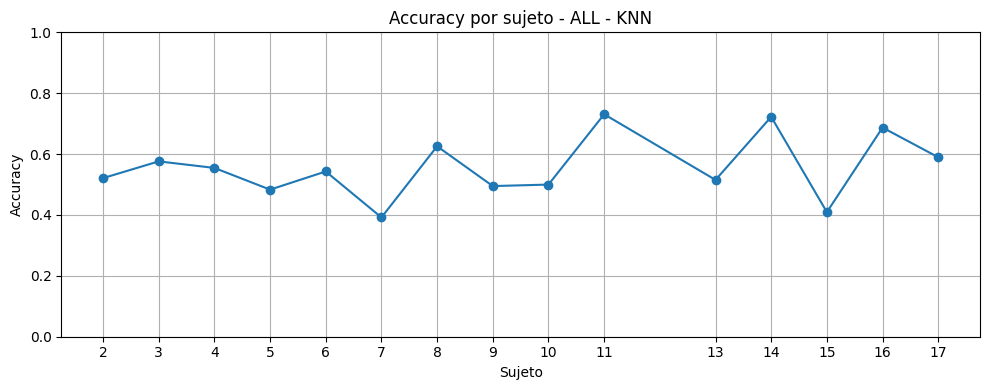

ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.556510  ALL - KNN
1  Precision  0.555470  ALL - KNN
2     Recall  0.556510  ALL - KNN
3   F1 Score  0.555242  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[ALL - KNN] Accuracy: 0.5565
ALL - KNN - Confusion Matrix
[[45795 11148 11716]
 [13483 20837  4584]
 [13297  2992  5170]]


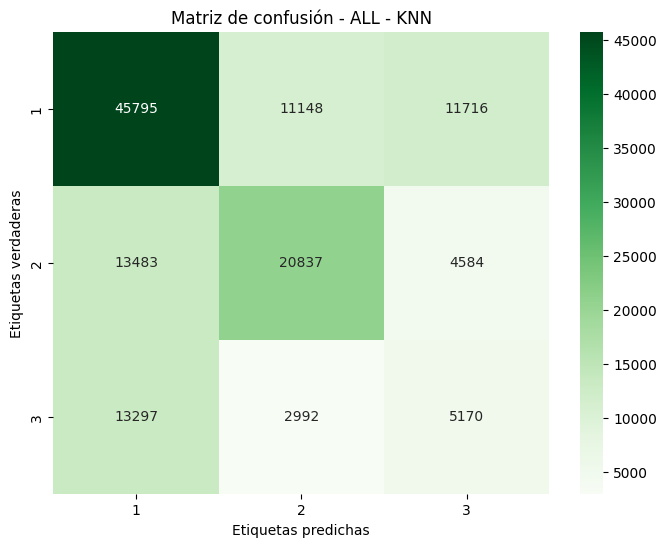

Training with ALL signals: 100%|██████████| 5/5 [1:08:45<00:00, 825.12s/it] 

              precision    recall  f1-score   support

           1       0.63      0.67      0.65     68659
           2       0.60      0.54      0.56     38904
           3       0.24      0.24      0.24     21459

    accuracy                           0.56    129022
   macro avg       0.49      0.48      0.48    129022
weighted avg       0.56      0.56      0.56    129022


Final Comparison:
ECG_BVP - DecisionTree:
     Métrica     Valor                   Etapa
0   Accuracy  0.589000  ECG_BVP - DecisionTree
1  Precision  0.601456  ECG_BVP - DecisionTree
2     Recall  0.589000  ECG_BVP - DecisionTree
3   F1 Score  0.593761  ECG_BVP - DecisionTree
ECG_BVP - RandomForest:
     Métrica     Valor                   Etapa
0   Accuracy  0.615895  ECG_BVP - RandomForest
1  Precision  0.607854  ECG_BVP - RandomForest
2     Recall  0.615895  ECG_BVP - RandomForest
3   F1 Score  0.611734  ECG_BVP - RandomForest
ECG_BVP - AdaBoost:
     Métrica     Valor               Etapa
0   Accuracy  0.594

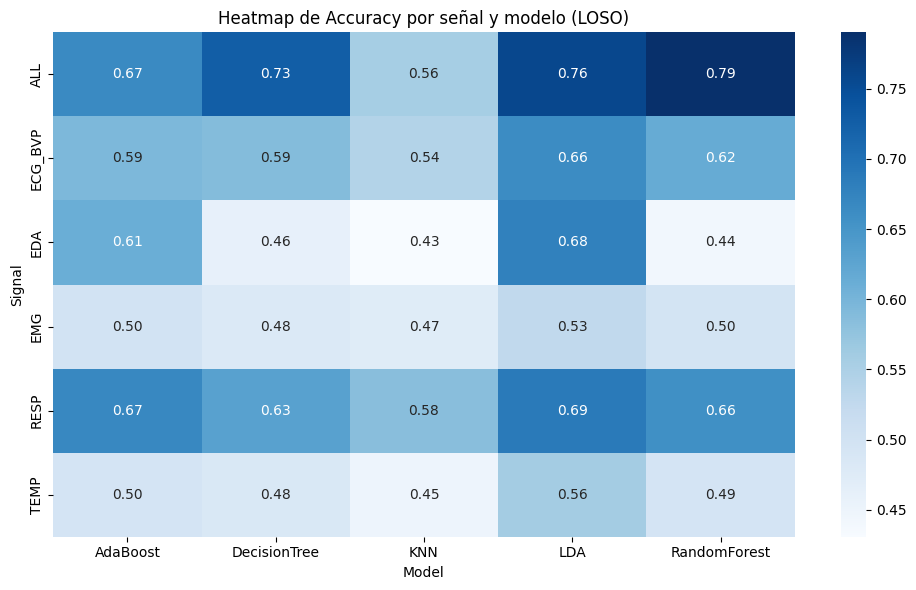

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_14388\1711118399.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

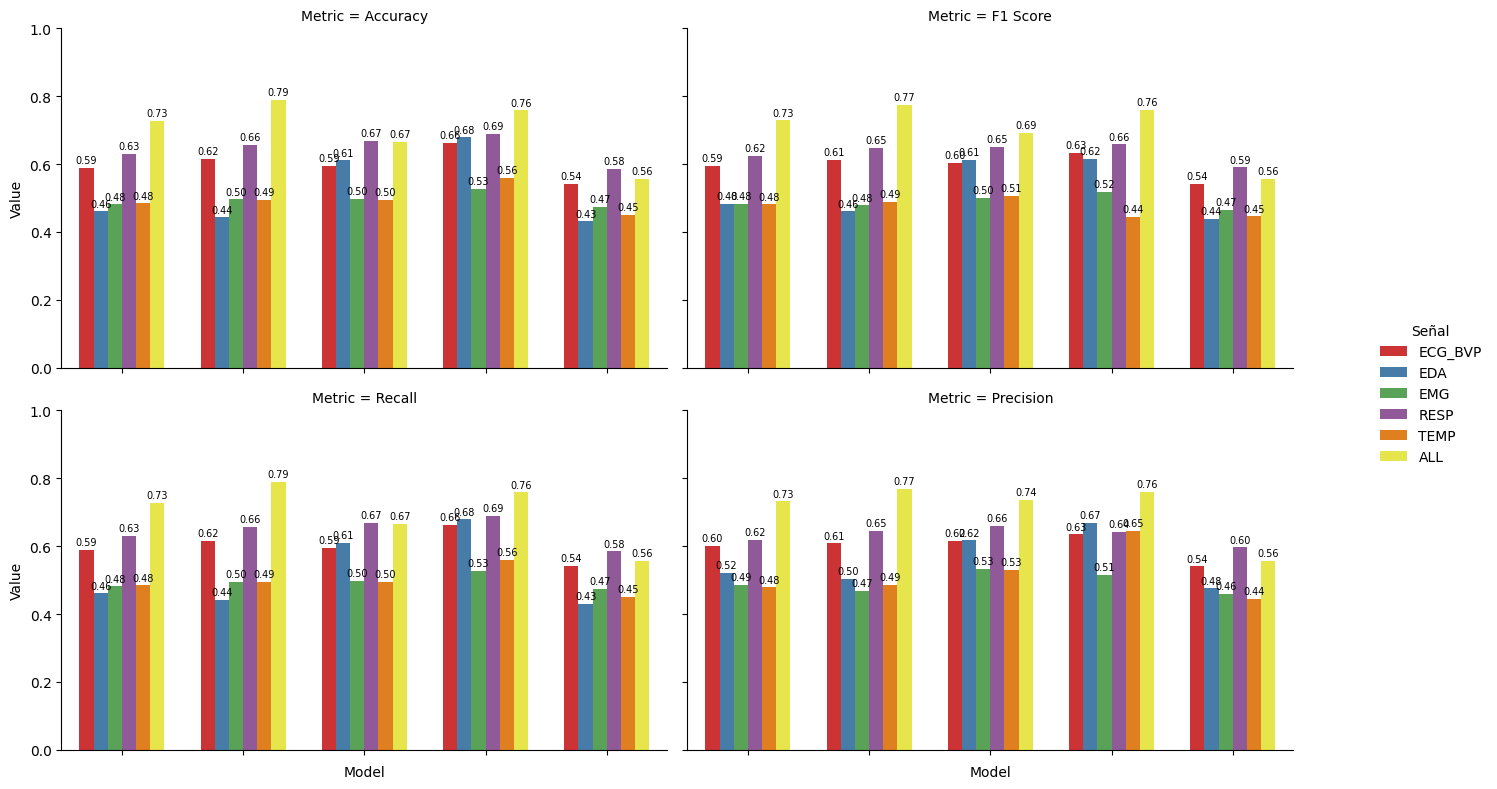

In [147]:
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features].values  # Convertimos a array
        y = df['label'].values
        subjects = df['subject'].values  # Identificador de sujetos

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOGO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas usando LOGO
X_all = df.drop(columns=['label', 'subject']).values
y_all = df['label'].values
subjects_all = df['subject'].values

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOGO...')
    metrics = train_and_evaluate_logo(X_all, y_all, subjects_all, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()